In [59]:
import pandas as pd
import pandas as pd
import numpy as np
from keras.utils import np_utils
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, make_scorer, f1_score,precision_score,recall_score
from sklearn.preprocessing import MinMaxScaler
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import classification_report, plot_confusion_matrix,fbeta_score, make_scorer
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import np_utils
import time

In [60]:
def print_distribution(arr, print_nl=True):
    arr = np.unique(arr, return_counts=True)[1] / len(arr)
    for i in range(arr.shape[0]):
        print("Classe %d: %.2f%%" %(i, arr[i]*100))

    if print_nl:
        print("\n")

In [69]:
def taste(quality):
  if quality <= 5:
    return 0
  elif quality == 6:
    return 1
  else:
    return 2

In [70]:
time_begin = time.time()
data = pd.read_csv("wine_quality.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed.acidity         6497 non-null   float64
 1   volatile.acidity      6497 non-null   float64
 2   citric.acid           6497 non-null   float64
 3   residual.sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free.sulfur.dioxide   6497 non-null   float64
 6   total.sulfur.dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 609.2 KB


In [71]:
new_data = data
new_data["taste"] = data["quality"].apply(taste)

In [72]:
new_data

,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality,taste
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6,1
6493,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5,0
6494,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6,1
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7,2


## Divisão de base de dados e separação de base

In [73]:
X = new_data.iloc[:, 0:11].values
y = new_data.iloc[:, 12].values

In [74]:
print("Proporções por classe no dataset em geral:")
print_distribution(y)

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=199)
fold = 0
for train, test in kf.split(X, y):
    print("Fold %d" %(fold))
    print_distribution(y[train], print_nl=(fold != 2))
    fold += 1

Proporções por classe no dataset em geral:
Classe 0: 36.69%
Classe 1: 43.65%
Classe 2: 19.66%


Fold 0
Classe 0: 36.69%
Classe 1: 43.66%
Classe 2: 19.65%


Fold 1
Classe 0: 36.69%
Classe 1: 43.66%
Classe 2: 19.65%


Fold 2
Classe 0: 36.69%
Classe 1: 43.66%
Classe 2: 19.65%
Fold 3
Classe 0: 36.69%
Classe 1: 43.66%
Classe 2: 19.65%


Fold 4
Classe 0: 36.70%
Classe 1: 43.65%
Classe 2: 19.65%


Fold 5
Classe 0: 36.70%
Classe 1: 43.65%
Classe 2: 19.65%


Fold 6
Classe 0: 36.70%
Classe 1: 43.65%
Classe 2: 19.65%


Fold 7
Classe 0: 36.70%
Classe 1: 43.64%
Classe 2: 19.66%


Fold 8
Classe 0: 36.70%
Classe 1: 43.64%
Classe 2: 19.66%


Fold 9
Classe 0: 36.70%
Classe 1: 43.64%
Classe 2: 19.66%




In [75]:
kf_accuracy = list()
kf_conf_mat = list()
kf_precision = list()
kf_f1 = list()
kf_recall = list()
kf_roc = list()

In [76]:
def createANN(epochs,activation, neurons):
    classifier = Sequential()
    classifier.add(Dense(units=neurons, activation=activation,input_dim=11))
    classifier.add(Dropout(0.1))
    classifier.add(Dense(units=neurons, activation=activation))
    classifier.add(Dropout(0.1))
    classifier.add(Dense(units=3, activation="softmax"))
    classifier.compile(optimizer="adam", loss="sparse_categorical_crossentropy",
                       metrics=["accuracy"])
    classifier.fit(X_train, y_train, batch_size=32, epochs=epochs)
    return classifier

In [77]:
for train_ix, test_ix in kf.split(X,y):
    X_train, X_test = X[train_ix, :], X[test_ix, :]
    y_train, y_test = y[train_ix], y[test_ix]
    classifier = KerasClassifier(build_fn=createANN)
    parameters={"epochs": [10,20],
                "activation":["linear","relu"],
                "neurons": [8,16]}
    # parâmetros para teste do gridsearch
    search = GridSearchCV(estimator=classifier, param_grid=parameters, scoring="accuracy", cv=10, refit=True)
    # executar e salvar melhores parâmetros do grisearch
    result = search.fit(X_train, y_train)
    # teste dos melhores parâmetros
    best_model = result.best_estimator_
    # evaluate model on the hold out dataset
    predicted_y = best_model.predict(X_test)
    #transformação de itens para cálculo do ROC
    y_test_dummy = np_utils.to_categorical(y_test)
    y_test_dummy
    predicted_y_dummy = np_utils.to_categorical(predicted_y)
    predicted_y_dummy
    # métricas do modelo
    acc = accuracy_score(y_test, predicted_y)
    conf_mat = confusion_matrix(y_test, predicted_y)
    precision = precision_score(y_test, predicted_y, average = "macro")
    f1 = f1_score(y_test, predicted_y, average = "macro")
    recall = recall_score(y_test, predicted_y, average = "macro")
    roc = roc_auc_score(y_test_dummy,predicted_y_dummy,multi_class="ovo",average = "macro")
    # armazenamento de métricas
    kf_accuracy.append(acc)
    kf_conf_mat.append(conf_mat)
    kf_precision.append(precision)
    kf_f1.append(f1)
    kf_recall.append(recall)
    kf_roc.append(roc)
    #métricas
    print(">acc=%.3f,>prec=%.3f,>f1=%.3f,>rec=%.3f,>roc=%.3f, est=%.3f, cfg=%s" % (acc,precision,f1,recall,roc, result.best_score_, result.best_params_))
    print(conf_mat)

C:\Users\cfpc2\AppData\Local\Temp/ipykernel_2256/4246655429.py:4: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  classifier = KerasClassifier(build_fn=createANN)


Epoch 1/10
183/183 [==============================] - 1s 3ms/step - loss: 11.9681 - accuracy: 0.3631
Epoch 2/10
183/183 [==============================] - 1s 3ms/step - loss: 4.4067 - accuracy: 0.3694
Epoch 3/10
183/183 [==============================] - 1s 3ms/step - loss: 2.5469 - accuracy: 0.3785
Epoch 4/10
183/183 [==============================] - 1s 3ms/step - loss: 1.7619 - accuracy: 0.3829
Epoch 5/10
183/183 [==============================] - 1s 3ms/step - loss: 1.4998 - accuracy: 0.3952
Epoch 6/10
183/183 [==============================] - 1s 3ms/step - loss: 1.3974 - accuracy: 0.3915
Epoch 7/10
183/183 [==============================] - 1s 3ms/step - loss: 1.3192 - accuracy: 0.4101
Epoch 8/10
183/183 [==============================] - 0s 3ms/step - loss: 1.2526 - accuracy: 0.4130
Epoch 9/10
183/183 [==============================] - 1s 3ms/step - loss: 1.2035 - accuracy: 0.4224
Epoch 10/10
183/183 [==============================] - 1s 3ms/step - loss: 1.1625 - accuracy: 0.429

183/183 [==============================] - 1s 3ms/step - loss: 3.0904 - accuracy: 0.3819
Epoch 3/10
183/183 [==============================] - 1s 3ms/step - loss: 1.7067 - accuracy: 0.3932
Epoch 4/10
183/183 [==============================] - 1s 3ms/step - loss: 1.3870 - accuracy: 0.3966
Epoch 5/10
183/183 [==============================] - 1s 3ms/step - loss: 1.2590 - accuracy: 0.4115
Epoch 6/10
183/183 [==============================] - 1s 3ms/step - loss: 1.1850 - accuracy: 0.4127
Epoch 7/10
183/183 [==============================] - 1s 3ms/step - loss: 1.1377 - accuracy: 0.4289
Epoch 8/10
183/183 [==============================] - 1s 3ms/step - loss: 1.1198 - accuracy: 0.4233
Epoch 9/10
183/183 [==============================] - 1s 3ms/step - loss: 1.0835 - accuracy: 0.4385
Epoch 10/10
183/183 [==============================] - 0s 3ms/step - loss: 1.0533 - accuracy: 0.4580
Epoch 1/10
165/165 [==============================] - 0s 3ms/step - loss: 1.0354 - accuracy: 0.4658
Epoch 2/10

183/183 [==============================] - 0s 3ms/step - loss: 4.9996 - accuracy: 0.3757
Epoch 4/10
183/183 [==============================] - 0s 3ms/step - loss: 2.8823 - accuracy: 0.3710
Epoch 5/10
183/183 [==============================] - 0s 3ms/step - loss: 1.8961 - accuracy: 0.3968
Epoch 6/10
183/183 [==============================] - 1s 3ms/step - loss: 1.5386 - accuracy: 0.4093
Epoch 7/10
183/183 [==============================] - 1s 3ms/step - loss: 1.3922 - accuracy: 0.4110
Epoch 8/10
183/183 [==============================] - 1s 3ms/step - loss: 1.2565 - accuracy: 0.4315
Epoch 9/10
183/183 [==============================] - 1s 3ms/step - loss: 1.2101 - accuracy: 0.4306
Epoch 10/10
183/183 [==============================] - 1s 3ms/step - loss: 1.1658 - accuracy: 0.4462
Epoch 1/10
165/165 [==============================] - 0s 3ms/step - loss: 1.1425 - accuracy: 0.4385
Epoch 2/10
165/165 [==============================] - 0s 3ms/step - loss: 1.1259 - accuracy: 0.4507
Epoch 3/10

183/183 [==============================] - 1s 3ms/step - loss: 2.0953 - accuracy: 0.3752
Epoch 5/10
183/183 [==============================] - 1s 3ms/step - loss: 1.6938 - accuracy: 0.3973
Epoch 6/10
183/183 [==============================] - 1s 3ms/step - loss: 1.5443 - accuracy: 0.3887
Epoch 7/10
183/183 [==============================] - 1s 3ms/step - loss: 1.3706 - accuracy: 0.4091
Epoch 8/10
183/183 [==============================] - 1s 3ms/step - loss: 1.3003 - accuracy: 0.4158
Epoch 9/10
183/183 [==============================] - 1s 3ms/step - loss: 1.2218 - accuracy: 0.4168
Epoch 10/10
183/183 [==============================] - 1s 3ms/step - loss: 1.1742 - accuracy: 0.4159
Epoch 1/10
165/165 [==============================] - 1s 3ms/step - loss: 1.1157 - accuracy: 0.4394
Epoch 2/10
165/165 [==============================] - 1s 3ms/step - loss: 1.1083 - accuracy: 0.4350
Epoch 3/10
165/165 [==============================] - 0s 3ms/step - loss: 1.0775 - accuracy: 0.4508
Epoch 4/10

183/183 [==============================] - 1s 3ms/step - loss: 1.4504 - accuracy: 0.3997
Epoch 6/10
183/183 [==============================] - 1s 3ms/step - loss: 1.3062 - accuracy: 0.4077
Epoch 7/10
183/183 [==============================] - 1s 3ms/step - loss: 1.1939 - accuracy: 0.4154
Epoch 8/10
183/183 [==============================] - 1s 3ms/step - loss: 1.1266 - accuracy: 0.4235
Epoch 9/10
183/183 [==============================] - 1s 3ms/step - loss: 1.0829 - accuracy: 0.4354
Epoch 10/10
183/183 [==============================] - 1s 3ms/step - loss: 1.0533 - accuracy: 0.4594
Epoch 1/10
165/165 [==============================] - 0s 3ms/step - loss: 1.0355 - accuracy: 0.4538
Epoch 2/10
165/165 [==============================] - 0s 3ms/step - loss: 1.0210 - accuracy: 0.4711
Epoch 3/10
165/165 [==============================] - 0s 3ms/step - loss: 1.0026 - accuracy: 0.4770
Epoch 4/10
165/165 [==============================] - 0s 3ms/step - loss: 1.0081 - accuracy: 0.4717
Epoch 5/10

183/183 [==============================] - 1s 3ms/step - loss: 1.7332 - accuracy: 0.4053
Epoch 7/20
183/183 [==============================] - 1s 3ms/step - loss: 1.5141 - accuracy: 0.4047
Epoch 8/20
183/183 [==============================] - 1s 3ms/step - loss: 1.3844 - accuracy: 0.4139
Epoch 9/20
183/183 [==============================] - 1s 3ms/step - loss: 1.2867 - accuracy: 0.4178
Epoch 10/20
183/183 [==============================] - 1s 3ms/step - loss: 1.2352 - accuracy: 0.4259
Epoch 11/20
183/183 [==============================] - 0s 3ms/step - loss: 1.1734 - accuracy: 0.4190
Epoch 12/20
183/183 [==============================] - 1s 3ms/step - loss: 1.1189 - accuracy: 0.4351
Epoch 13/20
183/183 [==============================] - 0s 3ms/step - loss: 1.1020 - accuracy: 0.4306
Epoch 14/20
183/183 [==============================] - 0s 3ms/step - loss: 1.0883 - accuracy: 0.4378
Epoch 15/20
183/183 [==============================] - 0s 3ms/step - loss: 1.0681 - accuracy: 0.4553
Epoch

183/183 [==============================] - 1s 3ms/step - loss: 1.2242 - accuracy: 0.4271
Epoch 8/20
183/183 [==============================] - 1s 3ms/step - loss: 1.2009 - accuracy: 0.4300
Epoch 9/20
183/183 [==============================] - 1s 3ms/step - loss: 1.1532 - accuracy: 0.4315
Epoch 10/20
183/183 [==============================] - 1s 3ms/step - loss: 1.1356 - accuracy: 0.4450
Epoch 11/20
183/183 [==============================] - 1s 3ms/step - loss: 1.1102 - accuracy: 0.4375
Epoch 12/20
183/183 [==============================] - 1s 3ms/step - loss: 1.0741 - accuracy: 0.4447
Epoch 13/20
183/183 [==============================] - 1s 3ms/step - loss: 1.0603 - accuracy: 0.4498
Epoch 14/20
183/183 [==============================] - 1s 3ms/step - loss: 1.0667 - accuracy: 0.4515
Epoch 15/20
183/183 [==============================] - 1s 3ms/step - loss: 1.0477 - accuracy: 0.4623
Epoch 16/20
183/183 [==============================] - 1s 3ms/step - loss: 1.0361 - accuracy: 0.4541
Epoc

183/183 [==============================] - 1s 3ms/step - loss: 1.1160 - accuracy: 0.4342
Epoch 9/20
183/183 [==============================] - 1s 3ms/step - loss: 1.0921 - accuracy: 0.4337
Epoch 10/20
183/183 [==============================] - 1s 3ms/step - loss: 1.0651 - accuracy: 0.4505
Epoch 11/20
183/183 [==============================] - 1s 3ms/step - loss: 1.0469 - accuracy: 0.4604
Epoch 12/20
183/183 [==============================] - 0s 3ms/step - loss: 1.0456 - accuracy: 0.4616
Epoch 13/20
183/183 [==============================] - 1s 3ms/step - loss: 1.0370 - accuracy: 0.4626
Epoch 14/20
183/183 [==============================] - 1s 3ms/step - loss: 1.0205 - accuracy: 0.4770
Epoch 15/20
183/183 [==============================] - 1s 3ms/step - loss: 1.0230 - accuracy: 0.4737
Epoch 16/20
183/183 [==============================] - 1s 3ms/step - loss: 1.0043 - accuracy: 0.4886
Epoch 17/20
183/183 [==============================] - 1s 3ms/step - loss: 1.0039 - accuracy: 0.4878
Epo

183/183 [==============================] - 0s 3ms/step - loss: 1.0805 - accuracy: 0.4472
Epoch 10/20
183/183 [==============================] - 1s 3ms/step - loss: 1.0506 - accuracy: 0.4654
Epoch 11/20
183/183 [==============================] - 1s 3ms/step - loss: 1.0438 - accuracy: 0.4616
Epoch 12/20
183/183 [==============================] - 1s 3ms/step - loss: 1.0162 - accuracy: 0.4724
Epoch 13/20
183/183 [==============================] - 1s 3ms/step - loss: 1.0127 - accuracy: 0.4746
Epoch 14/20
183/183 [==============================] - 1s 3ms/step - loss: 0.9995 - accuracy: 0.4828
Epoch 15/20
183/183 [==============================] - 1s 3ms/step - loss: 0.9904 - accuracy: 0.4996
Epoch 16/20
183/183 [==============================] - 1s 3ms/step - loss: 0.9818 - accuracy: 0.4950
Epoch 17/20
183/183 [==============================] - 1s 3ms/step - loss: 0.9770 - accuracy: 0.5015
Epoch 18/20
183/183 [==============================] - 1s 3ms/step - loss: 0.9743 - accuracy: 0.5035
Ep

183/183 [==============================] - 1s 3ms/step - loss: 1.2387 - accuracy: 0.4112
Epoch 11/20
183/183 [==============================] - 1s 3ms/step - loss: 1.1943 - accuracy: 0.4211
Epoch 12/20
183/183 [==============================] - 0s 3ms/step - loss: 1.1419 - accuracy: 0.4197
Epoch 13/20
183/183 [==============================] - 0s 3ms/step - loss: 1.1014 - accuracy: 0.4247
Epoch 14/20
183/183 [==============================] - 1s 3ms/step - loss: 1.0849 - accuracy: 0.4341
Epoch 15/20
183/183 [==============================] - 1s 3ms/step - loss: 1.0606 - accuracy: 0.4445
Epoch 16/20
183/183 [==============================] - 1s 3ms/step - loss: 1.0428 - accuracy: 0.4578
Epoch 17/20
183/183 [==============================] - 1s 3ms/step - loss: 1.0396 - accuracy: 0.4527
Epoch 18/20
183/183 [==============================] - 0s 3ms/step - loss: 1.0288 - accuracy: 0.4536
Epoch 19/20
183/183 [==============================] - 0s 3ms/step - loss: 1.0210 - accuracy: 0.4638
Ep

183/183 [==============================] - 1s 3ms/step - loss: 1.0502 - accuracy: 0.4519
Epoch 12/20
183/183 [==============================] - 1s 3ms/step - loss: 1.0407 - accuracy: 0.4643
Epoch 13/20
183/183 [==============================] - 1s 3ms/step - loss: 1.0204 - accuracy: 0.4761
Epoch 14/20
183/183 [==============================] - 1s 3ms/step - loss: 1.0148 - accuracy: 0.4681
Epoch 15/20
183/183 [==============================] - 1s 3ms/step - loss: 1.0012 - accuracy: 0.4855
Epoch 16/20
183/183 [==============================] - 1s 3ms/step - loss: 0.9971 - accuracy: 0.4883
Epoch 17/20
183/183 [==============================] - 1s 3ms/step - loss: 0.9843 - accuracy: 0.4960
Epoch 18/20
183/183 [==============================] - 1s 3ms/step - loss: 0.9788 - accuracy: 0.5006
Epoch 19/20
183/183 [==============================] - 1s 3ms/step - loss: 0.9713 - accuracy: 0.5078
Epoch 20/20
183/183 [==============================] - 1s 3ms/step - loss: 0.9657 - accuracy: 0.4973
Ep

183/183 [==============================] - 1s 3ms/step - loss: 1.0682 - accuracy: 0.4457
Epoch 13/20
183/183 [==============================] - 1s 3ms/step - loss: 1.0398 - accuracy: 0.4594
Epoch 14/20
183/183 [==============================] - 1s 3ms/step - loss: 1.0195 - accuracy: 0.4643
Epoch 15/20
183/183 [==============================] - 0s 3ms/step - loss: 1.0076 - accuracy: 0.4785
Epoch 16/20
183/183 [==============================] - 1s 3ms/step - loss: 0.9956 - accuracy: 0.4823
Epoch 17/20
183/183 [==============================] - 0s 3ms/step - loss: 0.9903 - accuracy: 0.4820
Epoch 18/20
183/183 [==============================] - 0s 3ms/step - loss: 0.9789 - accuracy: 0.4985
Epoch 19/20
183/183 [==============================] - 1s 3ms/step - loss: 0.9694 - accuracy: 0.5045
Epoch 20/20
183/183 [==============================] - 0s 3ms/step - loss: 0.9702 - accuracy: 0.5023
Epoch 1/20
165/165 [==============================] - 0s 3ms/step - loss: 0.9631 - accuracy: 0.5105
Epo

183/183 [==============================] - 1s 3ms/step - loss: 1.0241 - accuracy: 0.4698
Epoch 14/20
183/183 [==============================] - 1s 3ms/step - loss: 1.0184 - accuracy: 0.4594
Epoch 15/20
183/183 [==============================] - 1s 3ms/step - loss: 1.0037 - accuracy: 0.4761
Epoch 16/20
183/183 [==============================] - 1s 3ms/step - loss: 0.9922 - accuracy: 0.4910
Epoch 17/20
183/183 [==============================] - 1s 3ms/step - loss: 0.9871 - accuracy: 0.4903
Epoch 18/20
183/183 [==============================] - 1s 3ms/step - loss: 0.9753 - accuracy: 0.5050
Epoch 19/20
183/183 [==============================] - 1s 3ms/step - loss: 0.9690 - accuracy: 0.5078
Epoch 20/20
183/183 [==============================] - 1s 3ms/step - loss: 0.9572 - accuracy: 0.5131
Epoch 1/20
165/165 [==============================] - 0s 3ms/step - loss: 0.9480 - accuracy: 0.5238
Epoch 2/20
165/165 [==============================] - 0s 3ms/step - loss: 0.9469 - accuracy: 0.5245
Epoc

183/183 [==============================] - 1s 3ms/step - loss: 0.9845 - accuracy: 0.4936
Epoch 15/20
183/183 [==============================] - 0s 3ms/step - loss: 0.9747 - accuracy: 0.4984
Epoch 16/20
183/183 [==============================] - 1s 3ms/step - loss: 0.9700 - accuracy: 0.5114
Epoch 17/20
183/183 [==============================] - 1s 3ms/step - loss: 0.9618 - accuracy: 0.5109
Epoch 18/20
183/183 [==============================] - 0s 3ms/step - loss: 0.9598 - accuracy: 0.5093
Epoch 19/20
183/183 [==============================] - 0s 3ms/step - loss: 0.9453 - accuracy: 0.5242
Epoch 20/20
183/183 [==============================] - 0s 3ms/step - loss: 0.9507 - accuracy: 0.5216
Epoch 1/20
165/165 [==============================] - 0s 3ms/step - loss: 0.9352 - accuracy: 0.5315
Epoch 2/20
165/165 [==============================] - 0s 3ms/step - loss: 0.9377 - accuracy: 0.5258
Epoch 3/20
165/165 [==============================] - 0s 3ms/step - loss: 0.9344 - accuracy: 0.5291
Epoch

183/183 [==============================] - 1s 3ms/step - loss: 1.0457 - accuracy: 0.4643
Epoch 16/20
183/183 [==============================] - 1s 3ms/step - loss: 1.0415 - accuracy: 0.4568
Epoch 17/20
183/183 [==============================] - 1s 3ms/step - loss: 1.0272 - accuracy: 0.4599
Epoch 18/20
183/183 [==============================] - 1s 3ms/step - loss: 1.0116 - accuracy: 0.4823
Epoch 19/20
183/183 [==============================] - 1s 3ms/step - loss: 1.0004 - accuracy: 0.4891
Epoch 20/20
183/183 [==============================] - 1s 3ms/step - loss: 0.9828 - accuracy: 0.5016
Epoch 1/20
165/165 [==============================] - 1s 3ms/step - loss: 0.9699 - accuracy: 0.5007
Epoch 2/20
165/165 [==============================] - 1s 3ms/step - loss: 0.9655 - accuracy: 0.4993
Epoch 3/20
165/165 [==============================] - 1s 3ms/step - loss: 0.9618 - accuracy: 0.5066
Epoch 4/20
165/165 [==============================] - 1s 3ms/step - loss: 0.9556 - accuracy: 0.5090
Epoch 

165/165 [==============================] - 0s 3ms/step - loss: 1.0479 - accuracy: 0.4424
Epoch 7/10
165/165 [==============================] - 0s 3ms/step - loss: 1.0458 - accuracy: 0.4502
Epoch 8/10
165/165 [==============================] - 0s 3ms/step - loss: 1.0478 - accuracy: 0.4474
Epoch 9/10
165/165 [==============================] - 0s 3ms/step - loss: 1.0422 - accuracy: 0.4464
Epoch 10/10
165/165 [==============================] - 0s 3ms/step - loss: 1.0423 - accuracy: 0.4513
Epoch 1/10
183/183 [==============================] - 1s 3ms/step - loss: 7.2071 - accuracy: 0.3643
Epoch 2/10
183/183 [==============================] - 1s 3ms/step - loss: 2.9907 - accuracy: 0.3775
Epoch 3/10
183/183 [==============================] - 1s 3ms/step - loss: 1.8563 - accuracy: 0.3715
Epoch 4/10
183/183 [==============================] - 1s 3ms/step - loss: 1.2924 - accuracy: 0.3877
Epoch 5/10
183/183 [==============================] - 1s 3ms/step - loss: 1.1431 - accuracy: 0.4252
Epoch 6/10

165/165 [==============================] - 1s 3ms/step - loss: 1.0494 - accuracy: 0.4384
Epoch 8/10
165/165 [==============================] - 0s 3ms/step - loss: 1.0478 - accuracy: 0.4344
Epoch 9/10
165/165 [==============================] - 0s 3ms/step - loss: 1.0469 - accuracy: 0.4356
Epoch 10/10
165/165 [==============================] - 1s 3ms/step - loss: 1.0468 - accuracy: 0.4348
Epoch 1/10
183/183 [==============================] - 1s 3ms/step - loss: 9.5942 - accuracy: 0.3561
Epoch 2/10
183/183 [==============================] - 1s 3ms/step - loss: 1.8568 - accuracy: 0.3925
Epoch 3/10
183/183 [==============================] - 1s 3ms/step - loss: 1.4582 - accuracy: 0.3893
Epoch 4/10
183/183 [==============================] - 1s 3ms/step - loss: 1.1940 - accuracy: 0.4243
Epoch 5/10
183/183 [==============================] - 1s 3ms/step - loss: 1.1430 - accuracy: 0.4279
Epoch 6/10
183/183 [==============================] - 1s 3ms/step - loss: 1.1125 - accuracy: 0.4341
Epoch 7/10

Epoch 9/10
165/165 [==============================] - 0s 3ms/step - loss: 1.0388 - accuracy: 0.4659
Epoch 10/10
165/165 [==============================] - 0s 3ms/step - loss: 1.0405 - accuracy: 0.4537
Epoch 1/10
183/183 [==============================] - 1s 3ms/step - loss: 29.3916 - accuracy: 0.3092
Epoch 2/10
183/183 [==============================] - 1s 3ms/step - loss: 6.6667 - accuracy: 0.3491
Epoch 3/10
183/183 [==============================] - 1s 3ms/step - loss: 3.4779 - accuracy: 0.3645
Epoch 4/10
183/183 [==============================] - 1s 3ms/step - loss: 1.7285 - accuracy: 0.4218
Epoch 5/10
183/183 [==============================] - 1s 3ms/step - loss: 1.4363 - accuracy: 0.4283
Epoch 6/10
183/183 [==============================] - 1s 3ms/step - loss: 1.3906 - accuracy: 0.4182
Epoch 7/10
183/183 [==============================] - 1s 3ms/step - loss: 1.2517 - accuracy: 0.4272
Epoch 8/10
183/183 [==============================] - 1s 3ms/step - loss: 1.2202 - accuracy: 0.417

165/165 [==============================] - 0s 3ms/step - loss: 1.0445 - accuracy: 0.4519
Epoch 1/10
183/183 [==============================] - 1s 3ms/step - loss: 5.1251 - accuracy: 0.3617
Epoch 2/10
183/183 [==============================] - 1s 3ms/step - loss: 2.0719 - accuracy: 0.3954
Epoch 3/10
183/183 [==============================] - 1s 3ms/step - loss: 1.3500 - accuracy: 0.4151
Epoch 4/10
183/183 [==============================] - 1s 3ms/step - loss: 1.1804 - accuracy: 0.4166
Epoch 5/10
183/183 [==============================] - 1s 3ms/step - loss: 1.1239 - accuracy: 0.4144
Epoch 6/10
183/183 [==============================] - 1s 3ms/step - loss: 1.0905 - accuracy: 0.4356
Epoch 7/10
183/183 [==============================] - 1s 3ms/step - loss: 1.0663 - accuracy: 0.4450
Epoch 8/10
183/183 [==============================] - 1s 3ms/step - loss: 1.0440 - accuracy: 0.4496
Epoch 9/10
183/183 [==============================] - 1s 3ms/step - loss: 1.0452 - accuracy: 0.4584
Epoch 10/10

183/183 [==============================] - 1s 3ms/step - loss: 4.2472 - accuracy: 0.3588
Epoch 2/10
183/183 [==============================] - 1s 3ms/step - loss: 1.5039 - accuracy: 0.3987
Epoch 3/10
183/183 [==============================] - 1s 3ms/step - loss: 1.2063 - accuracy: 0.4082
Epoch 4/10
183/183 [==============================] - 1s 3ms/step - loss: 1.1086 - accuracy: 0.4211
Epoch 5/10
183/183 [==============================] - 1s 3ms/step - loss: 1.0781 - accuracy: 0.4467
Epoch 6/10
183/183 [==============================] - 1s 3ms/step - loss: 1.0776 - accuracy: 0.4508
Epoch 7/10
183/183 [==============================] - 1s 3ms/step - loss: 1.0560 - accuracy: 0.4577
Epoch 8/10
183/183 [==============================] - 1s 3ms/step - loss: 1.0459 - accuracy: 0.4563
Epoch 9/10
183/183 [==============================] - 1s 3ms/step - loss: 1.0452 - accuracy: 0.4537
Epoch 10/10
183/183 [==============================] - 1s 3ms/step - loss: 1.0429 - accuracy: 0.4536
Epoch 1/10

165/165 [==============================] - 0s 3ms/step - loss: 1.0422 - accuracy: 0.4559
Epoch 3/20
165/165 [==============================] - 0s 3ms/step - loss: 1.0396 - accuracy: 0.4576
Epoch 4/20
165/165 [==============================] - 0s 3ms/step - loss: 1.0374 - accuracy: 0.4622
Epoch 5/20
165/165 [==============================] - 0s 3ms/step - loss: 1.0354 - accuracy: 0.4590
Epoch 6/20
165/165 [==============================] - 0s 3ms/step - loss: 1.0316 - accuracy: 0.4609
Epoch 7/20
165/165 [==============================] - 0s 3ms/step - loss: 1.0293 - accuracy: 0.4660
Epoch 8/20
165/165 [==============================] - 0s 3ms/step - loss: 1.0236 - accuracy: 0.4740
Epoch 9/20
165/165 [==============================] - 0s 3ms/step - loss: 1.0195 - accuracy: 0.4743
Epoch 10/20
165/165 [==============================] - 1s 3ms/step - loss: 1.0112 - accuracy: 0.4821
Epoch 11/20
165/165 [==============================] - 1s 3ms/step - loss: 1.0091 - accuracy: 0.4914
Epoch 12/

165/165 [==============================] - 0s 3ms/step - loss: 1.0459 - accuracy: 0.4525
Epoch 4/20
165/165 [==============================] - 0s 3ms/step - loss: 1.0434 - accuracy: 0.4494
Epoch 5/20
165/165 [==============================] - 0s 3ms/step - loss: 1.0449 - accuracy: 0.4534
Epoch 6/20
165/165 [==============================] - 0s 3ms/step - loss: 1.0438 - accuracy: 0.4536
Epoch 7/20
165/165 [==============================] - 0s 3ms/step - loss: 1.0417 - accuracy: 0.4593
Epoch 8/20
165/165 [==============================] - 0s 3ms/step - loss: 1.0413 - accuracy: 0.4555
Epoch 9/20
165/165 [==============================] - 0s 3ms/step - loss: 1.0407 - accuracy: 0.4595
Epoch 10/20
165/165 [==============================] - 0s 3ms/step - loss: 1.0445 - accuracy: 0.4563
Epoch 11/20
165/165 [==============================] - 0s 3ms/step - loss: 1.0425 - accuracy: 0.4580
Epoch 12/20
165/165 [==============================] - 0s 3ms/step - loss: 1.0410 - accuracy: 0.4582
Epoch 13

165/165 [==============================] - 0s 3ms/step - loss: 1.0475 - accuracy: 0.4462
Epoch 5/20
165/165 [==============================] - 0s 3ms/step - loss: 1.0418 - accuracy: 0.4466
Epoch 6/20
165/165 [==============================] - 0s 3ms/step - loss: 1.0433 - accuracy: 0.4496
Epoch 7/20
165/165 [==============================] - 0s 3ms/step - loss: 1.0386 - accuracy: 0.4500
Epoch 8/20
165/165 [==============================] - 0s 3ms/step - loss: 1.0408 - accuracy: 0.4512
Epoch 9/20
165/165 [==============================] - 0s 3ms/step - loss: 1.0399 - accuracy: 0.4563
Epoch 10/20
165/165 [==============================] - 0s 3ms/step - loss: 1.0396 - accuracy: 0.4508
Epoch 11/20
165/165 [==============================] - 0s 3ms/step - loss: 1.0405 - accuracy: 0.4470
Epoch 12/20
165/165 [==============================] - 0s 3ms/step - loss: 1.0381 - accuracy: 0.4553
Epoch 13/20
165/165 [==============================] - 0s 3ms/step - loss: 1.0382 - accuracy: 0.4517
Epoch 1

165/165 [==============================] - 0s 3ms/step - loss: 1.0390 - accuracy: 0.4437
Epoch 6/20
165/165 [==============================] - 0s 3ms/step - loss: 1.0404 - accuracy: 0.4500
Epoch 7/20
165/165 [==============================] - 0s 3ms/step - loss: 1.0393 - accuracy: 0.4466
Epoch 8/20
165/165 [==============================] - 0s 3ms/step - loss: 1.0388 - accuracy: 0.4519
Epoch 9/20
165/165 [==============================] - 1s 3ms/step - loss: 1.0381 - accuracy: 0.4432
Epoch 10/20
165/165 [==============================] - 1s 3ms/step - loss: 1.0383 - accuracy: 0.4445
Epoch 11/20
165/165 [==============================] - 0s 3ms/step - loss: 1.0391 - accuracy: 0.4437
Epoch 12/20
165/165 [==============================] - 0s 2ms/step - loss: 1.0357 - accuracy: 0.4525
Epoch 13/20
165/165 [==============================] - 0s 2ms/step - loss: 1.0359 - accuracy: 0.4487
Epoch 14/20
165/165 [==============================] - 0s 3ms/step - loss: 1.0354 - accuracy: 0.4504
Epoch 

165/165 [==============================] - 0s 3ms/step - loss: 1.0515 - accuracy: 0.4342
Epoch 7/20
165/165 [==============================] - 0s 3ms/step - loss: 1.0516 - accuracy: 0.4340
Epoch 8/20
165/165 [==============================] - 0s 3ms/step - loss: 1.0514 - accuracy: 0.4315
Epoch 9/20
165/165 [==============================] - 0s 3ms/step - loss: 1.0515 - accuracy: 0.4340
Epoch 10/20
165/165 [==============================] - 0s 3ms/step - loss: 1.0514 - accuracy: 0.4349
Epoch 11/20
165/165 [==============================] - 0s 3ms/step - loss: 1.0498 - accuracy: 0.4355
Epoch 12/20
165/165 [==============================] - 0s 3ms/step - loss: 1.0513 - accuracy: 0.4332
Epoch 13/20
165/165 [==============================] - 0s 3ms/step - loss: 1.0504 - accuracy: 0.4342
Epoch 14/20
165/165 [==============================] - 0s 3ms/step - loss: 1.0502 - accuracy: 0.4389
Epoch 15/20
165/165 [==============================] - 0s 3ms/step - loss: 1.0499 - accuracy: 0.4338
Epoch

165/165 [==============================] - 0s 3ms/step - loss: 0.9746 - accuracy: 0.4977
Epoch 8/20
165/165 [==============================] - 0s 3ms/step - loss: 0.9689 - accuracy: 0.5019
Epoch 9/20
165/165 [==============================] - 0s 3ms/step - loss: 0.9675 - accuracy: 0.5027
Epoch 10/20
165/165 [==============================] - 0s 3ms/step - loss: 0.9603 - accuracy: 0.4973
Epoch 11/20
165/165 [==============================] - 0s 3ms/step - loss: 0.9481 - accuracy: 0.5154
Epoch 12/20
165/165 [==============================] - 0s 3ms/step - loss: 0.9548 - accuracy: 0.5141
Epoch 13/20
165/165 [==============================] - 0s 3ms/step - loss: 0.9481 - accuracy: 0.5118
Epoch 14/20
165/165 [==============================] - 0s 3ms/step - loss: 0.9399 - accuracy: 0.5209
Epoch 15/20
165/165 [==============================] - 0s 3ms/step - loss: 0.9368 - accuracy: 0.5219
Epoch 16/20
165/165 [==============================] - 0s 3ms/step - loss: 0.9346 - accuracy: 0.5255
Epoc

165/165 [==============================] - 1s 3ms/step - loss: 0.9608 - accuracy: 0.4987
Epoch 9/20
165/165 [==============================] - 1s 3ms/step - loss: 0.9583 - accuracy: 0.5021
Epoch 10/20
165/165 [==============================] - 1s 3ms/step - loss: 0.9584 - accuracy: 0.4996
Epoch 11/20
165/165 [==============================] - 0s 3ms/step - loss: 0.9573 - accuracy: 0.5030
Epoch 12/20
165/165 [==============================] - 0s 3ms/step - loss: 0.9543 - accuracy: 0.5061
Epoch 13/20
165/165 [==============================] - 0s 3ms/step - loss: 0.9457 - accuracy: 0.5118
Epoch 14/20
165/165 [==============================] - 0s 3ms/step - loss: 0.9416 - accuracy: 0.5118
Epoch 15/20
165/165 [==============================] - 0s 3ms/step - loss: 0.9414 - accuracy: 0.5163
Epoch 16/20
165/165 [==============================] - 0s 3ms/step - loss: 0.9469 - accuracy: 0.5154
Epoch 17/20
165/165 [==============================] - 0s 3ms/step - loss: 0.9431 - accuracy: 0.5116
Epo

165/165 [==============================] - 0s 3ms/step - loss: 0.9802 - accuracy: 0.5124
Epoch 10/20
165/165 [==============================] - 0s 3ms/step - loss: 0.9683 - accuracy: 0.5051
Epoch 11/20
165/165 [==============================] - 1s 3ms/step - loss: 0.9624 - accuracy: 0.5116
Epoch 12/20
165/165 [==============================] - 0s 3ms/step - loss: 0.9582 - accuracy: 0.5101
Epoch 13/20
165/165 [==============================] - 0s 3ms/step - loss: 0.9470 - accuracy: 0.5160
Epoch 14/20
165/165 [==============================] - 0s 3ms/step - loss: 0.9420 - accuracy: 0.5108
Epoch 15/20
165/165 [==============================] - 0s 3ms/step - loss: 0.9340 - accuracy: 0.5162
Epoch 16/20
165/165 [==============================] - 1s 3ms/step - loss: 0.9203 - accuracy: 0.5291
Epoch 17/20
165/165 [==============================] - 1s 3ms/step - loss: 0.9291 - accuracy: 0.5270
Epoch 18/20
165/165 [==============================] - 0s 3ms/step - loss: 0.9225 - accuracy: 0.5302
Ep

165/165 [==============================] - 0s 3ms/step - loss: 1.0036 - accuracy: 0.4856
Epoch 11/20
165/165 [==============================] - 0s 3ms/step - loss: 0.9912 - accuracy: 0.4914
Epoch 12/20
165/165 [==============================] - 1s 3ms/step - loss: 0.9851 - accuracy: 0.4966
Epoch 13/20
165/165 [==============================] - 1s 3ms/step - loss: 0.9783 - accuracy: 0.4996
Epoch 14/20
165/165 [==============================] - 1s 3ms/step - loss: 0.9675 - accuracy: 0.5099
Epoch 15/20
165/165 [==============================] - 0s 3ms/step - loss: 0.9649 - accuracy: 0.5067
Epoch 16/20
165/165 [==============================] - 0s 3ms/step - loss: 0.9643 - accuracy: 0.5049
Epoch 17/20
165/165 [==============================] - 0s 3ms/step - loss: 0.9534 - accuracy: 0.5110
Epoch 18/20
165/165 [==============================] - 0s 3ms/step - loss: 0.9558 - accuracy: 0.5048
Epoch 19/20
165/165 [==============================] - 0s 3ms/step - loss: 0.9540 - accuracy: 0.5099
Ep

165/165 [==============================] - 0s 3ms/step - loss: 0.9934 - accuracy: 0.4803
Epoch 12/20
165/165 [==============================] - 0s 3ms/step - loss: 0.9895 - accuracy: 0.4815
Epoch 13/20
165/165 [==============================] - 0s 3ms/step - loss: 0.9836 - accuracy: 0.4820
Epoch 14/20
165/165 [==============================] - 0s 3ms/step - loss: 0.9687 - accuracy: 0.5050
Epoch 15/20
165/165 [==============================] - 1s 3ms/step - loss: 0.9548 - accuracy: 0.5045
Epoch 16/20
165/165 [==============================] - 0s 3ms/step - loss: 0.9462 - accuracy: 0.5121
Epoch 17/20
165/165 [==============================] - 1s 3ms/step - loss: 0.9401 - accuracy: 0.5183
Epoch 18/20
165/165 [==============================] - 1s 3ms/step - loss: 0.9342 - accuracy: 0.5238
Epoch 19/20
165/165 [==============================] - 1s 3ms/step - loss: 0.9317 - accuracy: 0.5282
Epoch 20/20
165/165 [==============================] - 1s 3ms/step - loss: 0.9225 - accuracy: 0.5309
Ep

183/183 [==============================] - 1s 3ms/step - loss: 0.9218 - accuracy: 0.5345
Epoch 13/20
183/183 [==============================] - 1s 3ms/step - loss: 0.9182 - accuracy: 0.5365
Epoch 14/20
183/183 [==============================] - 1s 3ms/step - loss: 0.9129 - accuracy: 0.5427
Epoch 15/20
183/183 [==============================] - 1s 3ms/step - loss: 0.9165 - accuracy: 0.5343
Epoch 16/20
183/183 [==============================] - 1s 3ms/step - loss: 0.9124 - accuracy: 0.5490
Epoch 17/20
183/183 [==============================] - 1s 3ms/step - loss: 0.9127 - accuracy: 0.5451
Epoch 18/20
183/183 [==============================] - 1s 3ms/step - loss: 0.9110 - accuracy: 0.5382
Epoch 19/20
183/183 [==============================] - 1s 3ms/step - loss: 0.9043 - accuracy: 0.5423
Epoch 20/20
183/183 [==============================] - 1s 3ms/step - loss: 0.9120 - accuracy: 0.5410
>acc=0.531,>prec=0.534,>f1=0.490,>rec=0.482,>roc=0.611, est=0.550, cfg={'activation': 'linear', 'epochs

C:\Users\cfpc2\AppData\Local\Temp/ipykernel_2256/4246655429.py:4: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  classifier = KerasClassifier(build_fn=createANN)


Epoch 1/10
183/183 [==============================] - 1s 3ms/step - loss: 20.1478 - accuracy: 0.3166
Epoch 2/10
183/183 [==============================] - 1s 3ms/step - loss: 6.5605 - accuracy: 0.3694
Epoch 3/10
183/183 [==============================] - 1s 3ms/step - loss: 3.7111 - accuracy: 0.3816
Epoch 4/10
183/183 [==============================] - 1s 3ms/step - loss: 2.4038 - accuracy: 0.3887
Epoch 5/10
183/183 [==============================] - 1s 3ms/step - loss: 1.7217 - accuracy: 0.3958
Epoch 6/10
183/183 [==============================] - 1s 3ms/step - loss: 1.4636 - accuracy: 0.4081
Epoch 7/10
183/183 [==============================] - 1s 3ms/step - loss: 1.3466 - accuracy: 0.4252
Epoch 8/10
183/183 [==============================] - 1s 3ms/step - loss: 1.2810 - accuracy: 0.4286
Epoch 9/10
183/183 [==============================] - 1s 3ms/step - loss: 1.2117 - accuracy: 0.4245
Epoch 10/10
183/183 [==============================] - 1s 3ms/step - loss: 1.1741 - accuracy: 0.430

183/183 [==============================] - 1s 3ms/step - loss: 4.2263 - accuracy: 0.3756
Epoch 3/10
183/183 [==============================] - 1s 3ms/step - loss: 2.2485 - accuracy: 0.4012
Epoch 4/10
183/183 [==============================] - 1s 3ms/step - loss: 1.5882 - accuracy: 0.4041
Epoch 5/10
183/183 [==============================] - 1s 3ms/step - loss: 1.3267 - accuracy: 0.4168
Epoch 6/10
183/183 [==============================] - 0s 3ms/step - loss: 1.2446 - accuracy: 0.4241
Epoch 7/10
183/183 [==============================] - 1s 3ms/step - loss: 1.1640 - accuracy: 0.4378
Epoch 8/10
183/183 [==============================] - 0s 3ms/step - loss: 1.1022 - accuracy: 0.4541
Epoch 9/10
183/183 [==============================] - 1s 3ms/step - loss: 1.0862 - accuracy: 0.4572
Epoch 10/10
183/183 [==============================] - 1s 3ms/step - loss: 1.0740 - accuracy: 0.4513
Epoch 1/10
165/165 [==============================] - 0s 3ms/step - loss: 1.0410 - accuracy: 0.4677
Epoch 2/10

183/183 [==============================] - 1s 3ms/step - loss: 2.8795 - accuracy: 0.3946
Epoch 4/10
183/183 [==============================] - 1s 3ms/step - loss: 1.9878 - accuracy: 0.4112
Epoch 5/10
183/183 [==============================] - 1s 3ms/step - loss: 1.6541 - accuracy: 0.4137
Epoch 6/10
183/183 [==============================] - 1s 3ms/step - loss: 1.4165 - accuracy: 0.4067
Epoch 7/10
183/183 [==============================] - 1s 3ms/step - loss: 1.2718 - accuracy: 0.4277
Epoch 8/10
183/183 [==============================] - 1s 3ms/step - loss: 1.2040 - accuracy: 0.4259
Epoch 9/10
183/183 [==============================] - 1s 3ms/step - loss: 1.1616 - accuracy: 0.4336
Epoch 10/10
183/183 [==============================] - 1s 3ms/step - loss: 1.1355 - accuracy: 0.4306
Epoch 1/10
165/165 [==============================] - 0s 3ms/step - loss: 1.0995 - accuracy: 0.4359
Epoch 2/10
165/165 [==============================] - 0s 3ms/step - loss: 1.0887 - accuracy: 0.4345
Epoch 3/10

183/183 [==============================] - 1s 3ms/step - loss: 1.4403 - accuracy: 0.4047
Epoch 5/10
183/183 [==============================] - 1s 3ms/step - loss: 1.2444 - accuracy: 0.4204
Epoch 6/10
183/183 [==============================] - 1s 3ms/step - loss: 1.1959 - accuracy: 0.4187
Epoch 7/10
183/183 [==============================] - 1s 3ms/step - loss: 1.1177 - accuracy: 0.4401
Epoch 8/10
183/183 [==============================] - 1s 3ms/step - loss: 1.0791 - accuracy: 0.4462
Epoch 9/10
183/183 [==============================] - 1s 3ms/step - loss: 1.0533 - accuracy: 0.4503
Epoch 10/10
183/183 [==============================] - 1s 3ms/step - loss: 1.0370 - accuracy: 0.4717
Epoch 1/10
165/165 [==============================] - 1s 3ms/step - loss: 1.0259 - accuracy: 0.4780
Epoch 2/10
165/165 [==============================] - 0s 3ms/step - loss: 1.0177 - accuracy: 0.4723
Epoch 3/10
165/165 [==============================] - 0s 3ms/step - loss: 1.0069 - accuracy: 0.4780
Epoch 4/10

183/183 [==============================] - 1s 3ms/step - loss: 1.2558 - accuracy: 0.4101
Epoch 6/10
183/183 [==============================] - 1s 3ms/step - loss: 1.2294 - accuracy: 0.4045
Epoch 7/10
183/183 [==============================] - 1s 3ms/step - loss: 1.1645 - accuracy: 0.4180
Epoch 8/10
183/183 [==============================] - 1s 3ms/step - loss: 1.1212 - accuracy: 0.4277
Epoch 9/10
183/183 [==============================] - 1s 3ms/step - loss: 1.1017 - accuracy: 0.4327
Epoch 10/10
183/183 [==============================] - 1s 3ms/step - loss: 1.0770 - accuracy: 0.4469
Epoch 1/10
165/165 [==============================] - 1s 3ms/step - loss: 1.0625 - accuracy: 0.4386
Epoch 2/10
165/165 [==============================] - 0s 3ms/step - loss: 1.0437 - accuracy: 0.4639
Epoch 3/10
165/165 [==============================] - 0s 3ms/step - loss: 1.0418 - accuracy: 0.4502
Epoch 4/10
165/165 [==============================] - 0s 3ms/step - loss: 1.0296 - accuracy: 0.4607
Epoch 5/10

183/183 [==============================] - 1s 3ms/step - loss: 2.2060 - accuracy: 0.3689
Epoch 7/20
183/183 [==============================] - 1s 3ms/step - loss: 1.8069 - accuracy: 0.3850
Epoch 8/20
183/183 [==============================] - 1s 3ms/step - loss: 1.5834 - accuracy: 0.3884
Epoch 9/20
183/183 [==============================] - 1s 3ms/step - loss: 1.4097 - accuracy: 0.3937
Epoch 10/20
183/183 [==============================] - 1s 3ms/step - loss: 1.3275 - accuracy: 0.4064
Epoch 11/20
183/183 [==============================] - 1s 3ms/step - loss: 1.2609 - accuracy: 0.4086
Epoch 12/20
183/183 [==============================] - 1s 3ms/step - loss: 1.2031 - accuracy: 0.4058
Epoch 13/20
183/183 [==============================] - 1s 3ms/step - loss: 1.1645 - accuracy: 0.4200
Epoch 14/20
183/183 [==============================] - 1s 3ms/step - loss: 1.1355 - accuracy: 0.4260
Epoch 15/20
183/183 [==============================] - 1s 3ms/step - loss: 1.0994 - accuracy: 0.4327
Epoch

183/183 [==============================] - 1s 3ms/step - loss: 1.3175 - accuracy: 0.3970
Epoch 8/20
183/183 [==============================] - 1s 3ms/step - loss: 1.2294 - accuracy: 0.4185
Epoch 9/20
183/183 [==============================] - 0s 3ms/step - loss: 1.1886 - accuracy: 0.4146
Epoch 10/20
183/183 [==============================] - 0s 3ms/step - loss: 1.1529 - accuracy: 0.4260
Epoch 11/20
183/183 [==============================] - 1s 3ms/step - loss: 1.1245 - accuracy: 0.4147
Epoch 12/20
183/183 [==============================] - 1s 3ms/step - loss: 1.0989 - accuracy: 0.4265
Epoch 13/20
183/183 [==============================] - 1s 3ms/step - loss: 1.0848 - accuracy: 0.4329
Epoch 14/20
183/183 [==============================] - 1s 3ms/step - loss: 1.0785 - accuracy: 0.4373
Epoch 15/20
183/183 [==============================] - 1s 3ms/step - loss: 1.0809 - accuracy: 0.4336
Epoch 16/20
183/183 [==============================] - 1s 3ms/step - loss: 1.0677 - accuracy: 0.4407
Epoc

183/183 [==============================] - 1s 3ms/step - loss: 1.3271 - accuracy: 0.4197
Epoch 9/20
183/183 [==============================] - 0s 3ms/step - loss: 1.2655 - accuracy: 0.4257
Epoch 10/20
183/183 [==============================] - 0s 3ms/step - loss: 1.2278 - accuracy: 0.4306
Epoch 11/20
183/183 [==============================] - 0s 3ms/step - loss: 1.2071 - accuracy: 0.4284
Epoch 12/20
183/183 [==============================] - 1s 3ms/step - loss: 1.1818 - accuracy: 0.4313
Epoch 13/20
183/183 [==============================] - 0s 3ms/step - loss: 1.1485 - accuracy: 0.4315
Epoch 14/20
183/183 [==============================] - 0s 3ms/step - loss: 1.1276 - accuracy: 0.4358
Epoch 15/20
183/183 [==============================] - 1s 3ms/step - loss: 1.1117 - accuracy: 0.4472
Epoch 16/20
183/183 [==============================] - 1s 3ms/step - loss: 1.0881 - accuracy: 0.4440
Epoch 17/20
183/183 [==============================] - 1s 3ms/step - loss: 1.0876 - accuracy: 0.4431
Epo

183/183 [==============================] - 1s 3ms/step - loss: 1.0810 - accuracy: 0.4354
Epoch 10/20
183/183 [==============================] - 1s 3ms/step - loss: 1.0637 - accuracy: 0.4353
Epoch 11/20
183/183 [==============================] - 1s 3ms/step - loss: 1.0626 - accuracy: 0.4483
Epoch 12/20
183/183 [==============================] - 1s 3ms/step - loss: 1.0506 - accuracy: 0.4459
Epoch 13/20
183/183 [==============================] - 1s 3ms/step - loss: 1.0429 - accuracy: 0.4457
Epoch 14/20
183/183 [==============================] - 1s 3ms/step - loss: 1.0424 - accuracy: 0.4493
Epoch 15/20
183/183 [==============================] - 0s 3ms/step - loss: 1.0384 - accuracy: 0.4565
Epoch 16/20
183/183 [==============================] - 1s 3ms/step - loss: 1.0337 - accuracy: 0.4700
Epoch 17/20
183/183 [==============================] - 1s 3ms/step - loss: 1.0237 - accuracy: 0.4531
Epoch 18/20
183/183 [==============================] - 1s 3ms/step - loss: 1.0192 - accuracy: 0.4661
Ep

183/183 [==============================] - 1s 3ms/step - loss: 1.1548 - accuracy: 0.4392
Epoch 11/20
183/183 [==============================] - 0s 3ms/step - loss: 1.1207 - accuracy: 0.4486
Epoch 12/20
183/183 [==============================] - 0s 3ms/step - loss: 1.1097 - accuracy: 0.4486
Epoch 13/20
183/183 [==============================] - 1s 3ms/step - loss: 1.0960 - accuracy: 0.4532
Epoch 14/20
183/183 [==============================] - 1s 3ms/step - loss: 1.0707 - accuracy: 0.4524
Epoch 15/20
183/183 [==============================] - 0s 3ms/step - loss: 1.0683 - accuracy: 0.4507
Epoch 16/20
183/183 [==============================] - 0s 3ms/step - loss: 1.0400 - accuracy: 0.4712
Epoch 17/20
183/183 [==============================] - 1s 3ms/step - loss: 1.0420 - accuracy: 0.4672
Epoch 18/20
183/183 [==============================] - 1s 3ms/step - loss: 1.0318 - accuracy: 0.4763
Epoch 19/20
183/183 [==============================] - 0s 3ms/step - loss: 1.0217 - accuracy: 0.4727
Ep

183/183 [==============================] - 1s 3ms/step - loss: 1.1336 - accuracy: 0.4295
Epoch 12/20
183/183 [==============================] - 1s 3ms/step - loss: 1.1035 - accuracy: 0.4303
Epoch 13/20
183/183 [==============================] - 0s 2ms/step - loss: 1.0834 - accuracy: 0.4366
Epoch 14/20
183/183 [==============================] - 0s 1ms/step - loss: 1.0563 - accuracy: 0.4613
Epoch 15/20
183/183 [==============================] - 0s 2ms/step - loss: 1.0418 - accuracy: 0.4548
Epoch 16/20
183/183 [==============================] - 0s 2ms/step - loss: 1.0266 - accuracy: 0.4655
Epoch 17/20
183/183 [==============================] - 0s 1ms/step - loss: 1.0127 - accuracy: 0.4761
Epoch 18/20
183/183 [==============================] - 0s 2ms/step - loss: 1.0047 - accuracy: 0.4826
Epoch 19/20
183/183 [==============================] - 0s 2ms/step - loss: 1.0013 - accuracy: 0.4797
Epoch 20/20
183/183 [==============================] - 0s 2ms/step - loss: 0.9950 - accuracy: 0.4931
Ep

183/183 [==============================] - 1s 3ms/step - loss: 1.0677 - accuracy: 0.4554
Epoch 13/20
183/183 [==============================] - 1s 3ms/step - loss: 1.0393 - accuracy: 0.4746
Epoch 14/20
183/183 [==============================] - 1s 3ms/step - loss: 1.0336 - accuracy: 0.4664
Epoch 15/20
183/183 [==============================] - 1s 3ms/step - loss: 1.0282 - accuracy: 0.4758
Epoch 16/20
183/183 [==============================] - 1s 3ms/step - loss: 1.0026 - accuracy: 0.4910
Epoch 17/20
183/183 [==============================] - 1s 3ms/step - loss: 1.0023 - accuracy: 0.4770
Epoch 18/20
183/183 [==============================] - 1s 3ms/step - loss: 0.9850 - accuracy: 0.4994
Epoch 19/20
183/183 [==============================] - 1s 3ms/step - loss: 0.9731 - accuracy: 0.5025
Epoch 20/20
183/183 [==============================] - 1s 3ms/step - loss: 0.9790 - accuracy: 0.4997
Epoch 1/20
165/165 [==============================] - 0s 3ms/step - loss: 0.9669 - accuracy: 0.5057
Epo

183/183 [==============================] - 1s 3ms/step - loss: 1.0072 - accuracy: 0.4890
Epoch 14/20
183/183 [==============================] - 1s 3ms/step - loss: 0.9979 - accuracy: 0.4878
Epoch 15/20
183/183 [==============================] - 1s 3ms/step - loss: 0.9877 - accuracy: 0.4967
Epoch 16/20
183/183 [==============================] - 1s 3ms/step - loss: 0.9780 - accuracy: 0.4999
Epoch 17/20
183/183 [==============================] - 1s 3ms/step - loss: 0.9692 - accuracy: 0.5071
Epoch 18/20
183/183 [==============================] - 1s 3ms/step - loss: 0.9634 - accuracy: 0.5062
Epoch 19/20
183/183 [==============================] - 1s 3ms/step - loss: 0.9606 - accuracy: 0.5045
Epoch 20/20
183/183 [==============================] - 1s 3ms/step - loss: 0.9516 - accuracy: 0.5131
Epoch 1/20
165/165 [==============================] - 1s 3ms/step - loss: 0.9455 - accuracy: 0.5283
Epoch 2/20
165/165 [==============================] - 0s 3ms/step - loss: 0.9484 - accuracy: 0.5139
Epoc

183/183 [==============================] - 1s 3ms/step - loss: 1.0004 - accuracy: 0.4772
Epoch 15/20
183/183 [==============================] - 1s 3ms/step - loss: 0.9854 - accuracy: 0.4907
Epoch 16/20
183/183 [==============================] - 1s 3ms/step - loss: 0.9781 - accuracy: 0.5049
Epoch 17/20
183/183 [==============================] - 1s 3ms/step - loss: 0.9781 - accuracy: 0.4991
Epoch 18/20
183/183 [==============================] - 1s 3ms/step - loss: 0.9649 - accuracy: 0.5052
Epoch 19/20
183/183 [==============================] - 1s 3ms/step - loss: 0.9609 - accuracy: 0.5069
Epoch 20/20
183/183 [==============================] - 1s 3ms/step - loss: 0.9596 - accuracy: 0.5126
Epoch 1/20
165/165 [==============================] - 1s 3ms/step - loss: 0.9490 - accuracy: 0.5243
Epoch 2/20
165/165 [==============================] - 0s 3ms/step - loss: 0.9518 - accuracy: 0.5135
Epoch 3/20
165/165 [==============================] - 1s 3ms/step - loss: 0.9340 - accuracy: 0.5287
Epoch

183/183 [==============================] - 1s 3ms/step - loss: 1.0562 - accuracy: 0.4491
Epoch 16/20
183/183 [==============================] - 1s 3ms/step - loss: 1.0433 - accuracy: 0.4541
Epoch 17/20
183/183 [==============================] - 1s 3ms/step - loss: 1.0331 - accuracy: 0.4633
Epoch 18/20
183/183 [==============================] - 1s 3ms/step - loss: 1.0158 - accuracy: 0.4696
Epoch 19/20
183/183 [==============================] - 1s 3ms/step - loss: 1.0087 - accuracy: 0.4789
Epoch 20/20
183/183 [==============================] - 1s 3ms/step - loss: 0.9992 - accuracy: 0.4756
Epoch 1/20
165/165 [==============================] - 1s 3ms/step - loss: 0.9927 - accuracy: 0.4828
Epoch 2/20
165/165 [==============================] - 1s 3ms/step - loss: 0.9927 - accuracy: 0.4839
Epoch 3/20
165/165 [==============================] - 1s 3ms/step - loss: 0.9801 - accuracy: 0.4891
Epoch 4/20
165/165 [==============================] - 1s 3ms/step - loss: 0.9665 - accuracy: 0.5102
Epoch 

165/165 [==============================] - 0s 3ms/step - loss: 1.0533 - accuracy: 0.4420
Epoch 7/10
165/165 [==============================] - 0s 3ms/step - loss: 1.0520 - accuracy: 0.4398
Epoch 8/10
165/165 [==============================] - 0s 3ms/step - loss: 1.0496 - accuracy: 0.4399
Epoch 9/10
165/165 [==============================] - 0s 3ms/step - loss: 1.0459 - accuracy: 0.4426
Epoch 10/10
165/165 [==============================] - 0s 3ms/step - loss: 1.0462 - accuracy: 0.4415
Epoch 1/10
183/183 [==============================] - 1s 3ms/step - loss: 5.0504 - accuracy: 0.3899
Epoch 2/10
183/183 [==============================] - 0s 3ms/step - loss: 1.6478 - accuracy: 0.3776
Epoch 3/10
183/183 [==============================] - 1s 3ms/step - loss: 1.2019 - accuracy: 0.3954
Epoch 4/10
183/183 [==============================] - 0s 3ms/step - loss: 1.1318 - accuracy: 0.3858
Epoch 5/10
183/183 [==============================] - 1s 3ms/step - loss: 1.0914 - accuracy: 0.4077
Epoch 6/10

165/165 [==============================] - 0s 3ms/step - loss: 1.0273 - accuracy: 0.4650
Epoch 8/10
165/165 [==============================] - 0s 3ms/step - loss: 1.0276 - accuracy: 0.4643
Epoch 9/10
165/165 [==============================] - 0s 3ms/step - loss: 1.0240 - accuracy: 0.4658
Epoch 10/10
165/165 [==============================] - 0s 3ms/step - loss: 1.0259 - accuracy: 0.4590
Epoch 1/10
183/183 [==============================] - 1s 3ms/step - loss: 8.7747 - accuracy: 0.3410
Epoch 2/10
183/183 [==============================] - 1s 3ms/step - loss: 3.1217 - accuracy: 0.3616
Epoch 3/10
183/183 [==============================] - 1s 3ms/step - loss: 1.8918 - accuracy: 0.3848
Epoch 4/10
183/183 [==============================] - 1s 3ms/step - loss: 1.3338 - accuracy: 0.4156
Epoch 5/10
183/183 [==============================] - 1s 3ms/step - loss: 1.1625 - accuracy: 0.4166
Epoch 6/10
183/183 [==============================] - 1s 3ms/step - loss: 1.1184 - accuracy: 0.4271
Epoch 7/10

165/165 [==============================] - 0s 3ms/step - loss: 1.0521 - accuracy: 0.4378
Epoch 9/10
165/165 [==============================] - 0s 3ms/step - loss: 1.0502 - accuracy: 0.4389
Epoch 10/10
165/165 [==============================] - 0s 3ms/step - loss: 1.0528 - accuracy: 0.4372
Epoch 1/10
183/183 [==============================] - 1s 3ms/step - loss: 15.6926 - accuracy: 0.3077
Epoch 2/10
183/183 [==============================] - 0s 3ms/step - loss: 3.9367 - accuracy: 0.3672
Epoch 3/10
183/183 [==============================] - 0s 3ms/step - loss: 1.6961 - accuracy: 0.4195
Epoch 4/10
183/183 [==============================] - 1s 3ms/step - loss: 1.1862 - accuracy: 0.4336
Epoch 5/10
183/183 [==============================] - 0s 3ms/step - loss: 1.1517 - accuracy: 0.4286
Epoch 6/10
183/183 [==============================] - 0s 3ms/step - loss: 1.1443 - accuracy: 0.4301
Epoch 7/10
183/183 [==============================] - 0s 3ms/step - loss: 1.1062 - accuracy: 0.4346
Epoch 8/1

165/165 [==============================] - 0s 3ms/step - loss: 1.0190 - accuracy: 0.4715
Epoch 10/10
165/165 [==============================] - 1s 3ms/step - loss: 1.0222 - accuracy: 0.4673
Epoch 1/10
183/183 [==============================] - 2s 3ms/step - loss: 4.4294 - accuracy: 0.3581
Epoch 2/10
183/183 [==============================] - 1s 3ms/step - loss: 1.3833 - accuracy: 0.3929
Epoch 3/10
183/183 [==============================] - 1s 3ms/step - loss: 1.1449 - accuracy: 0.3763
Epoch 4/10
183/183 [==============================] - 1s 3ms/step - loss: 1.1132 - accuracy: 0.4436
Epoch 5/10
183/183 [==============================] - 1s 3ms/step - loss: 1.0912 - accuracy: 0.4498
Epoch 6/10
183/183 [==============================] - 1s 3ms/step - loss: 1.0732 - accuracy: 0.4483
Epoch 7/10
183/183 [==============================] - 1s 3ms/step - loss: 1.0640 - accuracy: 0.4503
Epoch 8/10
183/183 [==============================] - 1s 3ms/step - loss: 1.0608 - accuracy: 0.4455
Epoch 9/10

165/165 [==============================] - 1s 3ms/step - loss: 1.0513 - accuracy: 0.4394
Epoch 1/10
183/183 [==============================] - 1s 3ms/step - loss: 5.7239 - accuracy: 0.3763
Epoch 2/10
183/183 [==============================] - 1s 3ms/step - loss: 2.1005 - accuracy: 0.3752
Epoch 3/10
183/183 [==============================] - 1s 3ms/step - loss: 1.3385 - accuracy: 0.3949
Epoch 4/10
183/183 [==============================] - 0s 3ms/step - loss: 1.1566 - accuracy: 0.4165
Epoch 5/10
183/183 [==============================] - 1s 3ms/step - loss: 1.0982 - accuracy: 0.4373
Epoch 6/10
183/183 [==============================] - 1s 3ms/step - loss: 1.0731 - accuracy: 0.4365
Epoch 7/10
183/183 [==============================] - 1s 3ms/step - loss: 1.0634 - accuracy: 0.4428
Epoch 8/10
183/183 [==============================] - 0s 3ms/step - loss: 1.0651 - accuracy: 0.4392
Epoch 9/10
183/183 [==============================] - 0s 2ms/step - loss: 1.0573 - accuracy: 0.4479
Epoch 10/10

165/165 [==============================] - 1s 3ms/step - loss: 1.0458 - accuracy: 0.4483
Epoch 2/20
165/165 [==============================] - 1s 3ms/step - loss: 1.0405 - accuracy: 0.4500
Epoch 3/20
165/165 [==============================] - 0s 3ms/step - loss: 1.0380 - accuracy: 0.4531
Epoch 4/20
165/165 [==============================] - 1s 3ms/step - loss: 1.0369 - accuracy: 0.4447
Epoch 5/20
165/165 [==============================] - 0s 3ms/step - loss: 1.0366 - accuracy: 0.4517
Epoch 6/20
165/165 [==============================] - 0s 3ms/step - loss: 1.0358 - accuracy: 0.4525
Epoch 7/20
165/165 [==============================] - 0s 3ms/step - loss: 1.0336 - accuracy: 0.4521
Epoch 8/20
165/165 [==============================] - 0s 3ms/step - loss: 1.0287 - accuracy: 0.4479
Epoch 9/20
165/165 [==============================] - 0s 3ms/step - loss: 1.0332 - accuracy: 0.4498
Epoch 10/20
165/165 [==============================] - 0s 3ms/step - loss: 1.0304 - accuracy: 0.4532
Epoch 11/2

165/165 [==============================] - 0s 3ms/step - loss: 1.0300 - accuracy: 0.4557
Epoch 3/20
165/165 [==============================] - 0s 3ms/step - loss: 1.0294 - accuracy: 0.4603
Epoch 4/20
165/165 [==============================] - 0s 3ms/step - loss: 1.0266 - accuracy: 0.4580
Epoch 5/20
165/165 [==============================] - 0s 3ms/step - loss: 1.0281 - accuracy: 0.4647
Epoch 6/20
165/165 [==============================] - 0s 3ms/step - loss: 1.0274 - accuracy: 0.4590
Epoch 7/20
165/165 [==============================] - 0s 3ms/step - loss: 1.0286 - accuracy: 0.4563
Epoch 8/20
165/165 [==============================] - 0s 3ms/step - loss: 1.0276 - accuracy: 0.4569
Epoch 9/20
165/165 [==============================] - 0s 3ms/step - loss: 1.0272 - accuracy: 0.4550
Epoch 10/20
165/165 [==============================] - 0s 3ms/step - loss: 1.0260 - accuracy: 0.4616
Epoch 11/20
165/165 [==============================] - 0s 3ms/step - loss: 1.0242 - accuracy: 0.4622
Epoch 12/

165/165 [==============================] - 0s 3ms/step - loss: 1.0042 - accuracy: 0.4698
Epoch 4/20
165/165 [==============================] - 0s 3ms/step - loss: 0.9989 - accuracy: 0.4787
Epoch 5/20
165/165 [==============================] - 0s 3ms/step - loss: 0.9950 - accuracy: 0.4762
Epoch 6/20
165/165 [==============================] - 0s 3ms/step - loss: 0.9858 - accuracy: 0.4920
Epoch 7/20
165/165 [==============================] - 0s 3ms/step - loss: 0.9906 - accuracy: 0.4894
Epoch 8/20
165/165 [==============================] - 0s 3ms/step - loss: 0.9795 - accuracy: 0.4905
Epoch 9/20
165/165 [==============================] - 0s 3ms/step - loss: 0.9835 - accuracy: 0.4990
Epoch 10/20
165/165 [==============================] - 0s 3ms/step - loss: 0.9715 - accuracy: 0.5006
Epoch 11/20
165/165 [==============================] - 0s 3ms/step - loss: 0.9639 - accuracy: 0.5068
Epoch 12/20
165/165 [==============================] - 0s 3ms/step - loss: 0.9633 - accuracy: 0.5106
Epoch 13

165/165 [==============================] - 0s 3ms/step - loss: 0.9990 - accuracy: 0.4903
Epoch 5/20
165/165 [==============================] - 0s 3ms/step - loss: 0.9911 - accuracy: 0.4939
Epoch 6/20
165/165 [==============================] - 0s 3ms/step - loss: 0.9856 - accuracy: 0.5000
Epoch 7/20
165/165 [==============================] - 0s 3ms/step - loss: 0.9752 - accuracy: 0.5010
Epoch 8/20
165/165 [==============================] - 0s 3ms/step - loss: 0.9769 - accuracy: 0.4975
Epoch 9/20
165/165 [==============================] - 0s 3ms/step - loss: 0.9711 - accuracy: 0.5051
Epoch 10/20
165/165 [==============================] - 0s 3ms/step - loss: 0.9685 - accuracy: 0.4952
Epoch 11/20
165/165 [==============================] - 0s 3ms/step - loss: 0.9590 - accuracy: 0.5019
Epoch 12/20
165/165 [==============================] - 0s 3ms/step - loss: 0.9566 - accuracy: 0.5093
Epoch 13/20
165/165 [==============================] - 0s 3ms/step - loss: 0.9570 - accuracy: 0.5038
Epoch 1

165/165 [==============================] - 0s 2ms/step - loss: 1.0214 - accuracy: 0.4693
Epoch 6/20
165/165 [==============================] - 0s 1ms/step - loss: 1.0201 - accuracy: 0.4735
Epoch 7/20
165/165 [==============================] - 0s 1ms/step - loss: 1.0192 - accuracy: 0.4676
Epoch 8/20
165/165 [==============================] - 0s 2ms/step - loss: 1.0179 - accuracy: 0.4725
Epoch 9/20
165/165 [==============================] - 0s 2ms/step - loss: 1.0190 - accuracy: 0.4725: 0s - loss: 1.0185 - accuracy: 0.47
Epoch 10/20
165/165 [==============================] - 0s 2ms/step - loss: 1.0130 - accuracy: 0.4792
Epoch 11/20
165/165 [==============================] - 0s 2ms/step - loss: 1.0114 - accuracy: 0.4773
Epoch 12/20
165/165 [==============================] - 0s 3ms/step - loss: 1.0093 - accuracy: 0.4807
Epoch 13/20
165/165 [==============================] - 1s 3ms/step - loss: 1.0040 - accuracy: 0.4843
Epoch 14/20
165/165 [==============================] - 1s 3ms/step - lo

165/165 [==============================] - 0s 523us/step - loss: 1.0534 - accuracy: 0.4426
Epoch 6/20
165/165 [==============================] - 0s 511us/step - loss: 1.0510 - accuracy: 0.4436
Epoch 7/20
165/165 [==============================] - 0s 518us/step - loss: 1.0523 - accuracy: 0.4468
Epoch 8/20
165/165 [==============================] - 0s 531us/step - loss: 1.0519 - accuracy: 0.4483
Epoch 9/20
165/165 [==============================] - 0s 513us/step - loss: 1.0513 - accuracy: 0.4428
Epoch 10/20
165/165 [==============================] - 0s 517us/step - loss: 1.0434 - accuracy: 0.4512
Epoch 11/20
165/165 [==============================] - 0s 536us/step - loss: 1.0489 - accuracy: 0.4494
Epoch 12/20
165/165 [==============================] - 0s 523us/step - loss: 1.0441 - accuracy: 0.4531
Epoch 13/20
165/165 [==============================] - 0s 535us/step - loss: 1.0441 - accuracy: 0.4502
Epoch 14/20
165/165 [==============================] - 0s 511us/step - loss: 1.0419 - acc

Epoch 5/20
165/165 [==============================] - 0s 516us/step - loss: 0.9595 - accuracy: 0.5074
Epoch 6/20
165/165 [==============================] - 0s 522us/step - loss: 0.9490 - accuracy: 0.5163
Epoch 7/20
165/165 [==============================] - 0s 535us/step - loss: 0.9528 - accuracy: 0.5095
Epoch 8/20
165/165 [==============================] - 0s 523us/step - loss: 0.9505 - accuracy: 0.5105
Epoch 9/20
165/165 [==============================] - 0s 525us/step - loss: 0.9525 - accuracy: 0.5144
Epoch 10/20
165/165 [==============================] - 0s 515us/step - loss: 0.9532 - accuracy: 0.5163
Epoch 11/20
165/165 [==============================] - 0s 527us/step - loss: 0.9369 - accuracy: 0.5236
Epoch 12/20
165/165 [==============================] - 0s 528us/step - loss: 0.9450 - accuracy: 0.5209
Epoch 13/20
165/165 [==============================] - 0s 518us/step - loss: 0.9473 - accuracy: 0.5108
Epoch 14/20
165/165 [==============================] - 0s 523us/step - loss: 0

165/165 [==============================] - 0s 511us/step - loss: 1.0356 - accuracy: 0.4536
Epoch 5/20
165/165 [==============================] - 0s 517us/step - loss: 1.0356 - accuracy: 0.4504
Epoch 6/20
165/165 [==============================] - 0s 524us/step - loss: 1.0375 - accuracy: 0.4513
Epoch 7/20
165/165 [==============================] - 0s 517us/step - loss: 1.0359 - accuracy: 0.4481
Epoch 8/20
165/165 [==============================] - 0s 536us/step - loss: 1.0364 - accuracy: 0.4550
Epoch 9/20
165/165 [==============================] - 0s 529us/step - loss: 1.0334 - accuracy: 0.4572
Epoch 10/20
165/165 [==============================] - 0s 529us/step - loss: 1.0344 - accuracy: 0.4532
Epoch 11/20
165/165 [==============================] - 0s 526us/step - loss: 1.0331 - accuracy: 0.4561
Epoch 12/20
165/165 [==============================] - 0s 525us/step - loss: 1.0314 - accuracy: 0.4639
Epoch 13/20
165/165 [==============================] - 0s 511us/step - loss: 1.0346 - accu

Epoch 4/20
165/165 [==============================] - 0s 539us/step - loss: 1.0186 - accuracy: 0.4652
Epoch 5/20
165/165 [==============================] - 0s 517us/step - loss: 1.0196 - accuracy: 0.4616
Epoch 6/20
165/165 [==============================] - 0s 532us/step - loss: 1.0106 - accuracy: 0.4694
Epoch 7/20
165/165 [==============================] - 0s 531us/step - loss: 1.0117 - accuracy: 0.4694
Epoch 8/20
165/165 [==============================] - 0s 523us/step - loss: 1.0042 - accuracy: 0.4757
Epoch 9/20
165/165 [==============================] - 0s 535us/step - loss: 1.0040 - accuracy: 0.4751
Epoch 10/20
165/165 [==============================] - 0s 517us/step - loss: 0.9978 - accuracy: 0.4793
Epoch 11/20
165/165 [==============================] - 0s 549us/step - loss: 0.9975 - accuracy: 0.4762
Epoch 12/20
165/165 [==============================] - 0s 498us/step - loss: 0.9980 - accuracy: 0.4766
Epoch 13/20
165/165 [==============================] - 0s 553us/step - loss: 0.

165/165 [==============================] - 0s 504us/step - loss: 1.0489 - accuracy: 0.4332
Epoch 4/20
165/165 [==============================] - 0s 511us/step - loss: 1.0503 - accuracy: 0.4344
Epoch 5/20
165/165 [==============================] - 0s 530us/step - loss: 1.0486 - accuracy: 0.4344
Epoch 6/20
165/165 [==============================] - 0s 510us/step - loss: 1.0500 - accuracy: 0.4347
Epoch 7/20
165/165 [==============================] - 0s 573us/step - loss: 1.0495 - accuracy: 0.4349
Epoch 8/20
165/165 [==============================] - 0s 552us/step - loss: 1.0503 - accuracy: 0.4340
Epoch 9/20
165/165 [==============================] - 0s 549us/step - loss: 1.0494 - accuracy: 0.4347
Epoch 10/20
165/165 [==============================] - 0s 521us/step - loss: 1.0485 - accuracy: 0.4357
Epoch 11/20
165/165 [==============================] - 0s 535us/step - loss: 1.0488 - accuracy: 0.4330
Epoch 12/20
165/165 [==============================] - 0s 517us/step - loss: 1.0494 - accur

Epoch 3/20
183/183 [==============================] - 0s 509us/step - loss: 0.9756 - accuracy: 0.4991
Epoch 4/20
183/183 [==============================] - 0s 515us/step - loss: 0.9722 - accuracy: 0.4991
Epoch 5/20
183/183 [==============================] - 0s 504us/step - loss: 0.9604 - accuracy: 0.5180
Epoch 6/20
183/183 [==============================] - 0s 509us/step - loss: 0.9525 - accuracy: 0.5203
Epoch 7/20
183/183 [==============================] - 0s 518us/step - loss: 0.9555 - accuracy: 0.5148
Epoch 8/20
183/183 [==============================] - 0s 510us/step - loss: 0.9452 - accuracy: 0.5251
Epoch 9/20
183/183 [==============================] - 0s 525us/step - loss: 0.9421 - accuracy: 0.5252
Epoch 10/20
183/183 [==============================] - 0s 515us/step - loss: 0.9384 - accuracy: 0.5240
Epoch 11/20
183/183 [==============================] - 0s 532us/step - loss: 0.9374 - accuracy: 0.5281
Epoch 12/20
183/183 [==============================] - 0s 520us/step - loss: 0.9

C:\Users\cfpc2\AppData\Local\Temp/ipykernel_2256/4246655429.py:4: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  classifier = KerasClassifier(build_fn=createANN)


183/183 [==============================] - 0s 543us/step - loss: 22.6199 - accuracy: 0.3648
Epoch 2/10
183/183 [==============================] - 0s 520us/step - loss: 8.0346 - accuracy: 0.3949
Epoch 3/10
183/183 [==============================] - 0s 498us/step - loss: 4.1167 - accuracy: 0.3891
Epoch 4/10
183/183 [==============================] - 0s 498us/step - loss: 2.3527 - accuracy: 0.3923
Epoch 5/10
183/183 [==============================] - 0s 530us/step - loss: 1.8289 - accuracy: 0.4040
Epoch 6/10
183/183 [==============================] - 0s 510us/step - loss: 1.6507 - accuracy: 0.4101
Epoch 7/10
183/183 [==============================] - 0s 504us/step - loss: 1.5203 - accuracy: 0.4194
Epoch 8/10
183/183 [==============================] - 0s 520us/step - loss: 1.4110 - accuracy: 0.4288
Epoch 9/10
183/183 [==============================] - 0s 509us/step - loss: 1.3428 - accuracy: 0.4228
Epoch 10/10
183/183 [==============================] - 0s 490us/step - loss: 1.2474 - accura

183/183 [==============================] - 0s 551us/step - loss: 19.7718 - accuracy: 0.3578
Epoch 2/10
183/183 [==============================] - 0s 522us/step - loss: 6.5075 - accuracy: 0.3544
Epoch 3/10
183/183 [==============================] - 0s 509us/step - loss: 3.0713 - accuracy: 0.4005
Epoch 4/10
183/183 [==============================] - 0s 493us/step - loss: 1.9324 - accuracy: 0.4115
Epoch 5/10
183/183 [==============================] - 0s 504us/step - loss: 1.4843 - accuracy: 0.4240
Epoch 6/10
183/183 [==============================] - 0s 515us/step - loss: 1.3447 - accuracy: 0.4370
Epoch 7/10
183/183 [==============================] - 0s 494us/step - loss: 1.2528 - accuracy: 0.4416
Epoch 8/10
183/183 [==============================] - 0s 472us/step - loss: 1.1699 - accuracy: 0.4520
Epoch 9/10
183/183 [==============================] - 0s 493us/step - loss: 1.1409 - accuracy: 0.4647
Epoch 10/10
183/183 [==============================] - 0s 503us/step - loss: 1.1456 - accura

183/183 [==============================] - 0s 580us/step - loss: 9.0299 - accuracy: 0.3684
Epoch 2/10
183/183 [==============================] - 0s 502us/step - loss: 3.1256 - accuracy: 0.3686
Epoch 3/10
183/183 [==============================] - 0s 512us/step - loss: 1.8664 - accuracy: 0.3850
Epoch 4/10
183/183 [==============================] - 0s 509us/step - loss: 1.5103 - accuracy: 0.3875
Epoch 5/10
183/183 [==============================] - 0s 509us/step - loss: 1.3460 - accuracy: 0.4091
Epoch 6/10
183/183 [==============================] - 0s 509us/step - loss: 1.2483 - accuracy: 0.4123
Epoch 7/10
183/183 [==============================] - 0s 497us/step - loss: 1.1856 - accuracy: 0.4125
Epoch 8/10
183/183 [==============================] - 0s 504us/step - loss: 1.1386 - accuracy: 0.4207
Epoch 9/10
183/183 [==============================] - 0s 509us/step - loss: 1.0996 - accuracy: 0.4274
Epoch 10/10
183/183 [==============================] - 0s 520us/step - loss: 1.0867 - accurac

183/183 [==============================] - 0s 537us/step - loss: 9.0344 - accuracy: 0.3807
Epoch 2/10
183/183 [==============================] - 0s 526us/step - loss: 3.5712 - accuracy: 0.3819
Epoch 3/10
183/183 [==============================] - 0s 525us/step - loss: 2.0564 - accuracy: 0.3906
Epoch 4/10
183/183 [==============================] - 0s 526us/step - loss: 1.5885 - accuracy: 0.3867
Epoch 5/10
183/183 [==============================] - 0s 504us/step - loss: 1.3336 - accuracy: 0.4069
Epoch 6/10
183/183 [==============================] - 0s 523us/step - loss: 1.2644 - accuracy: 0.4062
Epoch 7/10
183/183 [==============================] - 0s 528us/step - loss: 1.1748 - accuracy: 0.4204
Epoch 8/10
183/183 [==============================] - 0s 511us/step - loss: 1.1104 - accuracy: 0.4383
Epoch 9/10
183/183 [==============================] - 0s 511us/step - loss: 1.0870 - accuracy: 0.4447
Epoch 10/10
183/183 [==============================] - 0s 515us/step - loss: 1.0618 - accurac

183/183 [==============================] - 0s 537us/step - loss: 8.6529 - accuracy: 0.3564
Epoch 2/10
183/183 [==============================] - 0s 529us/step - loss: 3.2849 - accuracy: 0.3787
Epoch 3/10
183/183 [==============================] - 0s 509us/step - loss: 2.0583 - accuracy: 0.3663
Epoch 4/10
183/183 [==============================] - 0s 504us/step - loss: 1.5637 - accuracy: 0.3855
Epoch 5/10
183/183 [==============================] - 0s 520us/step - loss: 1.3470 - accuracy: 0.3946
Epoch 6/10
183/183 [==============================] - 0s 509us/step - loss: 1.2368 - accuracy: 0.4084
Epoch 7/10
183/183 [==============================] - 0s 550us/step - loss: 1.1762 - accuracy: 0.4185
Epoch 8/10
183/183 [==============================] - 0s 509us/step - loss: 1.1239 - accuracy: 0.4303
Epoch 9/10
183/183 [==============================] - 0s 516us/step - loss: 1.0896 - accuracy: 0.4344
Epoch 10/10
183/183 [==============================] - 0s 518us/step - loss: 1.0636 - accurac

183/183 [==============================] - 0s 549us/step - loss: 13.0527 - accuracy: 0.3460
Epoch 2/20
183/183 [==============================] - 0s 515us/step - loss: 4.3133 - accuracy: 0.3626
Epoch 3/20
183/183 [==============================] - 0s 504us/step - loss: 2.4380 - accuracy: 0.3710
Epoch 4/20
183/183 [==============================] - 0s 512us/step - loss: 1.7782 - accuracy: 0.3816
Epoch 5/20
183/183 [==============================] - 0s 509us/step - loss: 1.4785 - accuracy: 0.4113
Epoch 6/20
183/183 [==============================] - 0s 482us/step - loss: 1.3197 - accuracy: 0.4161
Epoch 7/20
183/183 [==============================] - 0s 500us/step - loss: 1.2454 - accuracy: 0.4202
Epoch 8/20
183/183 [==============================] - 0s 510us/step - loss: 1.1990 - accuracy: 0.4141
Epoch 9/20
183/183 [==============================] - 0s 529us/step - loss: 1.1693 - accuracy: 0.4233
Epoch 10/20
183/183 [==============================] - 0s 505us/step - loss: 1.1423 - accura

Epoch 1/20
183/183 [==============================] - 0s 530us/step - loss: 10.3210 - accuracy: 0.3480
Epoch 2/20
183/183 [==============================] - 0s 559us/step - loss: 3.5789 - accuracy: 0.3720
Epoch 3/20
183/183 [==============================] - 0s 515us/step - loss: 2.0310 - accuracy: 0.3787
Epoch 4/20
183/183 [==============================] - 0s 494us/step - loss: 1.6214 - accuracy: 0.3915
Epoch 5/20
183/183 [==============================] - 0s 487us/step - loss: 1.4707 - accuracy: 0.4069
Epoch 6/20
183/183 [==============================] - 0s 498us/step - loss: 1.3716 - accuracy: 0.4139
Epoch 7/20
183/183 [==============================] - 0s 514us/step - loss: 1.3086 - accuracy: 0.4168
Epoch 8/20
183/183 [==============================] - 0s 487us/step - loss: 1.2443 - accuracy: 0.4211
Epoch 9/20
183/183 [==============================] - 0s 493us/step - loss: 1.1697 - accuracy: 0.4310
Epoch 10/20
183/183 [==============================] - 0s 485us/step - loss: 1.12

165/165 [==============================] - 0s 504us/step - loss: 0.9312 - accuracy: 0.5390
Epoch 1/20
183/183 [==============================] - 0s 586us/step - loss: 11.0847 - accuracy: 0.3576
Epoch 2/20
183/183 [==============================] - 0s 564us/step - loss: 3.9735 - accuracy: 0.3670
Epoch 3/20
183/183 [==============================] - 0s 515us/step - loss: 2.1843 - accuracy: 0.3915
Epoch 4/20
183/183 [==============================] - 0s 536us/step - loss: 1.7199 - accuracy: 0.4094
Epoch 5/20
183/183 [==============================] - 0s 520us/step - loss: 1.4751 - accuracy: 0.4151
Epoch 6/20
183/183 [==============================] - 0s 520us/step - loss: 1.3853 - accuracy: 0.4219
Epoch 7/20
183/183 [==============================] - 0s 509us/step - loss: 1.2606 - accuracy: 0.4134
Epoch 8/20
183/183 [==============================] - 0s 520us/step - loss: 1.2242 - accuracy: 0.4185
Epoch 9/20
183/183 [==============================] - 0s 520us/step - loss: 1.1353 - accurac

Epoch 20/20
165/165 [==============================] - 0s 498us/step - loss: 0.9568 - accuracy: 0.5141
Epoch 1/20
183/183 [==============================] - 0s 547us/step - loss: 14.0013 - accuracy: 0.3571
Epoch 2/20
183/183 [==============================] - 0s 513us/step - loss: 4.6062 - accuracy: 0.3725
Epoch 3/20
183/183 [==============================] - 0s 509us/step - loss: 2.3609 - accuracy: 0.3829
Epoch 4/20
183/183 [==============================] - 0s 498us/step - loss: 1.8687 - accuracy: 0.3811
Epoch 5/20
183/183 [==============================] - 0s 498us/step - loss: 1.6787 - accuracy: 0.3884
Epoch 6/20
183/183 [==============================] - 0s 531us/step - loss: 1.4780 - accuracy: 0.4079
Epoch 7/20
183/183 [==============================] - 0s 510us/step - loss: 1.3685 - accuracy: 0.4195
Epoch 8/20
183/183 [==============================] - 0s 504us/step - loss: 1.2567 - accuracy: 0.4135
Epoch 9/20
183/183 [==============================] - 0s 500us/step - loss: 1.17

165/165 [==============================] - 0s 516us/step - loss: 0.9518 - accuracy: 0.5193
Epoch 20/20
165/165 [==============================] - 0s 512us/step - loss: 0.9391 - accuracy: 0.5280
Epoch 1/20
183/183 [==============================] - 0s 565us/step - loss: 4.3992 - accuracy: 0.3405
Epoch 2/20
183/183 [==============================] - 0s 515us/step - loss: 1.9144 - accuracy: 0.3462
Epoch 3/20
183/183 [==============================] - 0s 504us/step - loss: 1.4559 - accuracy: 0.3694
Epoch 4/20
183/183 [==============================] - 0s 508us/step - loss: 1.2972 - accuracy: 0.3787
Epoch 5/20
183/183 [==============================] - 0s 515us/step - loss: 1.2008 - accuracy: 0.3963
Epoch 6/20
183/183 [==============================] - 0s 497us/step - loss: 1.1446 - accuracy: 0.4089
Epoch 7/20
183/183 [==============================] - 0s 501us/step - loss: 1.1254 - accuracy: 0.4060
Epoch 8/20
183/183 [==============================] - 0s 511us/step - loss: 1.0812 - accurac

Epoch 19/20
165/165 [==============================] - 0s 510us/step - loss: 0.9171 - accuracy: 0.5371
Epoch 20/20
165/165 [==============================] - 0s 515us/step - loss: 0.9194 - accuracy: 0.5233
Epoch 1/20
183/183 [==============================] - 0s 562us/step - loss: 15.2281 - accuracy: 0.3573
Epoch 2/20
183/183 [==============================] - 0s 504us/step - loss: 5.2981 - accuracy: 0.3653
Epoch 3/20
183/183 [==============================] - 0s 504us/step - loss: 3.1315 - accuracy: 0.3812
Epoch 4/20
183/183 [==============================] - 0s 488us/step - loss: 2.2420 - accuracy: 0.3710
Epoch 5/20
183/183 [==============================] - 0s 515us/step - loss: 1.7717 - accuracy: 0.3870
Epoch 6/20
183/183 [==============================] - 0s 515us/step - loss: 1.5294 - accuracy: 0.3975
Epoch 7/20
183/183 [==============================] - 0s 498us/step - loss: 1.3987 - accuracy: 0.3929
Epoch 8/20
183/183 [==============================] - 0s 504us/step - loss: 1.2

165/165 [==============================] - 0s 504us/step - loss: 0.9238 - accuracy: 0.5224
Epoch 19/20
165/165 [==============================] - 0s 556us/step - loss: 0.9284 - accuracy: 0.5262
Epoch 20/20
165/165 [==============================] - 0s 523us/step - loss: 0.9187 - accuracy: 0.5403
Epoch 1/20
183/183 [==============================] - 0s 590us/step - loss: 11.0744 - accuracy: 0.3503
Epoch 2/20
183/183 [==============================] - 0s 504us/step - loss: 4.4676 - accuracy: 0.3696
Epoch 3/20
183/183 [==============================] - 0s 510us/step - loss: 2.5075 - accuracy: 0.3793
Epoch 4/20
183/183 [==============================] - 0s 529us/step - loss: 1.9038 - accuracy: 0.3737
Epoch 5/20
183/183 [==============================] - 0s 518us/step - loss: 1.5605 - accuracy: 0.3816
Epoch 6/20
183/183 [==============================] - 0s 509us/step - loss: 1.3687 - accuracy: 0.4125
Epoch 7/20
183/183 [==============================] - 0s 500us/step - loss: 1.2763 - accur

Epoch 18/20
165/165 [==============================] - 0s 510us/step - loss: 0.9021 - accuracy: 0.5494
Epoch 19/20
165/165 [==============================] - 0s 511us/step - loss: 0.9013 - accuracy: 0.5471
Epoch 20/20
165/165 [==============================] - 0s 527us/step - loss: 0.8966 - accuracy: 0.5458
Epoch 1/20
183/183 [==============================] - 0s 561us/step - loss: 11.8487 - accuracy: 0.3771
Epoch 2/20
183/183 [==============================] - 0s 488us/step - loss: 4.7277 - accuracy: 0.3655
Epoch 3/20
183/183 [==============================] - 0s 493us/step - loss: 2.7728 - accuracy: 0.3650
Epoch 4/20
183/183 [==============================] - 0s 520us/step - loss: 2.0543 - accuracy: 0.3814
Epoch 5/20
183/183 [==============================] - 0s 522us/step - loss: 1.7148 - accuracy: 0.3929
Epoch 6/20
183/183 [==============================] - 0s 515us/step - loss: 1.5787 - accuracy: 0.3877
Epoch 7/20
183/183 [==============================] - 0s 509us/step - loss: 1.

165/165 [==============================] - 0s 517us/step - loss: 0.9089 - accuracy: 0.5369
Epoch 18/20
165/165 [==============================] - 0s 510us/step - loss: 0.9103 - accuracy: 0.5410
Epoch 19/20
165/165 [==============================] - 0s 523us/step - loss: 0.9032 - accuracy: 0.5454
Epoch 20/20
165/165 [==============================] - 0s 517us/step - loss: 0.8989 - accuracy: 0.5441
Epoch 1/20
183/183 [==============================] - 0s 542us/step - loss: 17.3183 - accuracy: 0.3559
Epoch 2/20
183/183 [==============================] - 0s 524us/step - loss: 7.0353 - accuracy: 0.3732
Epoch 3/20
183/183 [==============================] - 0s 487us/step - loss: 3.3890 - accuracy: 0.3867
Epoch 4/20
183/183 [==============================] - 0s 485us/step - loss: 2.2280 - accuracy: 0.4045
Epoch 5/20
183/183 [==============================] - 0s 521us/step - loss: 1.7177 - accuracy: 0.4017
Epoch 6/20
183/183 [==============================] - 0s 512us/step - loss: 1.4659 - accu

Epoch 17/20
165/165 [==============================] - 0s 498us/step - loss: 0.9227 - accuracy: 0.5341
Epoch 18/20
165/165 [==============================] - 0s 528us/step - loss: 0.9193 - accuracy: 0.5383
Epoch 19/20
165/165 [==============================] - 0s 521us/step - loss: 0.9172 - accuracy: 0.5406
Epoch 20/20
165/165 [==============================] - 0s 486us/step - loss: 0.9142 - accuracy: 0.5427
Epoch 1/20
183/183 [==============================] - 0s 548us/step - loss: 6.7637 - accuracy: 0.3511
Epoch 2/20
183/183 [==============================] - 0s 508us/step - loss: 2.5344 - accuracy: 0.3804
Epoch 3/20
183/183 [==============================] - 0s 508us/step - loss: 1.7766 - accuracy: 0.3710
Epoch 4/20
183/183 [==============================] - 0s 504us/step - loss: 1.5169 - accuracy: 0.3939
Epoch 5/20
183/183 [==============================] - 0s 482us/step - loss: 1.2996 - accuracy: 0.4259
Epoch 6/20
183/183 [==============================] - 0s 500us/step - loss: 1.

165/165 [==============================] - 0s 523us/step - loss: 0.9209 - accuracy: 0.5235
Epoch 17/20
165/165 [==============================] - 0s 517us/step - loss: 0.9230 - accuracy: 0.5294
Epoch 18/20
165/165 [==============================] - 0s 511us/step - loss: 0.9161 - accuracy: 0.5294
Epoch 19/20
165/165 [==============================] - 0s 502us/step - loss: 0.9126 - accuracy: 0.5337
Epoch 20/20
165/165 [==============================] - 0s 505us/step - loss: 0.9186 - accuracy: 0.5320
Epoch 1/10
183/183 [==============================] - 0s 542us/step - loss: 21.6240 - accuracy: 0.3944
Epoch 2/10
183/183 [==============================] - 0s 505us/step - loss: 3.3077 - accuracy: 0.4149
Epoch 3/10
183/183 [==============================] - 0s 507us/step - loss: 2.1870 - accuracy: 0.4036
Epoch 4/10
183/183 [==============================] - 0s 521us/step - loss: 1.6425 - accuracy: 0.4094
Epoch 5/10
183/183 [==============================] - 0s 526us/step - loss: 1.3720 - acc

165/165 [==============================] - 0s 511us/step - loss: 1.0291 - accuracy: 0.4567
Epoch 7/10
165/165 [==============================] - 0s 505us/step - loss: 1.0304 - accuracy: 0.4536
Epoch 8/10
165/165 [==============================] - 0s 498us/step - loss: 1.0292 - accuracy: 0.4550
Epoch 9/10
165/165 [==============================] - 0s 486us/step - loss: 1.0297 - accuracy: 0.4584
Epoch 10/10
165/165 [==============================] - 0s 534us/step - loss: 1.0219 - accuracy: 0.4532
Epoch 1/10
183/183 [==============================] - 0s 538us/step - loss: 3.4279 - accuracy: 0.3807
Epoch 2/10
183/183 [==============================] - 0s 506us/step - loss: 1.3801 - accuracy: 0.4134
Epoch 3/10
183/183 [==============================] - 0s 504us/step - loss: 1.1820 - accuracy: 0.4346
Epoch 4/10
183/183 [==============================] - 0s 498us/step - loss: 1.0893 - accuracy: 0.4495
Epoch 5/10
183/183 [==============================] - 0s 516us/step - loss: 1.0629 - accurac

165/165 [==============================] - 0s 492us/step - loss: 1.0504 - accuracy: 0.4294
Epoch 7/10
165/165 [==============================] - 0s 518us/step - loss: 1.0463 - accuracy: 0.4338
Epoch 8/10
165/165 [==============================] - 0s 498us/step - loss: 1.0487 - accuracy: 0.4315
Epoch 9/10
165/165 [==============================] - 0s 498us/step - loss: 1.0442 - accuracy: 0.4325
Epoch 10/10
165/165 [==============================] - 0s 515us/step - loss: 1.0435 - accuracy: 0.4357
Epoch 1/10
183/183 [==============================] - 0s 556us/step - loss: 11.0131 - accuracy: 0.4069
Epoch 2/10
183/183 [==============================] - 0s 492us/step - loss: 2.0554 - accuracy: 0.3651
Epoch 3/10
183/183 [==============================] - 0s 498us/step - loss: 1.3928 - accuracy: 0.3833
Epoch 4/10
183/183 [==============================] - 0s 495us/step - loss: 1.2315 - accuracy: 0.3887
Epoch 5/10
183/183 [==============================] - 0s 498us/step - loss: 1.1702 - accura

165/165 [==============================] - 0s 523us/step - loss: 1.0203 - accuracy: 0.4645
Epoch 7/10
165/165 [==============================] - 0s 516us/step - loss: 1.0193 - accuracy: 0.4629
Epoch 8/10
165/165 [==============================] - 0s 523us/step - loss: 1.0144 - accuracy: 0.4599
Epoch 9/10
165/165 [==============================] - 0s 511us/step - loss: 1.0122 - accuracy: 0.4607
Epoch 10/10
165/165 [==============================] - 0s 524us/step - loss: 1.0111 - accuracy: 0.4582
Epoch 1/10
183/183 [==============================] - 0s 575us/step - loss: 3.3202 - accuracy: 0.3605
Epoch 2/10
183/183 [==============================] - 0s 509us/step - loss: 1.5740 - accuracy: 0.3877
Epoch 3/10
183/183 [==============================] - 0s 528us/step - loss: 1.2559 - accuracy: 0.4183
Epoch 4/10
183/183 [==============================] - 0s 504us/step - loss: 1.1554 - accuracy: 0.4221
Epoch 5/10
183/183 [==============================] - 0s 498us/step - loss: 1.1266 - accurac

165/165 [==============================] - 0s 530us/step - loss: 1.0435 - accuracy: 0.4525
Epoch 7/10
165/165 [==============================] - 0s 514us/step - loss: 1.0406 - accuracy: 0.4432
Epoch 8/10
165/165 [==============================] - 0s 504us/step - loss: 1.0422 - accuracy: 0.4483
Epoch 9/10
165/165 [==============================] - 0s 517us/step - loss: 1.0361 - accuracy: 0.4472
Epoch 10/10
165/165 [==============================] - 0s 496us/step - loss: 1.0295 - accuracy: 0.4525
Epoch 1/10
183/183 [==============================] - 0s 580us/step - loss: 2.0536 - accuracy: 0.3850
Epoch 2/10
183/183 [==============================] - 0s 515us/step - loss: 1.3541 - accuracy: 0.4077
Epoch 3/10
183/183 [==============================] - 0s 526us/step - loss: 1.1504 - accuracy: 0.4206
Epoch 4/10
183/183 [==============================] - 0s 520us/step - loss: 1.0952 - accuracy: 0.4245
Epoch 5/10
183/183 [==============================] - 0s 504us/step - loss: 1.0679 - accurac

165/165 [==============================] - 0s 517us/step - loss: 1.0161 - accuracy: 0.4570
Epoch 7/10
165/165 [==============================] - 0s 536us/step - loss: 1.0061 - accuracy: 0.4623
Epoch 8/10
165/165 [==============================] - 0s 511us/step - loss: 1.0008 - accuracy: 0.4617
Epoch 9/10
165/165 [==============================] - 0s 498us/step - loss: 1.0005 - accuracy: 0.4591
Epoch 10/10
165/165 [==============================] - 0s 525us/step - loss: 0.9929 - accuracy: 0.4720
Epoch 1/20
183/183 [==============================] - 0s 564us/step - loss: 3.8020 - accuracy: 0.2902
Epoch 2/20
183/183 [==============================] - 0s 520us/step - loss: 1.2218 - accuracy: 0.3983
Epoch 3/20
183/183 [==============================] - 0s 507us/step - loss: 1.1169 - accuracy: 0.4096
Epoch 4/20
183/183 [==============================] - 0s 509us/step - loss: 1.0809 - accuracy: 0.4447
Epoch 5/20
183/183 [==============================] - 0s 504us/step - loss: 1.0603 - accurac

165/165 [==============================] - 0s 516us/step - loss: 1.0343 - accuracy: 0.4500
Epoch 17/20
165/165 [==============================] - 0s 525us/step - loss: 1.0350 - accuracy: 0.4477
Epoch 18/20
165/165 [==============================] - 0s 518us/step - loss: 1.0331 - accuracy: 0.4491
Epoch 19/20
165/165 [==============================] - 0s 526us/step - loss: 1.0353 - accuracy: 0.4506
Epoch 20/20
165/165 [==============================] - 0s 524us/step - loss: 1.0349 - accuracy: 0.4532
Epoch 1/20
183/183 [==============================] - 0s 528us/step - loss: 4.6996 - accuracy: 0.3113
Epoch 2/20
183/183 [==============================] - 0s 505us/step - loss: 1.6596 - accuracy: 0.3662
Epoch 3/20
183/183 [==============================] - 0s 504us/step - loss: 1.3302 - accuracy: 0.3959
Epoch 4/20
183/183 [==============================] - 0s 507us/step - loss: 1.1680 - accuracy: 0.4026
Epoch 5/20
183/183 [==============================] - 0s 509us/step - loss: 1.1056 - accu

165/165 [==============================] - 0s 511us/step - loss: 0.9404 - accuracy: 0.5127
Epoch 17/20
165/165 [==============================] - 0s 517us/step - loss: 0.9341 - accuracy: 0.5291
Epoch 18/20
165/165 [==============================] - 0s 498us/step - loss: 0.9328 - accuracy: 0.5141
Epoch 19/20
165/165 [==============================] - 0s 498us/step - loss: 0.9320 - accuracy: 0.5165
Epoch 20/20
165/165 [==============================] - 0s 486us/step - loss: 0.9330 - accuracy: 0.5110
Epoch 1/20
183/183 [==============================] - 0s 572us/step - loss: 2.0842 - accuracy: 0.3858
Epoch 2/20
183/183 [==============================] - 0s 509us/step - loss: 1.1809 - accuracy: 0.3759
Epoch 3/20
183/183 [==============================] - 0s 503us/step - loss: 1.0914 - accuracy: 0.3728
Epoch 4/20
183/183 [==============================] - 0s 509us/step - loss: 1.0741 - accuracy: 0.4070
Epoch 5/20
183/183 [==============================] - 0s 509us/step - loss: 1.0570 - accu

165/165 [==============================] - 0s 499us/step - loss: 1.0382 - accuracy: 0.4523
Epoch 17/20
165/165 [==============================] - 0s 508us/step - loss: 1.0356 - accuracy: 0.4569
Epoch 18/20
165/165 [==============================] - 0s 521us/step - loss: 1.0353 - accuracy: 0.4590
Epoch 19/20
165/165 [==============================] - 0s 520us/step - loss: 1.0314 - accuracy: 0.4572
Epoch 20/20
165/165 [==============================] - 0s 504us/step - loss: 1.0242 - accuracy: 0.4679
Epoch 1/20
183/183 [==============================] - 0s 565us/step - loss: 1.1970 - accuracy: 0.3879
Epoch 2/20
183/183 [==============================] - 0s 509us/step - loss: 1.0778 - accuracy: 0.4202
Epoch 3/20
183/183 [==============================] - 0s 498us/step - loss: 1.0624 - accuracy: 0.4363
Epoch 4/20
183/183 [==============================] - 0s 498us/step - loss: 1.0554 - accuracy: 0.4399
Epoch 5/20
183/183 [==============================] - 0s 507us/step - loss: 1.0558 - accu

Epoch 16/20
165/165 [==============================] - 0s 500us/step - loss: 1.0342 - accuracy: 0.4446
Epoch 17/20
165/165 [==============================] - 0s 510us/step - loss: 1.0347 - accuracy: 0.4439
Epoch 18/20
165/165 [==============================] - 0s 510us/step - loss: 1.0350 - accuracy: 0.4431
Epoch 19/20
165/165 [==============================] - 0s 517us/step - loss: 1.0355 - accuracy: 0.4421
Epoch 20/20
165/165 [==============================] - 0s 504us/step - loss: 1.0334 - accuracy: 0.4463
Epoch 1/20
183/183 [==============================] - 0s 531us/step - loss: 1.8567 - accuracy: 0.4067
Epoch 2/20
183/183 [==============================] - 0s 518us/step - loss: 1.1007 - accuracy: 0.4351
Epoch 3/20
183/183 [==============================] - 0s 516us/step - loss: 1.0751 - accuracy: 0.4348
Epoch 4/20
183/183 [==============================] - 0s 512us/step - loss: 1.0548 - accuracy: 0.4505
Epoch 5/20
183/183 [==============================] - 0s 516us/step - loss: 1

165/165 [==============================] - 0s 503us/step - loss: 1.0445 - accuracy: 0.4429
Epoch 16/20
165/165 [==============================] - 0s 498us/step - loss: 1.0460 - accuracy: 0.4393
Epoch 17/20
165/165 [==============================] - 0s 486us/step - loss: 1.0449 - accuracy: 0.4410
Epoch 18/20
165/165 [==============================] - 0s 489us/step - loss: 1.0456 - accuracy: 0.4442
Epoch 19/20
165/165 [==============================] - 0s 515us/step - loss: 1.0409 - accuracy: 0.4505
Epoch 20/20
165/165 [==============================] - 0s 504us/step - loss: 1.0411 - accuracy: 0.4520
Epoch 1/20
183/183 [==============================] - 0s 553us/step - loss: 3.5579 - accuracy: 0.3893
Epoch 2/20
183/183 [==============================] - 0s 514us/step - loss: 1.3856 - accuracy: 0.4177
Epoch 3/20
183/183 [==============================] - 0s 516us/step - loss: 1.1900 - accuracy: 0.4175
Epoch 4/20
183/183 [==============================] - 0s 504us/step - loss: 1.0943 - acc

165/165 [==============================] - 0s 522us/step - loss: 1.0085 - accuracy: 0.4783
Epoch 16/20
165/165 [==============================] - 0s 541us/step - loss: 1.0022 - accuracy: 0.4854
Epoch 17/20
165/165 [==============================] - 0s 526us/step - loss: 1.0008 - accuracy: 0.4818
Epoch 18/20
165/165 [==============================] - 0s 509us/step - loss: 0.9981 - accuracy: 0.4821
Epoch 19/20
165/165 [==============================] - 0s 521us/step - loss: 0.9972 - accuracy: 0.4835
Epoch 20/20
165/165 [==============================] - 0s 523us/step - loss: 0.9918 - accuracy: 0.4888
Epoch 1/20
183/183 [==============================] - 0s 548us/step - loss: 5.4615 - accuracy: 0.3544
Epoch 2/20
183/183 [==============================] - 0s 509us/step - loss: 1.6773 - accuracy: 0.3728
Epoch 3/20
183/183 [==============================] - 0s 527us/step - loss: 1.1615 - accuracy: 0.4135
Epoch 4/20
183/183 [==============================] - 0s 522us/step - loss: 1.0917 - acc

165/165 [==============================] - 0s 535us/step - loss: 0.9553 - accuracy: 0.5213
Epoch 16/20
165/165 [==============================] - 0s 537us/step - loss: 0.9510 - accuracy: 0.5181
Epoch 17/20
165/165 [==============================] - 0s 517us/step - loss: 0.9435 - accuracy: 0.5302
Epoch 18/20
165/165 [==============================] - 0s 516us/step - loss: 0.9430 - accuracy: 0.5283
Epoch 19/20
165/165 [==============================] - 0s 528us/step - loss: 0.9506 - accuracy: 0.5171
Epoch 20/20
165/165 [==============================] - 0s 529us/step - loss: 0.9410 - accuracy: 0.5205
Epoch 1/20
183/183 [==============================] - 0s 532us/step - loss: 4.6560 - accuracy: 0.3706
Epoch 2/20
183/183 [==============================] - 0s 518us/step - loss: 1.8455 - accuracy: 0.3917
Epoch 3/20
183/183 [==============================] - 0s 502us/step - loss: 1.2417 - accuracy: 0.4129
Epoch 4/20
183/183 [==============================] - 0s 510us/step - loss: 1.1135 - acc

165/165 [==============================] - 0s 517us/step - loss: 0.9441 - accuracy: 0.5105
Epoch 16/20
165/165 [==============================] - 0s 523us/step - loss: 0.9421 - accuracy: 0.5160
Epoch 17/20
165/165 [==============================] - 0s 517us/step - loss: 0.9346 - accuracy: 0.5243
Epoch 18/20
165/165 [==============================] - 0s 535us/step - loss: 0.9335 - accuracy: 0.5224
Epoch 19/20
165/165 [==============================] - 0s 535us/step - loss: 0.9279 - accuracy: 0.5228
Epoch 20/20
165/165 [==============================] - 0s 517us/step - loss: 0.9278 - accuracy: 0.5245
Epoch 1/20
183/183 [==============================] - 0s 551us/step - loss: 2.2095 - accuracy: 0.3675
Epoch 2/20
183/183 [==============================] - 0s 505us/step - loss: 1.2024 - accuracy: 0.4047
Epoch 3/20
183/183 [==============================] - 0s 510us/step - loss: 1.0817 - accuracy: 0.4306
Epoch 4/20
183/183 [==============================] - 0s 515us/step - loss: 1.0661 - acc

165/165 [==============================] - 0s 504us/step - loss: 0.9777 - accuracy: 0.4933
Epoch 16/20
165/165 [==============================] - 0s 521us/step - loss: 0.9759 - accuracy: 0.4946
Epoch 17/20
165/165 [==============================] - 0s 511us/step - loss: 0.9723 - accuracy: 0.4931
Epoch 18/20
165/165 [==============================] - 0s 517us/step - loss: 0.9634 - accuracy: 0.4978
Epoch 19/20
165/165 [==============================] - 0s 517us/step - loss: 0.9634 - accuracy: 0.5039
Epoch 20/20
165/165 [==============================] - 0s 511us/step - loss: 0.9583 - accuracy: 0.5009
Epoch 1/20
183/183 [==============================] - 0s 560us/step - loss: 2.5207 - accuracy: 0.3651
Epoch 2/20
183/183 [==============================] - 0s 498us/step - loss: 1.2816 - accuracy: 0.3973
Epoch 3/20
183/183 [==============================] - 0s 515us/step - loss: 1.1029 - accuracy: 0.4346
Epoch 4/20
183/183 [==============================] - 0s 515us/step - loss: 1.0830 - acc

165/165 [==============================] - 0s 541us/step - loss: 1.0485 - accuracy: 0.4283
Epoch 16/20
165/165 [==============================] - 0s 523us/step - loss: 1.0473 - accuracy: 0.4254
Epoch 17/20
165/165 [==============================] - 0s 512us/step - loss: 1.0481 - accuracy: 0.4363
Epoch 18/20
165/165 [==============================] - 0s 508us/step - loss: 1.0453 - accuracy: 0.4345
Epoch 19/20
165/165 [==============================] - 0s 517us/step - loss: 1.0478 - accuracy: 0.4387
Epoch 20/20
165/165 [==============================] - 0s 544us/step - loss: 1.0489 - accuracy: 0.4254
Epoch 1/20
183/183 [==============================] - 0s 545us/step - loss: 6.1995 - accuracy: 0.3619
Epoch 2/20
183/183 [==============================] - 0s 520us/step - loss: 2.4748 - accuracy: 0.3838
Epoch 3/20
183/183 [==============================] - 0s 515us/step - loss: 1.7713 - accuracy: 0.4048
Epoch 4/20
183/183 [==============================] - 0s 497us/step - loss: 1.5580 - acc

C:\Users\cfpc2\AppData\Local\Temp/ipykernel_2256/4246655429.py:4: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  classifier = KerasClassifier(build_fn=createANN)


183/183 [==============================] - 0s 537us/step - loss: 8.6609 - accuracy: 0.3681
Epoch 2/10
183/183 [==============================] - 0s 520us/step - loss: 3.4555 - accuracy: 0.3684
Epoch 3/10
183/183 [==============================] - 0s 511us/step - loss: 2.0192 - accuracy: 0.4024
Epoch 4/10
183/183 [==============================] - 0s 527us/step - loss: 1.5891 - accuracy: 0.3935
Epoch 5/10
183/183 [==============================] - 0s 487us/step - loss: 1.3468 - accuracy: 0.4146
Epoch 6/10
183/183 [==============================] - 0s 575us/step - loss: 1.2622 - accuracy: 0.4122
Epoch 7/10
183/183 [==============================] - 0s 498us/step - loss: 1.1651 - accuracy: 0.4332
Epoch 8/10
183/183 [==============================] - 0s 522us/step - loss: 1.1538 - accuracy: 0.4185
Epoch 9/10
183/183 [==============================] - 0s 515us/step - loss: 1.1254 - accuracy: 0.4283
Epoch 10/10
183/183 [==============================] - 0s 520us/step - loss: 1.0854 - accurac

183/183 [==============================] - 0s 543us/step - loss: 12.2403 - accuracy: 0.3727
Epoch 2/10
183/183 [==============================] - 0s 504us/step - loss: 4.1870 - accuracy: 0.3819
Epoch 3/10
183/183 [==============================] - 0s 504us/step - loss: 2.6417 - accuracy: 0.3964
Epoch 4/10
183/183 [==============================] - 0s 538us/step - loss: 1.9821 - accuracy: 0.3946
Epoch 5/10
183/183 [==============================] - 0s 487us/step - loss: 1.6418 - accuracy: 0.3983
Epoch 6/10
183/183 [==============================] - 0s 504us/step - loss: 1.4792 - accuracy: 0.4187
Epoch 7/10
183/183 [==============================] - 0s 503us/step - loss: 1.3755 - accuracy: 0.4118
Epoch 8/10
183/183 [==============================] - 0s 509us/step - loss: 1.2451 - accuracy: 0.4267
Epoch 9/10
183/183 [==============================] - 0s 501us/step - loss: 1.1958 - accuracy: 0.4344
Epoch 10/10
183/183 [==============================] - 0s 579us/step - loss: 1.1445 - accura

183/183 [==============================] - 0s 532us/step - loss: 13.4268 - accuracy: 0.3658
Epoch 2/10
183/183 [==============================] - 0s 509us/step - loss: 6.1840 - accuracy: 0.3583
Epoch 3/10
183/183 [==============================] - 0s 515us/step - loss: 3.3191 - accuracy: 0.3669
Epoch 4/10
183/183 [==============================] - 0s 510us/step - loss: 2.1211 - accuracy: 0.3816
Epoch 5/10
183/183 [==============================] - 0s 519us/step - loss: 1.5435 - accuracy: 0.3852
Epoch 6/10
183/183 [==============================] - 0s 524us/step - loss: 1.3238 - accuracy: 0.3954
Epoch 7/10
183/183 [==============================] - 0s 500us/step - loss: 1.1942 - accuracy: 0.3975
Epoch 8/10
183/183 [==============================] - 0s 504us/step - loss: 1.1359 - accuracy: 0.4221
Epoch 9/10
183/183 [==============================] - 0s 537us/step - loss: 1.0938 - accuracy: 0.4255
Epoch 10/10
183/183 [==============================] - 0s 503us/step - loss: 1.0827 - accura

183/183 [==============================] - 0s 553us/step - loss: 9.4888 - accuracy: 0.3609
Epoch 2/10
183/183 [==============================] - 0s 515us/step - loss: 3.4664 - accuracy: 0.3723
Epoch 3/10
183/183 [==============================] - 0s 514us/step - loss: 2.0706 - accuracy: 0.3802
Epoch 4/10
183/183 [==============================] - 0s 520us/step - loss: 1.6583 - accuracy: 0.4011
Epoch 5/10
183/183 [==============================] - 0s 504us/step - loss: 1.4872 - accuracy: 0.4009
Epoch 6/10
183/183 [==============================] - 0s 498us/step - loss: 1.3666 - accuracy: 0.4057
Epoch 7/10
183/183 [==============================] - 0s 504us/step - loss: 1.2316 - accuracy: 0.4245
Epoch 8/10
183/183 [==============================] - 0s 509us/step - loss: 1.1739 - accuracy: 0.4385
Epoch 9/10
183/183 [==============================] - 0s 509us/step - loss: 1.1341 - accuracy: 0.4471
Epoch 10/10
183/183 [==============================] - 0s 510us/step - loss: 1.0898 - accurac

183/183 [==============================] - 0s 537us/step - loss: 17.2464 - accuracy: 0.3368
Epoch 2/10
183/183 [==============================] - 0s 516us/step - loss: 6.1388 - accuracy: 0.3506
Epoch 3/10
183/183 [==============================] - 0s 509us/step - loss: 3.4318 - accuracy: 0.3610
Epoch 4/10
183/183 [==============================] - 0s 523us/step - loss: 2.3442 - accuracy: 0.3710
Epoch 5/10
183/183 [==============================] - 0s 498us/step - loss: 1.8624 - accuracy: 0.3809
Epoch 6/10
183/183 [==============================] - 0s 519us/step - loss: 1.6368 - accuracy: 0.3836
Epoch 7/10
183/183 [==============================] - 0s 520us/step - loss: 1.4433 - accuracy: 0.3990
Epoch 8/10
183/183 [==============================] - 0s 500us/step - loss: 1.3559 - accuracy: 0.4011
Epoch 9/10
183/183 [==============================] - 0s 511us/step - loss: 1.2638 - accuracy: 0.4091
Epoch 10/10
183/183 [==============================] - 0s 498us/step - loss: 1.1972 - accura

183/183 [==============================] - 0s 579us/step - loss: 12.4863 - accuracy: 0.3521
Epoch 2/20
183/183 [==============================] - 0s 519us/step - loss: 4.7375 - accuracy: 0.3607
Epoch 3/20
183/183 [==============================] - 0s 511us/step - loss: 2.5428 - accuracy: 0.3817
Epoch 4/20
183/183 [==============================] - 0s 487us/step - loss: 2.0142 - accuracy: 0.3910
Epoch 5/20
183/183 [==============================] - 0s 493us/step - loss: 1.7118 - accuracy: 0.4175
Epoch 6/20
183/183 [==============================] - 0s 493us/step - loss: 1.5170 - accuracy: 0.4082
Epoch 7/20
183/183 [==============================] - 0s 498us/step - loss: 1.3505 - accuracy: 0.4318
Epoch 8/20
183/183 [==============================] - 0s 498us/step - loss: 1.2243 - accuracy: 0.4277
Epoch 9/20
183/183 [==============================] - 0s 504us/step - loss: 1.1435 - accuracy: 0.4454
Epoch 10/20
183/183 [==============================] - 0s 487us/step - loss: 1.1130 - accura

Epoch 1/20
183/183 [==============================] - 0s 545us/step - loss: 12.9652 - accuracy: 0.3583
Epoch 2/20
183/183 [==============================] - 0s 504us/step - loss: 4.9822 - accuracy: 0.3759
Epoch 3/20
183/183 [==============================] - 0s 528us/step - loss: 2.6256 - accuracy: 0.3788
Epoch 4/20
183/183 [==============================] - 0s 509us/step - loss: 1.8514 - accuracy: 0.3829
Epoch 5/20
183/183 [==============================] - 0s 504us/step - loss: 1.6003 - accuracy: 0.3858
Epoch 6/20
183/183 [==============================] - 0s 482us/step - loss: 1.4213 - accuracy: 0.3964
Epoch 7/20
183/183 [==============================] - 0s 487us/step - loss: 1.3263 - accuracy: 0.4088
Epoch 8/20
183/183 [==============================] - 0s 514us/step - loss: 1.2722 - accuracy: 0.4129
Epoch 9/20
183/183 [==============================] - 0s 509us/step - loss: 1.2104 - accuracy: 0.4141
Epoch 10/20
183/183 [==============================] - 0s 493us/step - loss: 1.13

165/165 [==============================] - 0s 486us/step - loss: 0.9069 - accuracy: 0.5407
Epoch 1/20
183/183 [==============================] - 0s 542us/step - loss: 11.8972 - accuracy: 0.3773
Epoch 2/20
183/183 [==============================] - 0s 516us/step - loss: 4.5831 - accuracy: 0.3769
Epoch 3/20
183/183 [==============================] - 0s 509us/step - loss: 2.7652 - accuracy: 0.3988
Epoch 4/20
183/183 [==============================] - 0s 521us/step - loss: 2.0510 - accuracy: 0.4041
Epoch 5/20
183/183 [==============================] - 0s 508us/step - loss: 1.7388 - accuracy: 0.4129
Epoch 6/20
183/183 [==============================] - 0s 525us/step - loss: 1.5069 - accuracy: 0.4192
Epoch 7/20
183/183 [==============================] - 0s 540us/step - loss: 1.4163 - accuracy: 0.4248
Epoch 8/20
183/183 [==============================] - 0s 515us/step - loss: 1.3395 - accuracy: 0.4216
Epoch 9/20
183/183 [==============================] - 0s 509us/step - loss: 1.2954 - accurac

Epoch 20/20
165/165 [==============================] - 0s 510us/step - loss: 0.9087 - accuracy: 0.5399
Epoch 1/20
183/183 [==============================] - 0s 542us/step - loss: 17.8748 - accuracy: 0.3626
Epoch 2/20
183/183 [==============================] - 0s 504us/step - loss: 7.0906 - accuracy: 0.3768
Epoch 3/20
183/183 [==============================] - 0s 504us/step - loss: 3.7848 - accuracy: 0.3706
Epoch 4/20
183/183 [==============================] - 0s 515us/step - loss: 2.3118 - accuracy: 0.3917
Epoch 5/20
183/183 [==============================] - 0s 504us/step - loss: 1.8420 - accuracy: 0.3917
Epoch 6/20
183/183 [==============================] - 0s 515us/step - loss: 1.6123 - accuracy: 0.4057
Epoch 7/20
183/183 [==============================] - 0s 503us/step - loss: 1.4031 - accuracy: 0.4221
Epoch 8/20
183/183 [==============================] - 0s 520us/step - loss: 1.2994 - accuracy: 0.4322
Epoch 9/20
183/183 [==============================] - 0s 509us/step - loss: 1.22

165/165 [==============================] - 0s 504us/step - loss: 0.9121 - accuracy: 0.5371
Epoch 20/20
165/165 [==============================] - 0s 492us/step - loss: 0.9044 - accuracy: 0.5427
Epoch 1/20
183/183 [==============================] - 0s 565us/step - loss: 12.9374 - accuracy: 0.3544
Epoch 2/20
183/183 [==============================] - 0s 504us/step - loss: 4.3284 - accuracy: 0.3882
Epoch 3/20
183/183 [==============================] - 0s 501us/step - loss: 2.4212 - accuracy: 0.3840
Epoch 4/20
183/183 [==============================] - 0s 505us/step - loss: 1.7181 - accuracy: 0.3930
Epoch 5/20
183/183 [==============================] - 0s 506us/step - loss: 1.4531 - accuracy: 0.3983
Epoch 6/20
183/183 [==============================] - 0s 498us/step - loss: 1.3560 - accuracy: 0.3946
Epoch 7/20
183/183 [==============================] - 0s 581us/step - loss: 1.2275 - accuracy: 0.4163
Epoch 8/20
183/183 [==============================] - 0s 498us/step - loss: 1.1731 - accura

Epoch 19/20
165/165 [==============================] - 0s 517us/step - loss: 0.9198 - accuracy: 0.5316
Epoch 20/20
165/165 [==============================] - 0s 498us/step - loss: 0.9224 - accuracy: 0.5370
Epoch 1/20
183/183 [==============================] - 1s 580us/step - loss: 8.4334 - accuracy: 0.3792
Epoch 2/20
183/183 [==============================] - 0s 532us/step - loss: 3.4966 - accuracy: 0.3814
Epoch 3/20
183/183 [==============================] - 0s 550us/step - loss: 2.0486 - accuracy: 0.3889
Epoch 4/20
183/183 [==============================] - 0s 508us/step - loss: 1.5888 - accuracy: 0.4100
Epoch 5/20
183/183 [==============================] - 0s 587us/step - loss: 1.3881 - accuracy: 0.4105
Epoch 6/20
183/183 [==============================] - 0s 520us/step - loss: 1.2751 - accuracy: 0.4180
Epoch 7/20
183/183 [==============================] - 0s 519us/step - loss: 1.1881 - accuracy: 0.4212
Epoch 8/20
183/183 [==============================] - 0s 512us/step - loss: 1.13

165/165 [==============================] - 0s 539us/step - loss: 0.9225 - accuracy: 0.5321
Epoch 19/20
165/165 [==============================] - 0s 534us/step - loss: 0.9246 - accuracy: 0.5306
Epoch 20/20
165/165 [==============================] - 0s 536us/step - loss: 0.9256 - accuracy: 0.5291
Epoch 1/20
183/183 [==============================] - 0s 546us/step - loss: 17.5604 - accuracy: 0.3568
Epoch 2/20
183/183 [==============================] - 0s 498us/step - loss: 7.9501 - accuracy: 0.3686
Epoch 3/20
183/183 [==============================] - 0s 524us/step - loss: 4.0687 - accuracy: 0.3778
Epoch 4/20
183/183 [==============================] - 0s 511us/step - loss: 2.4371 - accuracy: 0.3958
Epoch 5/20
183/183 [==============================] - 0s 515us/step - loss: 1.8968 - accuracy: 0.3983
Epoch 6/20
183/183 [==============================] - 0s 559us/step - loss: 1.6199 - accuracy: 0.4017
Epoch 7/20
183/183 [==============================] - 0s 516us/step - loss: 1.4654 - accur

Epoch 18/20
165/165 [==============================] - 0s 517us/step - loss: 0.9084 - accuracy: 0.5431
Epoch 19/20
165/165 [==============================] - 0s 517us/step - loss: 0.8996 - accuracy: 0.5441
Epoch 20/20
165/165 [==============================] - 0s 517us/step - loss: 0.8982 - accuracy: 0.5504
Epoch 1/20
183/183 [==============================] - 0s 565us/step - loss: 10.1151 - accuracy: 0.3725
Epoch 2/20
183/183 [==============================] - 0s 504us/step - loss: 4.0879 - accuracy: 0.3869
Epoch 3/20
183/183 [==============================] - 0s 493us/step - loss: 2.4560 - accuracy: 0.3947
Epoch 4/20
183/183 [==============================] - 0s 511us/step - loss: 1.7969 - accuracy: 0.3906
Epoch 5/20
183/183 [==============================] - 0s 520us/step - loss: 1.5257 - accuracy: 0.3946
Epoch 6/20
183/183 [==============================] - 0s 516us/step - loss: 1.3730 - accuracy: 0.4053
Epoch 7/20
183/183 [==============================] - 0s 498us/step - loss: 1.

165/165 [==============================] - 0s 523us/step - loss: 0.9116 - accuracy: 0.5418
Epoch 18/20
165/165 [==============================] - 0s 511us/step - loss: 0.9137 - accuracy: 0.5378
Epoch 19/20
165/165 [==============================] - 0s 537us/step - loss: 0.9093 - accuracy: 0.5401
Epoch 20/20
165/165 [==============================] - 0s 520us/step - loss: 0.9130 - accuracy: 0.5329
Epoch 1/20
183/183 [==============================] - 0s 567us/step - loss: 11.2579 - accuracy: 0.3498
Epoch 2/20
183/183 [==============================] - 0s 563us/step - loss: 3.9884 - accuracy: 0.3706
Epoch 3/20
183/183 [==============================] - 0s 543us/step - loss: 2.3074 - accuracy: 0.3934
Epoch 4/20
183/183 [==============================] - 0s 584us/step - loss: 1.6777 - accuracy: 0.4132
Epoch 5/20
183/183 [==============================] - 0s 548us/step - loss: 1.4406 - accuracy: 0.4216
Epoch 6/20
183/183 [==============================] - 0s 605us/step - loss: 1.2805 - accu

Epoch 17/20
165/165 [==============================] - 0s 565us/step - loss: 0.9155 - accuracy: 0.5423
Epoch 18/20
165/165 [==============================] - 0s 569us/step - loss: 0.9141 - accuracy: 0.5408
Epoch 19/20
165/165 [==============================] - 0s 559us/step - loss: 0.9138 - accuracy: 0.5389
Epoch 20/20
165/165 [==============================] - 0s 547us/step - loss: 0.9133 - accuracy: 0.5368
Epoch 1/20
183/183 [==============================] - 0s 556us/step - loss: 7.5098 - accuracy: 0.3759
Epoch 2/20
183/183 [==============================] - 0s 509us/step - loss: 3.0806 - accuracy: 0.3698
Epoch 3/20
183/183 [==============================] - 0s 526us/step - loss: 1.7208 - accuracy: 0.3908
Epoch 4/20
183/183 [==============================] - 0s 511us/step - loss: 1.3535 - accuracy: 0.4014
Epoch 5/20
183/183 [==============================] - 0s 510us/step - loss: 1.2524 - accuracy: 0.4050
Epoch 6/20
183/183 [==============================] - 0s 521us/step - loss: 1.

165/165 [==============================] - 0s 527us/step - loss: 0.9234 - accuracy: 0.5292
Epoch 17/20
165/165 [==============================] - 0s 520us/step - loss: 0.9207 - accuracy: 0.5288
Epoch 18/20
165/165 [==============================] - 0s 516us/step - loss: 0.9174 - accuracy: 0.5339
Epoch 19/20
165/165 [==============================] - 0s 514us/step - loss: 0.9222 - accuracy: 0.5311
Epoch 20/20
165/165 [==============================] - 0s 523us/step - loss: 0.9147 - accuracy: 0.5309
Epoch 1/10
183/183 [==============================] - 0s 539us/step - loss: 11.5644 - accuracy: 0.3501
Epoch 2/10
183/183 [==============================] - 0s 505us/step - loss: 1.9309 - accuracy: 0.3925
Epoch 3/10
183/183 [==============================] - 0s 501us/step - loss: 1.5232 - accuracy: 0.4228
Epoch 4/10
183/183 [==============================] - 0s 498us/step - loss: 1.3241 - accuracy: 0.4348
Epoch 5/10
183/183 [==============================] - 0s 500us/step - loss: 1.2013 - acc

165/165 [==============================] - 0s 504us/step - loss: 1.0263 - accuracy: 0.4591
Epoch 7/10
165/165 [==============================] - 0s 517us/step - loss: 1.0279 - accuracy: 0.4559
Epoch 8/10
165/165 [==============================] - 0s 528us/step - loss: 1.0248 - accuracy: 0.4576
Epoch 9/10
165/165 [==============================] - 0s 523us/step - loss: 1.0200 - accuracy: 0.4576
Epoch 10/10
165/165 [==============================] - 0s 512us/step - loss: 1.0200 - accuracy: 0.4527
Epoch 1/10
183/183 [==============================] - 1s 554us/step - loss: 1.5718 - accuracy: 0.3609
Epoch 2/10
183/183 [==============================] - 0s 497us/step - loss: 1.1501 - accuracy: 0.4185
Epoch 3/10
183/183 [==============================] - 0s 552us/step - loss: 1.1140 - accuracy: 0.4243
Epoch 4/10
183/183 [==============================] - 0s 509us/step - loss: 1.0803 - accuracy: 0.4346
Epoch 5/10
183/183 [==============================] - 0s 504us/step - loss: 1.0554 - accurac

165/165 [==============================] - 0s 510us/step - loss: 1.0205 - accuracy: 0.4634
Epoch 7/10
165/165 [==============================] - 0s 504us/step - loss: 1.0192 - accuracy: 0.4731
Epoch 8/10
165/165 [==============================] - 0s 512us/step - loss: 1.0153 - accuracy: 0.4729
Epoch 9/10
165/165 [==============================] - 0s 512us/step - loss: 1.0118 - accuracy: 0.4718
Epoch 10/10
165/165 [==============================] - 0s 492us/step - loss: 1.0117 - accuracy: 0.4750
Epoch 1/10
183/183 [==============================] - 0s 524us/step - loss: 6.5016 - accuracy: 0.3811
Epoch 2/10
183/183 [==============================] - 0s 499us/step - loss: 2.2427 - accuracy: 0.3569
Epoch 3/10
183/183 [==============================] - 0s 529us/step - loss: 1.2977 - accuracy: 0.4004
Epoch 4/10
183/183 [==============================] - 0s 502us/step - loss: 1.1334 - accuracy: 0.4394
Epoch 5/10
183/183 [==============================] - 0s 515us/step - loss: 1.1218 - accurac

165/165 [==============================] - 0s 529us/step - loss: 0.9947 - accuracy: 0.4837
Epoch 7/10
165/165 [==============================] - 0s 535us/step - loss: 1.0034 - accuracy: 0.4728
Epoch 8/10
165/165 [==============================] - 0s 523us/step - loss: 0.9888 - accuracy: 0.4916
Epoch 9/10
165/165 [==============================] - 0s 529us/step - loss: 0.9800 - accuracy: 0.4920
Epoch 10/10
165/165 [==============================] - 0s 531us/step - loss: 0.9744 - accuracy: 0.4989
Epoch 1/10
183/183 [==============================] - 0s 584us/step - loss: 2.7359 - accuracy: 0.3636
Epoch 2/10
183/183 [==============================] - 0s 538us/step - loss: 1.4855 - accuracy: 0.3834
Epoch 3/10
183/183 [==============================] - 0s 512us/step - loss: 1.2009 - accuracy: 0.4036
Epoch 4/10
183/183 [==============================] - 0s 515us/step - loss: 1.1066 - accuracy: 0.4248
Epoch 5/10
183/183 [==============================] - 0s 515us/step - loss: 1.0759 - accurac

165/165 [==============================] - 0s 529us/step - loss: 0.9553 - accuracy: 0.5105
Epoch 7/10
165/165 [==============================] - 0s 552us/step - loss: 0.9456 - accuracy: 0.5118
Epoch 8/10
165/165 [==============================] - 0s 512us/step - loss: 0.9478 - accuracy: 0.5144
Epoch 9/10
165/165 [==============================] - 0s 531us/step - loss: 0.9371 - accuracy: 0.5274
Epoch 10/10
165/165 [==============================] - 0s 519us/step - loss: 0.9357 - accuracy: 0.5251
Epoch 1/10
183/183 [==============================] - 0s 587us/step - loss: 5.5256 - accuracy: 0.3672
Epoch 2/10
183/183 [==============================] - 0s 520us/step - loss: 2.1705 - accuracy: 0.3961
Epoch 3/10
183/183 [==============================] - 0s 509us/step - loss: 1.3543 - accuracy: 0.4168
Epoch 4/10
183/183 [==============================] - 0s 515us/step - loss: 1.1311 - accuracy: 0.4394
Epoch 5/10
183/183 [==============================] - 0s 516us/step - loss: 1.0644 - accurac

165/165 [==============================] - 0s 530us/step - loss: 1.0217 - accuracy: 0.4393
Epoch 7/10
165/165 [==============================] - 0s 498us/step - loss: 1.0207 - accuracy: 0.4478
Epoch 8/10
165/165 [==============================] - 0s 486us/step - loss: 1.0210 - accuracy: 0.4486
Epoch 9/10
165/165 [==============================] - 0s 499us/step - loss: 1.0101 - accuracy: 0.4604
Epoch 10/10
165/165 [==============================] - 0s 506us/step - loss: 1.0027 - accuracy: 0.4651
Epoch 1/20
183/183 [==============================] - 0s 565us/step - loss: 1.0934 - accuracy: 0.4168
Epoch 2/20
183/183 [==============================] - 0s 502us/step - loss: 1.0560 - accuracy: 0.4341
Epoch 3/20
183/183 [==============================] - 0s 510us/step - loss: 1.0506 - accuracy: 0.4363
Epoch 4/20
183/183 [==============================] - 0s 513us/step - loss: 1.0498 - accuracy: 0.4365
Epoch 5/20
183/183 [==============================] - 0s 510us/step - loss: 1.0489 - accurac

165/165 [==============================] - 0s 498us/step - loss: 1.0324 - accuracy: 0.4519
Epoch 17/20
165/165 [==============================] - 0s 510us/step - loss: 1.0309 - accuracy: 0.4521
Epoch 18/20
165/165 [==============================] - 0s 523us/step - loss: 1.0309 - accuracy: 0.4475
Epoch 19/20
165/165 [==============================] - 0s 529us/step - loss: 1.0296 - accuracy: 0.4529
Epoch 20/20
165/165 [==============================] - 0s 510us/step - loss: 1.0278 - accuracy: 0.4534
Epoch 1/20
183/183 [==============================] - 0s 526us/step - loss: 2.4631 - accuracy: 0.3571
Epoch 2/20
183/183 [==============================] - 0s 518us/step - loss: 1.3017 - accuracy: 0.4021
Epoch 3/20
183/183 [==============================] - 0s 509us/step - loss: 1.1569 - accuracy: 0.4053
Epoch 4/20
183/183 [==============================] - 0s 509us/step - loss: 1.1015 - accuracy: 0.4178
Epoch 5/20
183/183 [==============================] - 0s 497us/step - loss: 1.0897 - accu

165/165 [==============================] - 0s 511us/step - loss: 0.9888 - accuracy: 0.4933
Epoch 16/20
165/165 [==============================] - 0s 517us/step - loss: 0.9891 - accuracy: 0.4952
Epoch 17/20
165/165 [==============================] - 0s 510us/step - loss: 0.9840 - accuracy: 0.4962
Epoch 18/20
165/165 [==============================] - 0s 515us/step - loss: 0.9745 - accuracy: 0.5046
Epoch 19/20
165/165 [==============================] - 0s 510us/step - loss: 0.9765 - accuracy: 0.5078
Epoch 20/20
165/165 [==============================] - 0s 498us/step - loss: 0.9726 - accuracy: 0.5015
Epoch 1/20
183/183 [==============================] - 0s 564us/step - loss: 3.2450 - accuracy: 0.3525
Epoch 2/20
183/183 [==============================] - 0s 504us/step - loss: 1.4453 - accuracy: 0.4074
Epoch 3/20
183/183 [==============================] - 0s 494us/step - loss: 1.1165 - accuracy: 0.4274
Epoch 4/20
183/183 [==============================] - 0s 493us/step - loss: 1.0633 - acc

165/165 [==============================] - 0s 545us/step - loss: 0.9984 - accuracy: 0.4553
Epoch 16/20
165/165 [==============================] - 0s 565us/step - loss: 0.9908 - accuracy: 0.4647
Epoch 17/20
165/165 [==============================] - 0s 535us/step - loss: 0.9884 - accuracy: 0.4679
Epoch 18/20
165/165 [==============================] - 0s 537us/step - loss: 0.9765 - accuracy: 0.4935
Epoch 19/20
165/165 [==============================] - 0s 553us/step - loss: 0.9704 - accuracy: 0.4905
Epoch 20/20
165/165 [==============================] - 0s 559us/step - loss: 0.9674 - accuracy: 0.4947
Epoch 1/20
183/183 [==============================] - 0s 543us/step - loss: 2.1328 - accuracy: 0.3836
Epoch 2/20
183/183 [==============================] - 0s 505us/step - loss: 1.1895 - accuracy: 0.4127
Epoch 3/20
183/183 [==============================] - 0s 509us/step - loss: 1.0947 - accuracy: 0.4200
Epoch 4/20
183/183 [==============================] - 0s 515us/step - loss: 1.0796 - acc

165/165 [==============================] - 0s 523us/step - loss: 1.0339 - accuracy: 0.4477
Epoch 16/20
165/165 [==============================] - 0s 504us/step - loss: 1.0333 - accuracy: 0.4488
Epoch 17/20
165/165 [==============================] - 0s 507us/step - loss: 1.0343 - accuracy: 0.4475
Epoch 18/20
165/165 [==============================] - 0s 524us/step - loss: 1.0309 - accuracy: 0.4572
Epoch 19/20
165/165 [==============================] - 0s 548us/step - loss: 1.0312 - accuracy: 0.4494
Epoch 20/20
165/165 [==============================] - 0s 523us/step - loss: 1.0271 - accuracy: 0.4610
Epoch 1/20
183/183 [==============================] - 0s 592us/step - loss: 10.0212 - accuracy: 0.3431
Epoch 2/20
183/183 [==============================] - 0s 513us/step - loss: 3.2942 - accuracy: 0.3629
Epoch 3/20
183/183 [==============================] - 0s 522us/step - loss: 1.8124 - accuracy: 0.3817
Epoch 4/20
183/183 [==============================] - 0s 515us/step - loss: 1.2673 - ac

Epoch 15/20
165/165 [==============================] - 0s 517us/step - loss: 1.0128 - accuracy: 0.4792
Epoch 16/20
165/165 [==============================] - 0s 504us/step - loss: 1.0144 - accuracy: 0.4687
Epoch 17/20
165/165 [==============================] - 0s 523us/step - loss: 1.0113 - accuracy: 0.4663
Epoch 18/20
165/165 [==============================] - 0s 517us/step - loss: 1.0041 - accuracy: 0.4737
Epoch 19/20
165/165 [==============================] - 0s 517us/step - loss: 0.9954 - accuracy: 0.4860
Epoch 20/20
165/165 [==============================] - 0s 517us/step - loss: 0.9974 - accuracy: 0.4790
Epoch 1/20
183/183 [==============================] - 0s 541us/step - loss: 8.8423 - accuracy: 0.3648
Epoch 2/20
183/183 [==============================] - 0s 526us/step - loss: 3.3167 - accuracy: 0.3805
Epoch 3/20
183/183 [==============================] - 0s 526us/step - loss: 1.7111 - accuracy: 0.4033
Epoch 4/20
183/183 [==============================] - 0s 515us/step - loss: 

165/165 [==============================] - 0s 504us/step - loss: 0.9847 - accuracy: 0.4854
Epoch 15/20
165/165 [==============================] - 0s 504us/step - loss: 0.9772 - accuracy: 0.4935
Epoch 16/20
165/165 [==============================] - 0s 514us/step - loss: 0.9729 - accuracy: 0.4933
Epoch 17/20
165/165 [==============================] - 0s 517us/step - loss: 0.9713 - accuracy: 0.4875
Epoch 18/20
165/165 [==============================] - 0s 514us/step - loss: 0.9628 - accuracy: 0.4935
Epoch 19/20
165/165 [==============================] - 0s 518us/step - loss: 0.9643 - accuracy: 0.4994
Epoch 20/20
165/165 [==============================] - 0s 510us/step - loss: 0.9525 - accuracy: 0.5023
Epoch 1/20
183/183 [==============================] - 0s 590us/step - loss: 9.6720 - accuracy: 0.3752
Epoch 2/20
183/183 [==============================] - 0s 520us/step - loss: 3.7456 - accuracy: 0.3877
Epoch 3/20
183/183 [==============================] - 0s 516us/step - loss: 1.9308 - ac

165/165 [==============================] - 0s 523us/step - loss: 0.9936 - accuracy: 0.4867
Epoch 15/20
165/165 [==============================] - 0s 498us/step - loss: 0.9821 - accuracy: 0.4952
Epoch 16/20
165/165 [==============================] - 0s 525us/step - loss: 0.9753 - accuracy: 0.5061
Epoch 17/20
165/165 [==============================] - 0s 539us/step - loss: 0.9602 - accuracy: 0.5023
Epoch 18/20
165/165 [==============================] - 0s 610us/step - loss: 0.9491 - accuracy: 0.5148
Epoch 19/20
165/165 [==============================] - 0s 536us/step - loss: 0.9443 - accuracy: 0.5059
Epoch 20/20
165/165 [==============================] - 0s 541us/step - loss: 0.9354 - accuracy: 0.5120
Epoch 1/20
183/183 [==============================] - 0s 567us/step - loss: 2.6787 - accuracy: 0.3848
Epoch 2/20
183/183 [==============================] - 0s 541us/step - loss: 1.1893 - accuracy: 0.4216
Epoch 3/20
183/183 [==============================] - 0s 514us/step - loss: 1.0891 - ac

165/165 [==============================] - 0s 504us/step - loss: 1.0124 - accuracy: 0.4667
Epoch 15/20
165/165 [==============================] - 0s 531us/step - loss: 1.0140 - accuracy: 0.4637
Epoch 16/20
165/165 [==============================] - 0s 536us/step - loss: 1.0055 - accuracy: 0.4768
Epoch 17/20
165/165 [==============================] - 0s 502us/step - loss: 1.0017 - accuracy: 0.4757
Epoch 18/20
165/165 [==============================] - 0s 492us/step - loss: 1.0018 - accuracy: 0.4692
Epoch 19/20
165/165 [==============================] - 0s 531us/step - loss: 0.9985 - accuracy: 0.4808
Epoch 20/20
165/165 [==============================] - 0s 504us/step - loss: 0.9949 - accuracy: 0.4819
Epoch 1/20
183/183 [==============================] - 0s 567us/step - loss: 16.8380 - accuracy: 0.3123
Epoch 2/20
183/183 [==============================] - 0s 509us/step - loss: 4.6334 - accuracy: 0.3633
Epoch 3/20
183/183 [==============================] - 0s 556us/step - loss: 2.9303 - a

Epoch 14/20
165/165 [==============================] - 0s 516us/step - loss: 0.9945 - accuracy: 0.4971
Epoch 15/20
165/165 [==============================] - 0s 523us/step - loss: 0.9940 - accuracy: 0.4971
Epoch 16/20
165/165 [==============================] - 0s 522us/step - loss: 0.9896 - accuracy: 0.4885
Epoch 17/20
165/165 [==============================] - 0s 492us/step - loss: 0.9834 - accuracy: 0.4967
Epoch 18/20
165/165 [==============================] - 0s 499us/step - loss: 0.9832 - accuracy: 0.5007
Epoch 19/20
165/165 [==============================] - 0s 486us/step - loss: 0.9802 - accuracy: 0.4917
Epoch 20/20
165/165 [==============================] - 0s 517us/step - loss: 0.9745 - accuracy: 0.5054
Epoch 1/20
183/183 [==============================] - 0s 560us/step - loss: 1.9584 - accuracy: 0.3610
Epoch 2/20
183/183 [==============================] - 0s 515us/step - loss: 1.0728 - accuracy: 0.4291
Epoch 3/20
183/183 [==============================] - 0s 509us/step - loss:

165/165 [==============================] - 0s 557us/step - loss: 0.9099 - accuracy: 0.5370
Epoch 14/20
165/165 [==============================] - 0s 535us/step - loss: 0.9115 - accuracy: 0.5404
Epoch 15/20
165/165 [==============================] - 0s 527us/step - loss: 0.9063 - accuracy: 0.5394
Epoch 16/20
165/165 [==============================] - 0s 552us/step - loss: 0.9076 - accuracy: 0.5371
Epoch 17/20
165/165 [==============================] - 0s 509us/step - loss: 0.8984 - accuracy: 0.5561
Epoch 18/20
165/165 [==============================] - 0s 530us/step - loss: 0.8969 - accuracy: 0.5461
Epoch 19/20
165/165 [==============================] - 0s 545us/step - loss: 0.9016 - accuracy: 0.5427
Epoch 20/20
165/165 [==============================] - 0s 517us/step - loss: 0.9017 - accuracy: 0.5484
Epoch 1/20
183/183 [==============================] - 0s 582us/step - loss: 9.2578 - accuracy: 0.3554
Epoch 2/20
183/183 [==============================] - 0s 508us/step - loss: 3.5813 - a

C:\Users\cfpc2\AppData\Local\Temp/ipykernel_2256/4246655429.py:4: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  classifier = KerasClassifier(build_fn=createANN)


183/183 [==============================] - 0s 549us/step - loss: 19.6737 - accuracy: 0.3445
Epoch 2/10
183/183 [==============================] - 0s 542us/step - loss: 8.8186 - accuracy: 0.3689
Epoch 3/10
183/183 [==============================] - 0s 498us/step - loss: 5.0198 - accuracy: 0.3617
Epoch 4/10
183/183 [==============================] - 0s 512us/step - loss: 2.9526 - accuracy: 0.3556
Epoch 5/10
183/183 [==============================] - 0s 504us/step - loss: 1.9239 - accuracy: 0.3728
Epoch 6/10
183/183 [==============================] - 0s 499us/step - loss: 1.5455 - accuracy: 0.3811
Epoch 7/10
183/183 [==============================] - 0s 498us/step - loss: 1.3993 - accuracy: 0.3973
Epoch 8/10
183/183 [==============================] - 0s 494us/step - loss: 1.3219 - accuracy: 0.3875
Epoch 9/10
183/183 [==============================] - 0s 499us/step - loss: 1.2382 - accuracy: 0.4118
Epoch 10/10
183/183 [==============================] - 0s 493us/step - loss: 1.2184 - accura

183/183 [==============================] - 1s 523us/step - loss: 28.4876 - accuracy: 0.3592
Epoch 2/10
183/183 [==============================] - 0s 500us/step - loss: 12.4538 - accuracy: 0.3468
Epoch 3/10
183/183 [==============================] - 0s 508us/step - loss: 7.8830 - accuracy: 0.3561
Epoch 4/10
183/183 [==============================] - 0s 498us/step - loss: 5.0107 - accuracy: 0.3674
Epoch 5/10
183/183 [==============================] - 0s 504us/step - loss: 3.4477 - accuracy: 0.3754
Epoch 6/10
183/183 [==============================] - 0s 521us/step - loss: 2.4112 - accuracy: 0.4004
Epoch 7/10
183/183 [==============================] - 0s 507us/step - loss: 1.9997 - accuracy: 0.3932
Epoch 8/10
183/183 [==============================] - 0s 499us/step - loss: 1.6834 - accuracy: 0.4026
Epoch 9/10
183/183 [==============================] - 0s 512us/step - loss: 1.4817 - accuracy: 0.4113
Epoch 10/10
183/183 [==============================] - 0s 498us/step - loss: 1.3571 - accur

183/183 [==============================] - 0s 525us/step - loss: 25.8498 - accuracy: 0.3060
Epoch 2/10
183/183 [==============================] - 0s 499us/step - loss: 8.7319 - accuracy: 0.3371
Epoch 3/10
183/183 [==============================] - 0s 511us/step - loss: 4.7178 - accuracy: 0.3663
Epoch 4/10
183/183 [==============================] - 0s 500us/step - loss: 3.0710 - accuracy: 0.3665
Epoch 5/10
183/183 [==============================] - 0s 509us/step - loss: 2.1533 - accuracy: 0.3841
Epoch 6/10
183/183 [==============================] - 0s 525us/step - loss: 1.6967 - accuracy: 0.3846
Epoch 7/10
183/183 [==============================] - 0s 520us/step - loss: 1.4313 - accuracy: 0.3944
Epoch 8/10
183/183 [==============================] - 0s 509us/step - loss: 1.3282 - accuracy: 0.3954
Epoch 9/10
183/183 [==============================] - 0s 521us/step - loss: 1.2740 - accuracy: 0.3959
Epoch 10/10
183/183 [==============================] - 0s 524us/step - loss: 1.2111 - accura

183/183 [==============================] - 0s 554us/step - loss: 12.1896 - accuracy: 0.3373
Epoch 2/10
183/183 [==============================] - 0s 525us/step - loss: 4.3418 - accuracy: 0.3628
Epoch 3/10
183/183 [==============================] - 0s 514us/step - loss: 2.5999 - accuracy: 0.3752
Epoch 4/10
183/183 [==============================] - 0s 518us/step - loss: 1.8770 - accuracy: 0.3728
Epoch 5/10
183/183 [==============================] - 0s 521us/step - loss: 1.6599 - accuracy: 0.3908
Epoch 6/10
183/183 [==============================] - 0s 537us/step - loss: 1.4533 - accuracy: 0.4050
Epoch 7/10
183/183 [==============================] - 0s 520us/step - loss: 1.3536 - accuracy: 0.4132
Epoch 8/10
183/183 [==============================] - 0s 546us/step - loss: 1.3201 - accuracy: 0.4050
Epoch 9/10
183/183 [==============================] - 0s 509us/step - loss: 1.2248 - accuracy: 0.4147
Epoch 10/10
183/183 [==============================] - 0s 529us/step - loss: 1.1808 - accura

183/183 [==============================] - 0s 582us/step - loss: 18.4332 - accuracy: 0.3805
Epoch 2/10
183/183 [==============================] - 0s 515us/step - loss: 5.0440 - accuracy: 0.3754
Epoch 3/10
183/183 [==============================] - 0s 540us/step - loss: 2.5993 - accuracy: 0.3795
Epoch 4/10
183/183 [==============================] - 0s 526us/step - loss: 1.9591 - accuracy: 0.3913
Epoch 5/10
183/183 [==============================] - 0s 526us/step - loss: 1.6823 - accuracy: 0.4141
Epoch 6/10
183/183 [==============================] - 0s 534us/step - loss: 1.5642 - accuracy: 0.4012
Epoch 7/10
183/183 [==============================] - 0s 531us/step - loss: 1.4549 - accuracy: 0.4016
Epoch 8/10
183/183 [==============================] - 0s 512us/step - loss: 1.3318 - accuracy: 0.4277
Epoch 9/10
183/183 [==============================] - 0s 514us/step - loss: 1.2650 - accuracy: 0.4279
Epoch 10/10
183/183 [==============================] - 0s 515us/step - loss: 1.2048 - accura

183/183 [==============================] - 0s 518us/step - loss: 10.0806 - accuracy: 0.3638
Epoch 2/20
183/183 [==============================] - 0s 502us/step - loss: 3.8066 - accuracy: 0.3775
Epoch 3/20
183/183 [==============================] - 0s 476us/step - loss: 2.0031 - accuracy: 0.4135
Epoch 4/20
183/183 [==============================] - 0s 493us/step - loss: 1.5230 - accuracy: 0.4137
Epoch 5/20
183/183 [==============================] - 0s 494us/step - loss: 1.3957 - accuracy: 0.4045
Epoch 6/20
183/183 [==============================] - 0s 466us/step - loss: 1.2497 - accuracy: 0.4135
Epoch 7/20
183/183 [==============================] - 0s 493us/step - loss: 1.2186 - accuracy: 0.4291
Epoch 8/20
183/183 [==============================] - 0s 503us/step - loss: 1.1663 - accuracy: 0.4277
Epoch 9/20
183/183 [==============================] - 0s 508us/step - loss: 1.1410 - accuracy: 0.4385
Epoch 10/20
183/183 [==============================] - 0s 487us/step - loss: 1.1069 - accura

Epoch 1/20
183/183 [==============================] - 0s 531us/step - loss: 20.4068 - accuracy: 0.3067
Epoch 2/20
183/183 [==============================] - 0s 498us/step - loss: 5.7840 - accuracy: 0.3544
Epoch 3/20
183/183 [==============================] - 0s 491us/step - loss: 3.7825 - accuracy: 0.3643
Epoch 4/20
183/183 [==============================] - 0s 493us/step - loss: 2.4737 - accuracy: 0.3787
Epoch 5/20
183/183 [==============================] - 0s 506us/step - loss: 1.8095 - accuracy: 0.3775
Epoch 6/20
183/183 [==============================] - 0s 518us/step - loss: 1.5014 - accuracy: 0.3836
Epoch 7/20
183/183 [==============================] - 0s 505us/step - loss: 1.3476 - accuracy: 0.4041
Epoch 8/20
183/183 [==============================] - 0s 517us/step - loss: 1.2776 - accuracy: 0.4069
Epoch 9/20
183/183 [==============================] - 0s 504us/step - loss: 1.2391 - accuracy: 0.4077
Epoch 10/20
183/183 [==============================] - 0s 502us/step - loss: 1.20

165/165 [==============================] - 0s 510us/step - loss: 0.9047 - accuracy: 0.5468
Epoch 1/20
183/183 [==============================] - 0s 531us/step - loss: 14.3399 - accuracy: 0.3833
Epoch 2/20
183/183 [==============================] - 0s 567us/step - loss: 5.1148 - accuracy: 0.3491
Epoch 3/20
183/183 [==============================] - 0s 548us/step - loss: 2.7432 - accuracy: 0.3559
Epoch 4/20
183/183 [==============================] - 0s 511us/step - loss: 1.8943 - accuracy: 0.3920
Epoch 5/20
183/183 [==============================] - 0s 499us/step - loss: 1.5910 - accuracy: 0.3964
Epoch 6/20
183/183 [==============================] - 0s 501us/step - loss: 1.4586 - accuracy: 0.3982
Epoch 7/20
183/183 [==============================] - 0s 493us/step - loss: 1.3537 - accuracy: 0.4017
Epoch 8/20
183/183 [==============================] - 0s 482us/step - loss: 1.2688 - accuracy: 0.4221
Epoch 9/20
183/183 [==============================] - 0s 509us/step - loss: 1.2329 - accurac

Epoch 20/20
165/165 [==============================] - 0s 498us/step - loss: 0.9149 - accuracy: 0.5448
Epoch 1/20
183/183 [==============================] - 0s 532us/step - loss: 13.2397 - accuracy: 0.3419
Epoch 2/20
183/183 [==============================] - 0s 510us/step - loss: 4.8789 - accuracy: 0.3681
Epoch 3/20
183/183 [==============================] - 0s 501us/step - loss: 2.7247 - accuracy: 0.3807
Epoch 4/20
183/183 [==============================] - 0s 533us/step - loss: 1.7339 - accuracy: 0.3872
Epoch 5/20
183/183 [==============================] - 0s 502us/step - loss: 1.3629 - accuracy: 0.3997
Epoch 6/20
183/183 [==============================] - 0s 493us/step - loss: 1.2206 - accuracy: 0.4194
Epoch 7/20
183/183 [==============================] - 0s 497us/step - loss: 1.1841 - accuracy: 0.4187
Epoch 8/20
183/183 [==============================] - 0s 512us/step - loss: 1.1297 - accuracy: 0.4173
Epoch 9/20
183/183 [==============================] - 0s 513us/step - loss: 1.09

165/165 [==============================] - 0s 531us/step - loss: 0.9355 - accuracy: 0.5271
Epoch 20/20
165/165 [==============================] - 0s 492us/step - loss: 0.9303 - accuracy: 0.5292
Epoch 1/20
183/183 [==============================] - 0s 503us/step - loss: 22.1994 - accuracy: 0.3689
Epoch 2/20
183/183 [==============================] - 0s 489us/step - loss: 9.2007 - accuracy: 0.3590
Epoch 3/20
183/183 [==============================] - 0s 487us/step - loss: 4.3404 - accuracy: 0.3699
Epoch 4/20
183/183 [==============================] - 0s 496us/step - loss: 2.4443 - accuracy: 0.3831
Epoch 5/20
183/183 [==============================] - 0s 500us/step - loss: 1.8617 - accuracy: 0.3927
Epoch 6/20
183/183 [==============================] - 0s 504us/step - loss: 1.6063 - accuracy: 0.4031
Epoch 7/20
183/183 [==============================] - 0s 518us/step - loss: 1.4151 - accuracy: 0.4212
Epoch 8/20
183/183 [==============================] - 0s 487us/step - loss: 1.3194 - accura

Epoch 19/20
165/165 [==============================] - 0s 482us/step - loss: 0.9426 - accuracy: 0.5168
Epoch 20/20
165/165 [==============================] - 0s 492us/step - loss: 0.9369 - accuracy: 0.5261
Epoch 1/20
183/183 [==============================] - 0s 567us/step - loss: 10.7521 - accuracy: 0.3610
Epoch 2/20
183/183 [==============================] - 0s 503us/step - loss: 3.9251 - accuracy: 0.3715
Epoch 3/20
183/183 [==============================] - 0s 508us/step - loss: 2.2109 - accuracy: 0.3687
Epoch 4/20
183/183 [==============================] - 0s 504us/step - loss: 1.7092 - accuracy: 0.3923
Epoch 5/20
183/183 [==============================] - 0s 520us/step - loss: 1.5039 - accuracy: 0.3940
Epoch 6/20
183/183 [==============================] - 0s 498us/step - loss: 1.3614 - accuracy: 0.3997
Epoch 7/20
183/183 [==============================] - 0s 504us/step - loss: 1.2544 - accuracy: 0.4130
Epoch 8/20
183/183 [==============================] - 0s 491us/step - loss: 1.1

165/165 [==============================] - 0s 490us/step - loss: 0.9183 - accuracy: 0.5386
Epoch 19/20
165/165 [==============================] - 0s 503us/step - loss: 0.9179 - accuracy: 0.5314
Epoch 20/20
165/165 [==============================] - 0s 492us/step - loss: 0.9187 - accuracy: 0.5298
Epoch 1/20
183/183 [==============================] - 0s 610us/step - loss: 9.4032 - accuracy: 0.3586
Epoch 2/20
183/183 [==============================] - 0s 523us/step - loss: 3.2877 - accuracy: 0.3773
Epoch 3/20
183/183 [==============================] - 0s 505us/step - loss: 1.9199 - accuracy: 0.3995
Epoch 4/20
183/183 [==============================] - 0s 516us/step - loss: 1.5877 - accuracy: 0.3937
Epoch 5/20
183/183 [==============================] - 0s 515us/step - loss: 1.3357 - accuracy: 0.4139
Epoch 6/20
183/183 [==============================] - 0s 527us/step - loss: 1.2077 - accuracy: 0.4135
Epoch 7/20
183/183 [==============================] - 0s 511us/step - loss: 1.1418 - accura

165/165 [==============================] - 0s 546us/step - loss: 0.9007 - accuracy: 0.5410
Epoch 19/20
165/165 [==============================] - 0s 513us/step - loss: 0.9015 - accuracy: 0.5487
Epoch 20/20
165/165 [==============================] - 0s 517us/step - loss: 0.8975 - accuracy: 0.5509
Epoch 1/20
183/183 [==============================] - 0s 582us/step - loss: 10.1845 - accuracy: 0.3746
Epoch 2/20
183/183 [==============================] - 0s 496us/step - loss: 4.0429 - accuracy: 0.3710
Epoch 3/20
183/183 [==============================] - 0s 511us/step - loss: 2.4915 - accuracy: 0.3828
Epoch 4/20
183/183 [==============================] - 0s 513us/step - loss: 1.9601 - accuracy: 0.3911
Epoch 5/20
183/183 [==============================] - 0s 498us/step - loss: 1.7135 - accuracy: 0.3903
Epoch 6/20
183/183 [==============================] - 0s 498us/step - loss: 1.4938 - accuracy: 0.4070
Epoch 7/20
183/183 [==============================] - 0s 505us/step - loss: 1.3482 - accur

Epoch 18/20
165/165 [==============================] - 0s 537us/step - loss: 0.9143 - accuracy: 0.5416
Epoch 19/20
165/165 [==============================] - 0s 521us/step - loss: 0.9185 - accuracy: 0.5409
Epoch 20/20
165/165 [==============================] - 0s 506us/step - loss: 0.9149 - accuracy: 0.5350
Epoch 1/20
183/183 [==============================] - 0s 586us/step - loss: 6.6281 - accuracy: 0.3597
Epoch 2/20
183/183 [==============================] - 0s 512us/step - loss: 2.7350 - accuracy: 0.3523
Epoch 3/20
183/183 [==============================] - 0s 532us/step - loss: 1.7074 - accuracy: 0.3742
Epoch 4/20
183/183 [==============================] - 0s 500us/step - loss: 1.4176 - accuracy: 0.3838
Epoch 5/20
183/183 [==============================] - 0s 504us/step - loss: 1.2822 - accuracy: 0.4033
Epoch 6/20
183/183 [==============================] - 0s 524us/step - loss: 1.1822 - accuracy: 0.4033
Epoch 7/20
183/183 [==============================] - 0s 504us/step - loss: 1.1

165/165 [==============================] - 0s 492us/step - loss: 0.9208 - accuracy: 0.5318
Epoch 18/20
165/165 [==============================] - 0s 517us/step - loss: 0.9130 - accuracy: 0.5417
Epoch 19/20
165/165 [==============================] - 0s 504us/step - loss: 0.9151 - accuracy: 0.5360
Epoch 20/20
165/165 [==============================] - 0s 511us/step - loss: 0.9131 - accuracy: 0.5389
Epoch 1/20
183/183 [==============================] - 0s 551us/step - loss: 10.9527 - accuracy: 0.3554
Epoch 2/20
183/183 [==============================] - 0s 505us/step - loss: 3.9289 - accuracy: 0.3727
Epoch 3/20
183/183 [==============================] - 0s 507us/step - loss: 2.5792 - accuracy: 0.3903
Epoch 4/20
183/183 [==============================] - 0s 501us/step - loss: 2.0098 - accuracy: 0.3932
Epoch 5/20
183/183 [==============================] - 0s 492us/step - loss: 1.6041 - accuracy: 0.4105
Epoch 6/20
183/183 [==============================] - 0s 501us/step - loss: 1.4806 - accu

Epoch 17/20
165/165 [==============================] - 0s 523us/step - loss: 0.9212 - accuracy: 0.5252
Epoch 18/20
165/165 [==============================] - 0s 510us/step - loss: 0.9131 - accuracy: 0.5385
Epoch 19/20
165/165 [==============================] - 0s 492us/step - loss: 0.9157 - accuracy: 0.5341
Epoch 20/20
165/165 [==============================] - 0s 526us/step - loss: 0.9117 - accuracy: 0.5389
Epoch 1/10
183/183 [==============================] - 0s 536us/step - loss: 8.6595 - accuracy: 0.3133
Epoch 2/10
183/183 [==============================] - 0s 493us/step - loss: 2.0381 - accuracy: 0.3959
Epoch 3/10
183/183 [==============================] - 0s 511us/step - loss: 1.3991 - accuracy: 0.4074
Epoch 4/10
183/183 [==============================] - 0s 479us/step - loss: 1.1820 - accuracy: 0.4253
Epoch 5/10
183/183 [==============================] - 0s 525us/step - loss: 1.0946 - accuracy: 0.4342
Epoch 6/10
183/183 [==============================] - 0s 508us/step - loss: 1.

165/165 [==============================] - 0s 526us/step - loss: 1.0444 - accuracy: 0.4403
Epoch 8/10
165/165 [==============================] - 0s 497us/step - loss: 1.0406 - accuracy: 0.4415
Epoch 9/10
165/165 [==============================] - 0s 517us/step - loss: 1.0483 - accuracy: 0.4375
Epoch 10/10
165/165 [==============================] - 0s 515us/step - loss: 1.0421 - accuracy: 0.4407
Epoch 1/10
183/183 [==============================] - 0s 540us/step - loss: 6.1297 - accuracy: 0.3884
Epoch 2/10
183/183 [==============================] - 0s 490us/step - loss: 1.7095 - accuracy: 0.3692
Epoch 3/10
183/183 [==============================] - 0s 499us/step - loss: 1.2668 - accuracy: 0.3852
Epoch 4/10
183/183 [==============================] - 0s 494us/step - loss: 1.1268 - accuracy: 0.4118
Epoch 5/10
183/183 [==============================] - 0s 535us/step - loss: 1.0958 - accuracy: 0.4163
Epoch 6/10
183/183 [==============================] - 0s 502us/step - loss: 1.0698 - accurac

165/165 [==============================] - 0s 498us/step - loss: 1.0399 - accuracy: 0.4494
Epoch 8/10
165/165 [==============================] - 0s 488us/step - loss: 1.0380 - accuracy: 0.4463
Epoch 9/10
165/165 [==============================] - 0s 498us/step - loss: 1.0396 - accuracy: 0.4480
Epoch 10/10
165/165 [==============================] - 0s 496us/step - loss: 1.0401 - accuracy: 0.4490
Epoch 1/10
183/183 [==============================] - 0s 523us/step - loss: 1.4888 - accuracy: 0.3805
Epoch 2/10
183/183 [==============================] - 0s 498us/step - loss: 1.1253 - accuracy: 0.3906
Epoch 3/10
183/183 [==============================] - 0s 498us/step - loss: 1.0785 - accuracy: 0.4337
Epoch 4/10
183/183 [==============================] - 0s 504us/step - loss: 1.0601 - accuracy: 0.4354
Epoch 5/10
183/183 [==============================] - 0s 498us/step - loss: 1.0572 - accuracy: 0.4322
Epoch 6/10
183/183 [==============================] - 0s 501us/step - loss: 1.0546 - accurac

165/165 [==============================] - 0s 513us/step - loss: 1.0410 - accuracy: 0.4536
Epoch 8/10
165/165 [==============================] - 0s 502us/step - loss: 1.0344 - accuracy: 0.4557
Epoch 9/10
165/165 [==============================] - 0s 500us/step - loss: 1.0363 - accuracy: 0.4523
Epoch 10/10
165/165 [==============================] - 0s 497us/step - loss: 1.0314 - accuracy: 0.4610
Epoch 1/10
183/183 [==============================] - 0s 551us/step - loss: 8.1339 - accuracy: 0.3540
Epoch 2/10
183/183 [==============================] - 0s 512us/step - loss: 2.3971 - accuracy: 0.3894
Epoch 3/10
183/183 [==============================] - 0s 511us/step - loss: 1.2642 - accuracy: 0.4158
Epoch 4/10
183/183 [==============================] - 0s 516us/step - loss: 1.1328 - accuracy: 0.4334
Epoch 5/10
183/183 [==============================] - 0s 501us/step - loss: 1.1038 - accuracy: 0.4219
Epoch 6/10
183/183 [==============================] - 0s 490us/step - loss: 1.0628 - accurac

165/165 [==============================] - 0s 530us/step - loss: 1.0304 - accuracy: 0.4483
Epoch 8/10
165/165 [==============================] - 0s 504us/step - loss: 1.0269 - accuracy: 0.4502
Epoch 9/10
165/165 [==============================] - 0s 504us/step - loss: 1.0257 - accuracy: 0.4550
Epoch 10/10
165/165 [==============================] - 0s 523us/step - loss: 1.0195 - accuracy: 0.4582
Epoch 1/10
183/183 [==============================] - 0s 553us/step - loss: 5.0454 - accuracy: 0.3918
Epoch 2/10
183/183 [==============================] - 0s 510us/step - loss: 1.6216 - accuracy: 0.4052
Epoch 3/10
183/183 [==============================] - 0s 504us/step - loss: 1.2363 - accuracy: 0.4252
Epoch 4/10
183/183 [==============================] - 0s 514us/step - loss: 1.1526 - accuracy: 0.4247
Epoch 5/10
183/183 [==============================] - 0s 517us/step - loss: 1.0941 - accuracy: 0.4240
Epoch 6/10
183/183 [==============================] - 0s 504us/step - loss: 1.0660 - accurac

165/165 [==============================] - 0s 509us/step - loss: 0.9849 - accuracy: 0.4834
Epoch 8/10
165/165 [==============================] - 0s 500us/step - loss: 0.9865 - accuracy: 0.4855
Epoch 9/10
165/165 [==============================] - 0s 535us/step - loss: 0.9718 - accuracy: 0.5018
Epoch 10/10
165/165 [==============================] - 0s 498us/step - loss: 0.9701 - accuracy: 0.5005
Epoch 1/20
183/183 [==============================] - 0s 590us/step - loss: 5.9985 - accuracy: 0.3754
Epoch 2/20
183/183 [==============================] - 0s 501us/step - loss: 1.4800 - accuracy: 0.4079
Epoch 3/20
183/183 [==============================] - 0s 499us/step - loss: 1.1444 - accuracy: 0.4336
Epoch 4/20
183/183 [==============================] - 0s 476us/step - loss: 1.1180 - accuracy: 0.4349
Epoch 5/20
183/183 [==============================] - 0s 476us/step - loss: 1.1029 - accuracy: 0.4409
Epoch 6/20
183/183 [==============================] - 0s 491us/step - loss: 1.0799 - accurac

165/165 [==============================] - 0s 498us/step - loss: 0.9419 - accuracy: 0.5300
Epoch 18/20
165/165 [==============================] - 0s 519us/step - loss: 0.9384 - accuracy: 0.5135
Epoch 19/20
165/165 [==============================] - 0s 502us/step - loss: 0.9415 - accuracy: 0.5255
Epoch 20/20
165/165 [==============================] - 0s 493us/step - loss: 0.9417 - accuracy: 0.5165
Epoch 1/20
183/183 [==============================] - 0s 561us/step - loss: 1.6148 - accuracy: 0.3715
Epoch 2/20
183/183 [==============================] - 0s 495us/step - loss: 1.1300 - accuracy: 0.4212
Epoch 3/20
183/183 [==============================] - 0s 502us/step - loss: 1.0912 - accuracy: 0.4503
Epoch 4/20
183/183 [==============================] - 0s 500us/step - loss: 1.0628 - accuracy: 0.4353
Epoch 5/20
183/183 [==============================] - 0s 495us/step - loss: 1.0454 - accuracy: 0.4464
Epoch 6/20
183/183 [==============================] - 0s 490us/step - loss: 1.0440 - accur

Epoch 17/20
165/165 [==============================] - 0s 501us/step - loss: 1.0177 - accuracy: 0.4696
Epoch 18/20
165/165 [==============================] - 0s 509us/step - loss: 1.0141 - accuracy: 0.4802
Epoch 19/20
165/165 [==============================] - 0s 501us/step - loss: 1.0145 - accuracy: 0.4781
Epoch 20/20
165/165 [==============================] - 0s 497us/step - loss: 1.0129 - accuracy: 0.4738
Epoch 1/20
183/183 [==============================] - 0s 554us/step - loss: 1.4435 - accuracy: 0.3757
Epoch 2/20
183/183 [==============================] - 0s 481us/step - loss: 1.0958 - accuracy: 0.3746
Epoch 3/20
183/183 [==============================] - 0s 512us/step - loss: 1.0614 - accuracy: 0.3778
Epoch 4/20
183/183 [==============================] - 0s 498us/step - loss: 1.0514 - accuracy: 0.4230
Epoch 5/20
183/183 [==============================] - 0s 517us/step - loss: 1.0480 - accuracy: 0.4380
Epoch 6/20
183/183 [==============================] - 0s 520us/step - loss: 1.

165/165 [==============================] - 0s 514us/step - loss: 0.9344 - accuracy: 0.5154
Epoch 17/20
165/165 [==============================] - 0s 494us/step - loss: 0.9325 - accuracy: 0.5293
Epoch 18/20
165/165 [==============================] - 0s 492us/step - loss: 0.9320 - accuracy: 0.5198
Epoch 19/20
165/165 [==============================] - 0s 495us/step - loss: 0.9296 - accuracy: 0.5217
Epoch 20/20
165/165 [==============================] - 0s 492us/step - loss: 0.9354 - accuracy: 0.5230
Epoch 1/20
183/183 [==============================] - 0s 578us/step - loss: 2.9444 - accuracy: 0.3532
Epoch 2/20
183/183 [==============================] - 0s 490us/step - loss: 1.3810 - accuracy: 0.4074
Epoch 3/20
183/183 [==============================] - 0s 509us/step - loss: 1.1118 - accuracy: 0.4317
Epoch 4/20
183/183 [==============================] - 0s 501us/step - loss: 1.0799 - accuracy: 0.4329
Epoch 5/20
183/183 [==============================] - 0s 498us/step - loss: 1.0628 - accu

Epoch 16/20
165/165 [==============================] - 0s 509us/step - loss: 1.0422 - accuracy: 0.4319
Epoch 17/20
165/165 [==============================] - 0s 493us/step - loss: 1.0426 - accuracy: 0.4319
Epoch 18/20
165/165 [==============================] - 0s 513us/step - loss: 1.0415 - accuracy: 0.4326
Epoch 19/20
165/165 [==============================] - 0s 484us/step - loss: 1.0417 - accuracy: 0.4325
Epoch 20/20
165/165 [==============================] - 0s 468us/step - loss: 1.0413 - accuracy: 0.4332
Epoch 1/20
183/183 [==============================] - 0s 517us/step - loss: 3.3911 - accuracy: 0.3816
Epoch 2/20
183/183 [==============================] - 0s 501us/step - loss: 1.6386 - accuracy: 0.3822
Epoch 3/20
183/183 [==============================] - 0s 521us/step - loss: 1.1967 - accuracy: 0.4002
Epoch 4/20
183/183 [==============================] - 0s 477us/step - loss: 1.0975 - accuracy: 0.4130
Epoch 5/20
183/183 [==============================] - 0s 476us/step - loss: 1

165/165 [==============================] - 0s 498us/step - loss: 0.9951 - accuracy: 0.4744
Epoch 16/20
165/165 [==============================] - 0s 493us/step - loss: 0.9896 - accuracy: 0.4771
Epoch 17/20
165/165 [==============================] - 0s 492us/step - loss: 0.9857 - accuracy: 0.4788
Epoch 18/20
165/165 [==============================] - 0s 500us/step - loss: 0.9840 - accuracy: 0.4803
Epoch 19/20
165/165 [==============================] - 0s 493us/step - loss: 0.9814 - accuracy: 0.4779
Epoch 20/20
165/165 [==============================] - 0s 502us/step - loss: 0.9725 - accuracy: 0.4896
Epoch 1/20
183/183 [==============================] - 0s 561us/step - loss: 4.1703 - accuracy: 0.3648
Epoch 2/20
183/183 [==============================] - 0s 526us/step - loss: 1.5110 - accuracy: 0.3889
Epoch 3/20
183/183 [==============================] - 0s 509us/step - loss: 1.2082 - accuracy: 0.3901
Epoch 4/20
183/183 [==============================] - 0s 507us/step - loss: 1.1078 - acc

165/165 [==============================] - 0s 510us/step - loss: 0.9433 - accuracy: 0.5114
Epoch 16/20
165/165 [==============================] - 0s 498us/step - loss: 0.9374 - accuracy: 0.5137
Epoch 17/20
165/165 [==============================] - 0s 529us/step - loss: 0.9334 - accuracy: 0.5198
Epoch 18/20
165/165 [==============================] - 0s 538us/step - loss: 0.9350 - accuracy: 0.5188
Epoch 19/20
165/165 [==============================] - 0s 498us/step - loss: 0.9291 - accuracy: 0.5220
Epoch 20/20
165/165 [==============================] - 0s 474us/step - loss: 0.9334 - accuracy: 0.5169
Epoch 1/20
183/183 [==============================] - 0s 543us/step - loss: 6.8948 - accuracy: 0.3626
Epoch 2/20
183/183 [==============================] - 0s 532us/step - loss: 2.7574 - accuracy: 0.3747
Epoch 3/20
183/183 [==============================] - 0s 524us/step - loss: 1.6832 - accuracy: 0.3975
Epoch 4/20
183/183 [==============================] - 0s 499us/step - loss: 1.3161 - acc

165/165 [==============================] - 0s 521us/step - loss: 0.9489 - accuracy: 0.5133
Epoch 16/20
165/165 [==============================] - 0s 523us/step - loss: 0.9479 - accuracy: 0.5040
Epoch 17/20
165/165 [==============================] - 0s 501us/step - loss: 0.9443 - accuracy: 0.5110
Epoch 18/20
165/165 [==============================] - 0s 517us/step - loss: 0.9387 - accuracy: 0.5120
Epoch 19/20
165/165 [==============================] - 0s 529us/step - loss: 0.9316 - accuracy: 0.5122
Epoch 20/20
165/165 [==============================] - 0s 500us/step - loss: 0.9349 - accuracy: 0.5129
Epoch 1/20
183/183 [==============================] - 0s 552us/step - loss: 4.8247 - accuracy: 0.3790
Epoch 2/20
183/183 [==============================] - 0s 526us/step - loss: 1.7101 - accuracy: 0.3925
Epoch 3/20
183/183 [==============================] - 0s 515us/step - loss: 1.2643 - accuracy: 0.4011
Epoch 4/20
183/183 [==============================] - 0s 520us/step - loss: 1.1550 - acc

165/165 [==============================] - 0s 517us/step - loss: 1.0394 - accuracy: 0.4571
Epoch 16/20
165/165 [==============================] - 0s 515us/step - loss: 1.0388 - accuracy: 0.4510
Epoch 17/20
165/165 [==============================] - 0s 523us/step - loss: 1.0383 - accuracy: 0.4481
Epoch 18/20
165/165 [==============================] - 0s 519us/step - loss: 1.0355 - accuracy: 0.4538
Epoch 19/20
165/165 [==============================] - 0s 506us/step - loss: 1.0347 - accuracy: 0.4586
Epoch 20/20
165/165 [==============================] - 0s 493us/step - loss: 1.0305 - accuracy: 0.4609
Epoch 1/20
183/183 [==============================] - 0s 562us/step - loss: 6.8494 - accuracy: 0.3443
Epoch 2/20
183/183 [==============================] - 0s 516us/step - loss: 2.6096 - accuracy: 0.3650
Epoch 3/20
183/183 [==============================] - 0s 498us/step - loss: 1.6852 - accuracy: 0.3862
Epoch 4/20
183/183 [==============================] - 0s 499us/step - loss: 1.3653 - acc

165/165 [==============================] - 0s 519us/step - loss: 0.9138 - accuracy: 0.5366
Epoch 16/20
165/165 [==============================] - 0s 529us/step - loss: 0.9119 - accuracy: 0.5261
Epoch 17/20
165/165 [==============================] - 0s 514us/step - loss: 0.9028 - accuracy: 0.5305
Epoch 18/20
165/165 [==============================] - 0s 542us/step - loss: 0.9103 - accuracy: 0.5294
Epoch 19/20
165/165 [==============================] - 0s 509us/step - loss: 0.9132 - accuracy: 0.5314
Epoch 20/20
165/165 [==============================] - 0s 519us/step - loss: 0.9088 - accuracy: 0.5294
Epoch 1/20
183/183 [==============================] - 0s 558us/step - loss: 13.4477 - accuracy: 0.3171
Epoch 2/20
183/183 [==============================] - 0s 508us/step - loss: 4.1842 - accuracy: 0.3549
Epoch 3/20
183/183 [==============================] - 0s 518us/step - loss: 2.5961 - accuracy: 0.3629
Epoch 4/20
183/183 [==============================] - 0s 517us/step - loss: 1.8143 - ac

Epoch 15/20
165/165 [==============================] - 0s 519us/step - loss: 0.9250 - accuracy: 0.5301
Epoch 16/20
165/165 [==============================] - 0s 504us/step - loss: 0.9214 - accuracy: 0.5320
Epoch 17/20
165/165 [==============================] - 0s 515us/step - loss: 0.9240 - accuracy: 0.5343
Epoch 18/20
165/165 [==============================] - 0s 522us/step - loss: 0.9298 - accuracy: 0.5219
Epoch 19/20
165/165 [==============================] - 0s 525us/step - loss: 0.9204 - accuracy: 0.5295
Epoch 20/20
165/165 [==============================] - 0s 520us/step - loss: 0.9124 - accuracy: 0.5436
Epoch 1/20
183/183 [==============================] - 0s 533us/step - loss: 12.7739 - accuracy: 0.3785
Epoch 2/20
183/183 [==============================] - 0s 499us/step - loss: 4.5342 - accuracy: 0.3739
Epoch 3/20
183/183 [==============================] - 0s 511us/step - loss: 2.4265 - accuracy: 0.3870
Epoch 4/20
183/183 [==============================] - 0s 514us/step - loss:

C:\Users\cfpc2\AppData\Local\Temp/ipykernel_2256/4246655429.py:4: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  classifier = KerasClassifier(build_fn=createANN)


183/183 [==============================] - 0s 512us/step - loss: 15.7313 - accuracy: 0.4129
Epoch 2/10
183/183 [==============================] - 0s 504us/step - loss: 5.1219 - accuracy: 0.3881
Epoch 3/10
183/183 [==============================] - 0s 527us/step - loss: 2.9040 - accuracy: 0.3927
Epoch 4/10
183/183 [==============================] - 0s 520us/step - loss: 1.9078 - accuracy: 0.4052
Epoch 5/10
183/183 [==============================] - 0s 484us/step - loss: 1.5384 - accuracy: 0.4120
Epoch 6/10
183/183 [==============================] - 0s 482us/step - loss: 1.4072 - accuracy: 0.4214
Epoch 7/10
183/183 [==============================] - 0s 479us/step - loss: 1.3096 - accuracy: 0.4305
Epoch 8/10
183/183 [==============================] - 0s 493us/step - loss: 1.2062 - accuracy: 0.4472
Epoch 9/10
183/183 [==============================] - 0s 552us/step - loss: 1.1552 - accuracy: 0.4553
Epoch 10/10
183/183 [==============================] - 0s 494us/step - loss: 1.0794 - accura

183/183 [==============================] - 0s 537us/step - loss: 15.2011 - accuracy: 0.3633
Epoch 2/10
183/183 [==============================] - 0s 488us/step - loss: 6.8078 - accuracy: 0.3650
Epoch 3/10
183/183 [==============================] - 0s 482us/step - loss: 3.4052 - accuracy: 0.3899
Epoch 4/10
183/183 [==============================] - 0s 487us/step - loss: 2.1531 - accuracy: 0.3927
Epoch 5/10
183/183 [==============================] - 0s 499us/step - loss: 1.5807 - accuracy: 0.3922
Epoch 6/10
183/183 [==============================] - 0s 487us/step - loss: 1.3818 - accuracy: 0.4036
Epoch 7/10
183/183 [==============================] - 0s 499us/step - loss: 1.2731 - accuracy: 0.4110
Epoch 8/10
183/183 [==============================] - 0s 511us/step - loss: 1.2146 - accuracy: 0.4228
Epoch 9/10
183/183 [==============================] - 0s 493us/step - loss: 1.1636 - accuracy: 0.4216
Epoch 10/10
183/183 [==============================] - 0s 503us/step - loss: 1.1501 - accura

183/183 [==============================] - 0s 532us/step - loss: 20.9458 - accuracy: 0.3248
Epoch 2/10
183/183 [==============================] - 0s 485us/step - loss: 7.7019 - accuracy: 0.3559
Epoch 3/10
183/183 [==============================] - 0s 482us/step - loss: 4.1942 - accuracy: 0.3533
Epoch 4/10
183/183 [==============================] - 0s 496us/step - loss: 2.4742 - accuracy: 0.3720
Epoch 5/10
183/183 [==============================] - 0s 504us/step - loss: 1.8039 - accuracy: 0.3922
Epoch 6/10
183/183 [==============================] - 0s 501us/step - loss: 1.4027 - accuracy: 0.4093
Epoch 7/10
183/183 [==============================] - 0s 503us/step - loss: 1.2990 - accuracy: 0.4112
Epoch 8/10
183/183 [==============================] - 0s 536us/step - loss: 1.2063 - accuracy: 0.4219
Epoch 9/10
183/183 [==============================] - 0s 516us/step - loss: 1.1595 - accuracy: 0.4327
Epoch 10/10
183/183 [==============================] - 0s 501us/step - loss: 1.1379 - accura

183/183 [==============================] - 0s 600us/step - loss: 11.0547 - accuracy: 0.3662
Epoch 2/10
183/183 [==============================] - 0s 517us/step - loss: 3.7227 - accuracy: 0.3817
Epoch 3/10
183/183 [==============================] - 0s 518us/step - loss: 2.1696 - accuracy: 0.3879
Epoch 4/10
183/183 [==============================] - 0s 509us/step - loss: 1.6946 - accuracy: 0.3920
Epoch 5/10
183/183 [==============================] - 0s 500us/step - loss: 1.4605 - accuracy: 0.4058
Epoch 6/10
183/183 [==============================] - 0s 524us/step - loss: 1.3702 - accuracy: 0.4113
Epoch 7/10
183/183 [==============================] - 0s 493us/step - loss: 1.2469 - accuracy: 0.4245
Epoch 8/10
183/183 [==============================] - 0s 498us/step - loss: 1.2085 - accuracy: 0.4310
Epoch 9/10
183/183 [==============================] - 0s 500us/step - loss: 1.1466 - accuracy: 0.4353
Epoch 10/10
183/183 [==============================] - 0s 519us/step - loss: 1.0978 - accura

183/183 [==============================] - 0s 537us/step - loss: 9.3564 - accuracy: 0.3612
Epoch 2/10
183/183 [==============================] - 0s 493us/step - loss: 3.4641 - accuracy: 0.3701
Epoch 3/10
183/183 [==============================] - 0s 503us/step - loss: 2.3231 - accuracy: 0.3737
Epoch 4/10
183/183 [==============================] - 0s 519us/step - loss: 1.8835 - accuracy: 0.3978
Epoch 5/10
183/183 [==============================] - 0s 515us/step - loss: 1.6410 - accuracy: 0.3867
Epoch 6/10
183/183 [==============================] - 0s 500us/step - loss: 1.4737 - accuracy: 0.3982
Epoch 7/10
183/183 [==============================] - 0s 499us/step - loss: 1.3480 - accuracy: 0.4089
Epoch 8/10
183/183 [==============================] - 0s 493us/step - loss: 1.2254 - accuracy: 0.4209
Epoch 9/10
183/183 [==============================] - 0s 499us/step - loss: 1.1682 - accuracy: 0.4296
Epoch 10/10
183/183 [==============================] - 0s 507us/step - loss: 1.1180 - accurac

183/183 [==============================] - 0s 538us/step - loss: 33.3992 - accuracy: 0.3544
Epoch 2/20
183/183 [==============================] - 0s 492us/step - loss: 9.6146 - accuracy: 0.3612
Epoch 3/20
183/183 [==============================] - 0s 494us/step - loss: 5.5768 - accuracy: 0.3504
Epoch 4/20
183/183 [==============================] - 0s 508us/step - loss: 3.7546 - accuracy: 0.3415
Epoch 5/20
183/183 [==============================] - 0s 487us/step - loss: 2.6867 - accuracy: 0.3590
Epoch 6/20
183/183 [==============================] - 0s 504us/step - loss: 2.1455 - accuracy: 0.3559
Epoch 7/20
183/183 [==============================] - 0s 557us/step - loss: 1.8382 - accuracy: 0.3576
Epoch 8/20
183/183 [==============================] - 0s 511us/step - loss: 1.6072 - accuracy: 0.3720
Epoch 9/20
183/183 [==============================] - 0s 500us/step - loss: 1.4765 - accuracy: 0.3865
Epoch 10/20
183/183 [==============================] - 0s 510us/step - loss: 1.3856 - accura

Epoch 1/20
183/183 [==============================] - 0s 590us/step - loss: 24.4551 - accuracy: 0.3272
Epoch 2/20
183/183 [==============================] - 0s 505us/step - loss: 6.3817 - accuracy: 0.3571
Epoch 3/20
183/183 [==============================] - 0s 518us/step - loss: 3.7085 - accuracy: 0.3629
Epoch 4/20
183/183 [==============================] - 0s 507us/step - loss: 2.2964 - accuracy: 0.3869
Epoch 5/20
183/183 [==============================] - 0s 509us/step - loss: 1.7931 - accuracy: 0.3908
Epoch 6/20
183/183 [==============================] - 0s 498us/step - loss: 1.4528 - accuracy: 0.4252
Epoch 7/20
183/183 [==============================] - 0s 487us/step - loss: 1.3001 - accuracy: 0.4240
Epoch 8/20
183/183 [==============================] - 0s 494us/step - loss: 1.2264 - accuracy: 0.4349
Epoch 9/20
183/183 [==============================] - 0s 492us/step - loss: 1.1773 - accuracy: 0.4454
Epoch 10/20
183/183 [==============================] - 0s 506us/step - loss: 1.12

165/165 [==============================] - 0s 502us/step - loss: 0.9029 - accuracy: 0.5435
Epoch 1/20
183/183 [==============================] - 0s 515us/step - loss: 13.6090 - accuracy: 0.3915
Epoch 2/20
183/183 [==============================] - 0s 498us/step - loss: 4.6094 - accuracy: 0.3788
Epoch 3/20
183/183 [==============================] - 0s 498us/step - loss: 2.7332 - accuracy: 0.3982
Epoch 4/20
183/183 [==============================] - 0s 510us/step - loss: 2.2733 - accuracy: 0.3809
Epoch 5/20
183/183 [==============================] - 0s 512us/step - loss: 1.9708 - accuracy: 0.3898
Epoch 6/20
183/183 [==============================] - 0s 503us/step - loss: 1.7604 - accuracy: 0.4019
Epoch 7/20
183/183 [==============================] - 0s 504us/step - loss: 1.5783 - accuracy: 0.4125
Epoch 8/20
183/183 [==============================] - 0s 504us/step - loss: 1.5050 - accuracy: 0.4161
Epoch 9/20
183/183 [==============================] - 0s 498us/step - loss: 1.3693 - accurac

Epoch 20/20
165/165 [==============================] - 0s 490us/step - loss: 0.9302 - accuracy: 0.5285
Epoch 1/20
183/183 [==============================] - 1s 553us/step - loss: 11.5148 - accuracy: 0.3694
Epoch 2/20
183/183 [==============================] - 0s 501us/step - loss: 4.0069 - accuracy: 0.3559
Epoch 3/20
183/183 [==============================] - 0s 509us/step - loss: 2.3164 - accuracy: 0.3583
Epoch 4/20
183/183 [==============================] - 0s 501us/step - loss: 1.8202 - accuracy: 0.3619
Epoch 5/20
183/183 [==============================] - 0s 519us/step - loss: 1.4788 - accuracy: 0.3805
Epoch 6/20
183/183 [==============================] - 0s 506us/step - loss: 1.3313 - accuracy: 0.4047
Epoch 7/20
183/183 [==============================] - 0s 511us/step - loss: 1.2336 - accuracy: 0.4077
Epoch 8/20
183/183 [==============================] - 0s 505us/step - loss: 1.1814 - accuracy: 0.4178
Epoch 9/20
183/183 [==============================] - 0s 519us/step - loss: 1.16

165/165 [==============================] - 0s 474us/step - loss: 0.9288 - accuracy: 0.5299
Epoch 20/20
165/165 [==============================] - 0s 492us/step - loss: 0.9254 - accuracy: 0.5368
Epoch 1/20
183/183 [==============================] - 0s 525us/step - loss: 10.7884 - accuracy: 0.3578
Epoch 2/20
183/183 [==============================] - 0s 500us/step - loss: 3.8457 - accuracy: 0.3669
Epoch 3/20
183/183 [==============================] - 0s 503us/step - loss: 2.1981 - accuracy: 0.3737
Epoch 4/20
183/183 [==============================] - 0s 504us/step - loss: 1.5337 - accuracy: 0.3961
Epoch 5/20
183/183 [==============================] - 0s 522us/step - loss: 1.3076 - accuracy: 0.4218
Epoch 6/20
183/183 [==============================] - 0s 506us/step - loss: 1.1799 - accuracy: 0.4378
Epoch 7/20
183/183 [==============================] - 0s 483us/step - loss: 1.1346 - accuracy: 0.4402
Epoch 8/20
183/183 [==============================] - 0s 487us/step - loss: 1.0986 - accura

Epoch 19/20
165/165 [==============================] - 0s 486us/step - loss: 0.9117 - accuracy: 0.5345
Epoch 20/20
165/165 [==============================] - 0s 504us/step - loss: 0.9171 - accuracy: 0.5377
Epoch 1/20
183/183 [==============================] - 0s 561us/step - loss: 11.3701 - accuracy: 0.3552
Epoch 2/20
183/183 [==============================] - 0s 550us/step - loss: 4.1353 - accuracy: 0.3691
Epoch 3/20
183/183 [==============================] - 0s 518us/step - loss: 2.4579 - accuracy: 0.3783
Epoch 4/20
183/183 [==============================] - 0s 489us/step - loss: 1.8886 - accuracy: 0.3836
Epoch 5/20
183/183 [==============================] - 0s 509us/step - loss: 1.6403 - accuracy: 0.4009
Epoch 6/20
183/183 [==============================] - 0s 504us/step - loss: 1.5016 - accuracy: 0.4047
Epoch 7/20
183/183 [==============================] - 0s 495us/step - loss: 1.3815 - accuracy: 0.4079
Epoch 8/20
183/183 [==============================] - 0s 482us/step - loss: 1.2

165/165 [==============================] - 0s 513us/step - loss: 0.9239 - accuracy: 0.5331
Epoch 19/20
165/165 [==============================] - 0s 512us/step - loss: 0.9270 - accuracy: 0.5293
Epoch 20/20
165/165 [==============================] - 0s 510us/step - loss: 0.9217 - accuracy: 0.5314
Epoch 1/20
183/183 [==============================] - 0s 596us/step - loss: 10.8852 - accuracy: 0.3525
Epoch 2/20
183/183 [==============================] - 0s 505us/step - loss: 4.0961 - accuracy: 0.3638
Epoch 3/20
183/183 [==============================] - 0s 513us/step - loss: 2.5325 - accuracy: 0.3757
Epoch 4/20
183/183 [==============================] - 0s 574us/step - loss: 1.8664 - accuracy: 0.3881
Epoch 5/20
183/183 [==============================] - 0s 529us/step - loss: 1.5509 - accuracy: 0.3949
Epoch 6/20
183/183 [==============================] - 0s 502us/step - loss: 1.4203 - accuracy: 0.3891
Epoch 7/20
183/183 [==============================] - 0s 504us/step - loss: 1.2855 - accur

Epoch 18/20
165/165 [==============================] - 0s 526us/step - loss: 0.9057 - accuracy: 0.5485
Epoch 19/20
165/165 [==============================] - 0s 504us/step - loss: 0.8997 - accuracy: 0.5447
Epoch 20/20
165/165 [==============================] - 0s 510us/step - loss: 0.8949 - accuracy: 0.5498
Epoch 1/20
183/183 [==============================] - 0s 573us/step - loss: 15.1865 - accuracy: 0.3480
Epoch 2/20
183/183 [==============================] - 0s 506us/step - loss: 6.3863 - accuracy: 0.3692
Epoch 3/20
183/183 [==============================] - 0s 509us/step - loss: 3.8012 - accuracy: 0.3619
Epoch 4/20
183/183 [==============================] - 0s 515us/step - loss: 2.5580 - accuracy: 0.3730
Epoch 5/20
183/183 [==============================] - 0s 508us/step - loss: 2.0870 - accuracy: 0.3763
Epoch 6/20
183/183 [==============================] - 0s 572us/step - loss: 1.7291 - accuracy: 0.3831
Epoch 7/20
183/183 [==============================] - 0s 516us/step - loss: 1.

165/165 [==============================] - 0s 626us/step - loss: 0.9333 - accuracy: 0.5200
Epoch 18/20
165/165 [==============================] - 0s 526us/step - loss: 0.9294 - accuracy: 0.5268
Epoch 19/20
165/165 [==============================] - 0s 498us/step - loss: 0.9243 - accuracy: 0.5283
Epoch 20/20
165/165 [==============================] - 0s 508us/step - loss: 0.9300 - accuracy: 0.5238
Epoch 1/20
183/183 [==============================] - 0s 562us/step - loss: 8.0510 - accuracy: 0.3580
Epoch 2/20
183/183 [==============================] - 0s 505us/step - loss: 3.1491 - accuracy: 0.3787
Epoch 3/20
183/183 [==============================] - 0s 498us/step - loss: 1.9228 - accuracy: 0.3826
Epoch 4/20
183/183 [==============================] - 0s 501us/step - loss: 1.5141 - accuracy: 0.4062
Epoch 5/20
183/183 [==============================] - 0s 536us/step - loss: 1.3816 - accuracy: 0.4011
Epoch 6/20
183/183 [==============================] - 0s 500us/step - loss: 1.2593 - accur

Epoch 17/20
165/165 [==============================] - 0s 523us/step - loss: 0.9219 - accuracy: 0.5307
Epoch 18/20
165/165 [==============================] - 0s 492us/step - loss: 0.9180 - accuracy: 0.5364
Epoch 19/20
165/165 [==============================] - 0s 519us/step - loss: 0.9261 - accuracy: 0.5358
Epoch 20/20
165/165 [==============================] - 0s 520us/step - loss: 0.9253 - accuracy: 0.5320
Epoch 1/20
183/183 [==============================] - 0s 550us/step - loss: 14.0074 - accuracy: 0.3674
Epoch 2/20
183/183 [==============================] - 0s 526us/step - loss: 5.0232 - accuracy: 0.3817
Epoch 3/20
183/183 [==============================] - 0s 493us/step - loss: 2.5098 - accuracy: 0.3816
Epoch 4/20
183/183 [==============================] - 0s 465us/step - loss: 1.7951 - accuracy: 0.3922
Epoch 5/20
183/183 [==============================] - 0s 506us/step - loss: 1.5751 - accuracy: 0.3992
Epoch 6/20
183/183 [==============================] - 0s 516us/step - loss: 1

165/165 [==============================] - 0s 538us/step - loss: 0.9151 - accuracy: 0.5324
Epoch 17/20
165/165 [==============================] - 0s 507us/step - loss: 0.9206 - accuracy: 0.5294
Epoch 18/20
165/165 [==============================] - 0s 488us/step - loss: 0.9140 - accuracy: 0.5328
Epoch 19/20
165/165 [==============================] - 0s 493us/step - loss: 0.9170 - accuracy: 0.5381
Epoch 20/20
165/165 [==============================] - 0s 514us/step - loss: 0.9161 - accuracy: 0.5305
Epoch 1/10
183/183 [==============================] - 0s 538us/step - loss: 2.2923 - accuracy: 0.3373
Epoch 2/10
183/183 [==============================] - 0s 517us/step - loss: 1.2736 - accuracy: 0.4293
Epoch 3/10
183/183 [==============================] - 0s 494us/step - loss: 1.1472 - accuracy: 0.4543
Epoch 4/10
183/183 [==============================] - 0s 485us/step - loss: 1.1095 - accuracy: 0.4515
Epoch 5/10
183/183 [==============================] - 0s 514us/step - loss: 1.0757 - accu

165/165 [==============================] - 0s 494us/step - loss: 1.0486 - accuracy: 0.4456
Epoch 7/10
165/165 [==============================] - 0s 486us/step - loss: 1.0513 - accuracy: 0.4379
Epoch 8/10
165/165 [==============================] - 0s 475us/step - loss: 1.0438 - accuracy: 0.4411
Epoch 9/10
165/165 [==============================] - 0s 512us/step - loss: 1.0417 - accuracy: 0.4496
Epoch 10/10
165/165 [==============================] - 0s 498us/step - loss: 1.0373 - accuracy: 0.4379
Epoch 1/10
183/183 [==============================] - 0s 552us/step - loss: 5.7421 - accuracy: 0.3746
Epoch 2/10
183/183 [==============================] - 0s 507us/step - loss: 2.4822 - accuracy: 0.3663
Epoch 3/10
183/183 [==============================] - 0s 488us/step - loss: 1.5907 - accuracy: 0.3901
Epoch 4/10
183/183 [==============================] - 0s 503us/step - loss: 1.2708 - accuracy: 0.4105
Epoch 5/10
183/183 [==============================] - 0s 500us/step - loss: 1.1483 - accurac

165/165 [==============================] - 0s 502us/step - loss: 1.0400 - accuracy: 0.4336
Epoch 7/10
165/165 [==============================] - 0s 515us/step - loss: 1.0384 - accuracy: 0.4370
Epoch 8/10
165/165 [==============================] - 0s 508us/step - loss: 1.0372 - accuracy: 0.4399
Epoch 9/10
165/165 [==============================] - 0s 505us/step - loss: 1.0382 - accuracy: 0.4351
Epoch 10/10
165/165 [==============================] - 0s 523us/step - loss: 1.0369 - accuracy: 0.4404
Epoch 1/10
183/183 [==============================] - 0s 565us/step - loss: 2.7365 - accuracy: 0.3491
Epoch 2/10
183/183 [==============================] - 0s 509us/step - loss: 1.2992 - accuracy: 0.3932
Epoch 3/10
183/183 [==============================] - 0s 496us/step - loss: 1.1442 - accuracy: 0.4199
Epoch 4/10
183/183 [==============================] - 0s 498us/step - loss: 1.0910 - accuracy: 0.4295
Epoch 5/10
183/183 [==============================] - 0s 498us/step - loss: 1.0927 - accurac

165/165 [==============================] - 0s 504us/step - loss: 1.0313 - accuracy: 0.4698
Epoch 7/10
165/165 [==============================] - 0s 507us/step - loss: 1.0333 - accuracy: 0.4656
Epoch 8/10
165/165 [==============================] - 0s 506us/step - loss: 1.0277 - accuracy: 0.4603
Epoch 9/10
165/165 [==============================] - 0s 498us/step - loss: 1.0223 - accuracy: 0.4660
Epoch 10/10
165/165 [==============================] - 0s 513us/step - loss: 1.0271 - accuracy: 0.4677
Epoch 1/10
183/183 [==============================] - 0s 559us/step - loss: 5.1916 - accuracy: 0.3783
Epoch 2/10
183/183 [==============================] - 0s 521us/step - loss: 1.8717 - accuracy: 0.3951
Epoch 3/10
183/183 [==============================] - 0s 473us/step - loss: 1.3478 - accuracy: 0.4057
Epoch 4/10
183/183 [==============================] - 0s 494us/step - loss: 1.2138 - accuracy: 0.4170
Epoch 5/10
183/183 [==============================] - 0s 506us/step - loss: 1.1697 - accurac

165/165 [==============================] - 0s 513us/step - loss: 1.0381 - accuracy: 0.4327
Epoch 7/10
165/165 [==============================] - 0s 512us/step - loss: 1.0361 - accuracy: 0.4361
Epoch 8/10
165/165 [==============================] - 0s 528us/step - loss: 1.0351 - accuracy: 0.4380
Epoch 9/10
165/165 [==============================] - 0s 509us/step - loss: 1.0342 - accuracy: 0.4382
Epoch 10/10
165/165 [==============================] - 0s 501us/step - loss: 1.0311 - accuracy: 0.4470
Epoch 1/10
183/183 [==============================] - 0s 535us/step - loss: 1.7401 - accuracy: 0.3968
Epoch 2/10
183/183 [==============================] - 0s 500us/step - loss: 1.1475 - accuracy: 0.4377
Epoch 3/10
183/183 [==============================] - 0s 525us/step - loss: 1.0915 - accuracy: 0.4419
Epoch 4/10
183/183 [==============================] - 0s 509us/step - loss: 1.0764 - accuracy: 0.4452
Epoch 5/10
183/183 [==============================] - 0s 498us/step - loss: 1.0658 - accurac

165/165 [==============================] - 0s 500us/step - loss: 1.0520 - accuracy: 0.4294
Epoch 7/10
165/165 [==============================] - 0s 497us/step - loss: 1.0510 - accuracy: 0.4380
Epoch 8/10
165/165 [==============================] - 0s 474us/step - loss: 1.0514 - accuracy: 0.4370
Epoch 9/10
165/165 [==============================] - 0s 507us/step - loss: 1.0515 - accuracy: 0.4326
Epoch 10/10
165/165 [==============================] - 0s 472us/step - loss: 1.0514 - accuracy: 0.4399
Epoch 1/20
183/183 [==============================] - 0s 545us/step - loss: 5.3159 - accuracy: 0.3474
Epoch 2/20
183/183 [==============================] - 0s 493us/step - loss: 1.9095 - accuracy: 0.3484
Epoch 3/20
183/183 [==============================] - 0s 500us/step - loss: 1.3206 - accuracy: 0.3908
Epoch 4/20
183/183 [==============================] - 0s 503us/step - loss: 1.1531 - accuracy: 0.4159
Epoch 5/20
183/183 [==============================] - 0s 507us/step - loss: 1.0930 - accurac

165/165 [==============================] - 0s 506us/step - loss: 0.9569 - accuracy: 0.5080
Epoch 17/20
165/165 [==============================] - 0s 504us/step - loss: 0.9561 - accuracy: 0.5048
Epoch 18/20
165/165 [==============================] - 0s 501us/step - loss: 0.9502 - accuracy: 0.5163
Epoch 19/20
165/165 [==============================] - 0s 505us/step - loss: 0.9461 - accuracy: 0.5135
Epoch 20/20
165/165 [==============================] - 0s 530us/step - loss: 0.9498 - accuracy: 0.5135
Epoch 1/20
183/183 [==============================] - 0s 553us/step - loss: 4.2102 - accuracy: 0.3752
Epoch 2/20
183/183 [==============================] - 0s 508us/step - loss: 1.4312 - accuracy: 0.4283
Epoch 3/20
183/183 [==============================] - 0s 499us/step - loss: 1.1717 - accuracy: 0.4401
Epoch 4/20
183/183 [==============================] - 0s 524us/step - loss: 1.1180 - accuracy: 0.4438
Epoch 5/20
183/183 [==============================] - 0s 504us/step - loss: 1.0902 - accu

Epoch 16/20
165/165 [==============================] - 0s 505us/step - loss: 0.9740 - accuracy: 0.5163
Epoch 17/20
165/165 [==============================] - 0s 503us/step - loss: 0.9687 - accuracy: 0.5036
Epoch 18/20
165/165 [==============================] - 0s 496us/step - loss: 0.9635 - accuracy: 0.5207
Epoch 19/20
165/165 [==============================] - 0s 513us/step - loss: 0.9571 - accuracy: 0.5236
Epoch 20/20
165/165 [==============================] - 0s 492us/step - loss: 0.9520 - accuracy: 0.5217
Epoch 1/20
183/183 [==============================] - 0s 532us/step - loss: 3.9929 - accuracy: 0.3224
Epoch 2/20
183/183 [==============================] - 0s 491us/step - loss: 1.3451 - accuracy: 0.3708
Epoch 3/20
183/183 [==============================] - 0s 488us/step - loss: 1.1977 - accuracy: 0.3946
Epoch 4/20
183/183 [==============================] - 0s 493us/step - loss: 1.1754 - accuracy: 0.4029
Epoch 5/20
183/183 [==============================] - 0s 521us/step - loss: 1

165/165 [==============================] - 0s 499us/step - loss: 1.0422 - accuracy: 0.4489
Epoch 16/20
165/165 [==============================] - 0s 495us/step - loss: 1.0410 - accuracy: 0.4487
Epoch 17/20
165/165 [==============================] - 0s 509us/step - loss: 1.0392 - accuracy: 0.4466
Epoch 18/20
165/165 [==============================] - 0s 512us/step - loss: 1.0395 - accuracy: 0.4466
Epoch 19/20
165/165 [==============================] - 0s 514us/step - loss: 1.0377 - accuracy: 0.4517
Epoch 20/20
165/165 [==============================] - 0s 496us/step - loss: 1.0373 - accuracy: 0.4451
Epoch 1/20
183/183 [==============================] - 0s 521us/step - loss: 9.1951 - accuracy: 0.3964
Epoch 2/20
183/183 [==============================] - 0s 491us/step - loss: 2.6820 - accuracy: 0.3995
Epoch 3/20
183/183 [==============================] - 0s 492us/step - loss: 1.8459 - accuracy: 0.3949
Epoch 4/20
183/183 [==============================] - 0s 495us/step - loss: 1.4856 - acc

165/165 [==============================] - 0s 505us/step - loss: 1.0251 - accuracy: 0.4594
Epoch 16/20
165/165 [==============================] - 0s 486us/step - loss: 1.0200 - accuracy: 0.4729
Epoch 17/20
165/165 [==============================] - 0s 515us/step - loss: 1.0210 - accuracy: 0.4668
Epoch 18/20
165/165 [==============================] - 0s 480us/step - loss: 1.0169 - accuracy: 0.4864
Epoch 19/20
165/165 [==============================] - 0s 462us/step - loss: 1.0146 - accuracy: 0.4803
Epoch 20/20
165/165 [==============================] - 0s 493us/step - loss: 1.0092 - accuracy: 0.4883
Epoch 1/20
183/183 [==============================] - 0s 530us/step - loss: 5.8063 - accuracy: 0.3964
Epoch 2/20
183/183 [==============================] - 0s 471us/step - loss: 2.4788 - accuracy: 0.3802
Epoch 3/20
183/183 [==============================] - 0s 493us/step - loss: 1.4386 - accuracy: 0.4036
Epoch 4/20
183/183 [==============================] - 0s 514us/step - loss: 1.1882 - acc

165/165 [==============================] - 0s 513us/step - loss: 0.9856 - accuracy: 0.4851
Epoch 16/20
165/165 [==============================] - 0s 504us/step - loss: 0.9810 - accuracy: 0.4940
Epoch 17/20
165/165 [==============================] - 0s 511us/step - loss: 0.9896 - accuracy: 0.4879
Epoch 18/20
165/165 [==============================] - 0s 505us/step - loss: 0.9876 - accuracy: 0.4796
Epoch 19/20
165/165 [==============================] - 0s 525us/step - loss: 0.9784 - accuracy: 0.4940
Epoch 20/20
165/165 [==============================] - 0s 526us/step - loss: 0.9750 - accuracy: 0.4934
Epoch 1/20
183/183 [==============================] - 1s 563us/step - loss: 4.4624 - accuracy: 0.3477
Epoch 2/20
183/183 [==============================] - 0s 519us/step - loss: 1.4048 - accuracy: 0.3675
Epoch 3/20
183/183 [==============================] - 0s 526us/step - loss: 1.1790 - accuracy: 0.4127
Epoch 4/20
183/183 [==============================] - 0s 498us/step - loss: 1.1388 - acc

Epoch 15/20
165/165 [==============================] - 0s 510us/step - loss: 0.9567 - accuracy: 0.5040
Epoch 16/20
165/165 [==============================] - 0s 510us/step - loss: 0.9545 - accuracy: 0.5084
Epoch 17/20
165/165 [==============================] - 0s 541us/step - loss: 0.9564 - accuracy: 0.5046
Epoch 18/20
165/165 [==============================] - 0s 515us/step - loss: 0.9523 - accuracy: 0.5162
Epoch 19/20
165/165 [==============================] - 0s 504us/step - loss: 0.9458 - accuracy: 0.5173
Epoch 20/20
165/165 [==============================] - 0s 519us/step - loss: 0.9445 - accuracy: 0.5175
Epoch 1/20
183/183 [==============================] - 0s 587us/step - loss: 6.8140 - accuracy: 0.3646
Epoch 2/20
183/183 [==============================] - 0s 522us/step - loss: 2.6540 - accuracy: 0.3737
Epoch 3/20
183/183 [==============================] - 0s 493us/step - loss: 1.5829 - accuracy: 0.3877
Epoch 4/20
183/183 [==============================] - 0s 503us/step - loss: 

165/165 [==============================] - 0s 517us/step - loss: 0.9235 - accuracy: 0.5323
Epoch 15/20
165/165 [==============================] - 0s 574us/step - loss: 0.9203 - accuracy: 0.5300
Epoch 16/20
165/165 [==============================] - 0s 520us/step - loss: 0.9106 - accuracy: 0.5452
Epoch 17/20
165/165 [==============================] - 0s 536us/step - loss: 0.9101 - accuracy: 0.5477
Epoch 18/20
165/165 [==============================] - 0s 530us/step - loss: 0.9072 - accuracy: 0.5380
Epoch 19/20
165/165 [==============================] - 0s 527us/step - loss: 0.8966 - accuracy: 0.5496
Epoch 20/20
165/165 [==============================] - 0s 517us/step - loss: 0.8980 - accuracy: 0.5485
Epoch 1/20
183/183 [==============================] - 0s 577us/step - loss: 5.5178 - accuracy: 0.3527
Epoch 2/20
183/183 [==============================] - 0s 509us/step - loss: 1.7480 - accuracy: 0.3723
Epoch 3/20
183/183 [==============================] - 0s 493us/step - loss: 1.2752 - ac

165/165 [==============================] - 0s 491us/step - loss: 1.0526 - accuracy: 0.4367
Epoch 15/20
165/165 [==============================] - 0s 486us/step - loss: 1.0522 - accuracy: 0.4401
Epoch 16/20
165/165 [==============================] - 0s 510us/step - loss: 1.0526 - accuracy: 0.4407
Epoch 17/20
165/165 [==============================] - 0s 500us/step - loss: 1.0519 - accuracy: 0.4394
Epoch 18/20
165/165 [==============================] - 0s 514us/step - loss: 1.0504 - accuracy: 0.4392
Epoch 19/20
165/165 [==============================] - 0s 486us/step - loss: 1.0509 - accuracy: 0.4394
Epoch 20/20
165/165 [==============================] - 0s 474us/step - loss: 1.0523 - accuracy: 0.4390
Epoch 1/20
183/183 [==============================] - 0s 537us/step - loss: 6.2333 - accuracy: 0.3757
Epoch 2/20
183/183 [==============================] - 0s 509us/step - loss: 1.9931 - accuracy: 0.3740
Epoch 3/20
183/183 [==============================] - 0s 520us/step - loss: 1.2997 - ac

165/165 [==============================] - 0s 495us/step - loss: 0.9865 - accuracy: 0.4967
Epoch 15/20
165/165 [==============================] - 0s 537us/step - loss: 0.9747 - accuracy: 0.5010
Epoch 16/20
165/165 [==============================] - 0s 517us/step - loss: 0.9777 - accuracy: 0.5024
Epoch 17/20
165/165 [==============================] - 0s 544us/step - loss: 0.9747 - accuracy: 0.5010
Epoch 18/20
165/165 [==============================] - 0s 514us/step - loss: 0.9646 - accuracy: 0.5060
Epoch 19/20
165/165 [==============================] - 0s 523us/step - loss: 0.9643 - accuracy: 0.5079
Epoch 20/20
165/165 [==============================] - 0s 522us/step - loss: 0.9608 - accuracy: 0.5085
Epoch 1/20
183/183 [==============================] - 0s 568us/step - loss: 3.7640 - accuracy: 0.3869
Epoch 2/20
183/183 [==============================] - 0s 533us/step - loss: 1.6010 - accuracy: 0.3966
Epoch 3/20
183/183 [==============================] - 0s 504us/step - loss: 1.1893 - ac

165/165 [==============================] - 0s 519us/step - loss: 0.9522 - accuracy: 0.5071
Epoch 15/20
165/165 [==============================] - 0s 517us/step - loss: 0.9567 - accuracy: 0.5090
Epoch 16/20
165/165 [==============================] - 0s 538us/step - loss: 0.9535 - accuracy: 0.5016
Epoch 17/20
165/165 [==============================] - 0s 524us/step - loss: 0.9522 - accuracy: 0.5168
Epoch 18/20
165/165 [==============================] - 0s 518us/step - loss: 0.9556 - accuracy: 0.5047
Epoch 19/20
165/165 [==============================] - 0s 523us/step - loss: 0.9502 - accuracy: 0.5096
Epoch 20/20
165/165 [==============================] - 0s 531us/step - loss: 0.9503 - accuracy: 0.5185
Epoch 1/20
183/183 [==============================] - 0s 559us/step - loss: 14.1692 - accuracy: 0.3730
Epoch 2/20
183/183 [==============================] - 0s 513us/step - loss: 5.4174 - accuracy: 0.3793
Epoch 3/20
183/183 [==============================] - 0s 504us/step - loss: 2.9293 - a

C:\Users\cfpc2\AppData\Local\Temp/ipykernel_2256/4246655429.py:4: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  classifier = KerasClassifier(build_fn=createANN)


183/183 [==============================] - 0s 519us/step - loss: 9.1361 - accuracy: 0.3426
Epoch 2/10
183/183 [==============================] - 0s 492us/step - loss: 3.9013 - accuracy: 0.3559
Epoch 3/10
183/183 [==============================] - 0s 505us/step - loss: 2.2683 - accuracy: 0.3631
Epoch 4/10
183/183 [==============================] - 0s 502us/step - loss: 1.6543 - accuracy: 0.3865
Epoch 5/10
183/183 [==============================] - 0s 497us/step - loss: 1.4278 - accuracy: 0.3963
Epoch 6/10
183/183 [==============================] - 0s 482us/step - loss: 1.2789 - accuracy: 0.4159
Epoch 7/10
183/183 [==============================] - 0s 494us/step - loss: 1.1854 - accuracy: 0.4224
Epoch 8/10
183/183 [==============================] - 0s 490us/step - loss: 1.1384 - accuracy: 0.4153
Epoch 9/10
183/183 [==============================] - 0s 490us/step - loss: 1.1163 - accuracy: 0.4305
Epoch 10/10
183/183 [==============================] - 0s 498us/step - loss: 1.0951 - accurac

183/183 [==============================] - 0s 586us/step - loss: 19.9263 - accuracy: 0.3629
Epoch 2/10
183/183 [==============================] - 0s 487us/step - loss: 6.1600 - accuracy: 0.3804
Epoch 3/10
183/183 [==============================] - 0s 476us/step - loss: 3.4980 - accuracy: 0.3817
Epoch 4/10
183/183 [==============================] - 0s 485us/step - loss: 2.3789 - accuracy: 0.3947
Epoch 5/10
183/183 [==============================] - 0s 500us/step - loss: 1.8414 - accuracy: 0.3918
Epoch 6/10
183/183 [==============================] - 0s 515us/step - loss: 1.5783 - accuracy: 0.3917
Epoch 7/10
183/183 [==============================] - 0s 524us/step - loss: 1.3971 - accuracy: 0.4156
Epoch 8/10
183/183 [==============================] - 0s 482us/step - loss: 1.2904 - accuracy: 0.4216
Epoch 9/10
183/183 [==============================] - 0s 509us/step - loss: 1.2218 - accuracy: 0.4327
Epoch 10/10
183/183 [==============================] - 0s 469us/step - loss: 1.1882 - accura

183/183 [==============================] - 0s 570us/step - loss: 32.9782 - accuracy: 0.3535
Epoch 2/10
183/183 [==============================] - 0s 533us/step - loss: 16.6150 - accuracy: 0.3752
Epoch 3/10
183/183 [==============================] - 0s 496us/step - loss: 9.3724 - accuracy: 0.3737
Epoch 4/10
183/183 [==============================] - 0s 500us/step - loss: 5.2729 - accuracy: 0.3882
Epoch 5/10
183/183 [==============================] - 0s 460us/step - loss: 3.0383 - accuracy: 0.3819
Epoch 6/10
183/183 [==============================] - 0s 466us/step - loss: 2.1861 - accuracy: 0.4004
Epoch 7/10
183/183 [==============================] - 0s 493us/step - loss: 1.8280 - accuracy: 0.3992
Epoch 8/10
183/183 [==============================] - 0s 493us/step - loss: 1.5913 - accuracy: 0.3932
Epoch 9/10
183/183 [==============================] - 0s 498us/step - loss: 1.4316 - accuracy: 0.4031
Epoch 10/10
183/183 [==============================] - 0s 481us/step - loss: 1.3179 - accur

183/183 [==============================] - 0s 534us/step - loss: 21.8512 - accuracy: 0.3434
Epoch 2/10
183/183 [==============================] - 0s 493us/step - loss: 7.2492 - accuracy: 0.3790
Epoch 3/10
183/183 [==============================] - 0s 493us/step - loss: 4.1460 - accuracy: 0.3805
Epoch 4/10
183/183 [==============================] - 0s 521us/step - loss: 2.5166 - accuracy: 0.3845
Epoch 5/10
183/183 [==============================] - 0s 497us/step - loss: 1.9089 - accuracy: 0.3884
Epoch 6/10
183/183 [==============================] - 0s 490us/step - loss: 1.6001 - accuracy: 0.3994
Epoch 7/10
183/183 [==============================] - 0s 487us/step - loss: 1.4433 - accuracy: 0.4079
Epoch 8/10
183/183 [==============================] - 0s 497us/step - loss: 1.3313 - accuracy: 0.4062
Epoch 9/10
183/183 [==============================] - 0s 493us/step - loss: 1.2663 - accuracy: 0.4207
Epoch 10/10
183/183 [==============================] - 0s 485us/step - loss: 1.1927 - accura

183/183 [==============================] - 0s 609us/step - loss: 7.9315 - accuracy: 0.3633
Epoch 2/10
183/183 [==============================] - 0s 487us/step - loss: 3.2691 - accuracy: 0.3725
Epoch 3/10
183/183 [==============================] - 0s 516us/step - loss: 2.1457 - accuracy: 0.3927
Epoch 4/10
183/183 [==============================] - 0s 499us/step - loss: 1.7095 - accuracy: 0.3951
Epoch 5/10
183/183 [==============================] - 0s 508us/step - loss: 1.4733 - accuracy: 0.4005
Epoch 6/10
183/183 [==============================] - 0s 513us/step - loss: 1.3125 - accuracy: 0.4211
Epoch 7/10
183/183 [==============================] - 0s 506us/step - loss: 1.2279 - accuracy: 0.4318
Epoch 8/10
183/183 [==============================] - 0s 509us/step - loss: 1.1581 - accuracy: 0.4250
Epoch 9/10
183/183 [==============================] - 0s 499us/step - loss: 1.1049 - accuracy: 0.4411
Epoch 10/10
183/183 [==============================] - 0s 493us/step - loss: 1.0822 - accurac

183/183 [==============================] - 0s 546us/step - loss: 12.4956 - accuracy: 0.3646
Epoch 2/20
183/183 [==============================] - 0s 498us/step - loss: 4.6510 - accuracy: 0.3559
Epoch 3/20
183/183 [==============================] - 0s 513us/step - loss: 2.5287 - accuracy: 0.3653
Epoch 4/20
183/183 [==============================] - 0s 511us/step - loss: 1.7208 - accuracy: 0.3759
Epoch 5/20
183/183 [==============================] - 0s 510us/step - loss: 1.4376 - accuracy: 0.3951
Epoch 6/20
183/183 [==============================] - 0s 509us/step - loss: 1.3044 - accuracy: 0.4017
Epoch 7/20
183/183 [==============================] - 0s 501us/step - loss: 1.2230 - accuracy: 0.4074
Epoch 8/20
183/183 [==============================] - 0s 492us/step - loss: 1.1769 - accuracy: 0.4159
Epoch 9/20
183/183 [==============================] - 0s 518us/step - loss: 1.1262 - accuracy: 0.4253
Epoch 10/20
183/183 [==============================] - 0s 519us/step - loss: 1.1113 - accura

Epoch 1/20
183/183 [==============================] - 0s 548us/step - loss: 11.0344 - accuracy: 0.3540
Epoch 2/20
183/183 [==============================] - 0s 512us/step - loss: 5.1503 - accuracy: 0.3600
Epoch 3/20
183/183 [==============================] - 0s 524us/step - loss: 2.8731 - accuracy: 0.3675
Epoch 4/20
183/183 [==============================] - 0s 514us/step - loss: 1.9970 - accuracy: 0.3739
Epoch 5/20
183/183 [==============================] - 0s 507us/step - loss: 1.6728 - accuracy: 0.3927
Epoch 6/20
183/183 [==============================] - 0s 520us/step - loss: 1.4945 - accuracy: 0.3911
Epoch 7/20
183/183 [==============================] - 0s 515us/step - loss: 1.3571 - accuracy: 0.4017
Epoch 8/20
183/183 [==============================] - 0s 487us/step - loss: 1.2848 - accuracy: 0.4050
Epoch 9/20
183/183 [==============================] - 0s 503us/step - loss: 1.2398 - accuracy: 0.4052
Epoch 10/20
183/183 [==============================] - 0s 498us/step - loss: 1.17

165/165 [==============================] - 0s 505us/step - loss: 0.9175 - accuracy: 0.5344
Epoch 1/20
183/183 [==============================] - 0s 595us/step - loss: 8.3569 - accuracy: 0.3809
Epoch 2/20
183/183 [==============================] - 0s 519us/step - loss: 3.6920 - accuracy: 0.3891
Epoch 3/20
183/183 [==============================] - 0s 493us/step - loss: 2.1022 - accuracy: 0.3992
Epoch 4/20
183/183 [==============================] - 0s 491us/step - loss: 1.4924 - accuracy: 0.4043
Epoch 5/20
183/183 [==============================] - 0s 481us/step - loss: 1.2321 - accuracy: 0.4291
Epoch 6/20
183/183 [==============================] - 0s 494us/step - loss: 1.1574 - accuracy: 0.4202
Epoch 7/20
183/183 [==============================] - 0s 517us/step - loss: 1.0848 - accuracy: 0.4561
Epoch 8/20
183/183 [==============================] - 0s 493us/step - loss: 1.0593 - accuracy: 0.4715
Epoch 9/20
183/183 [==============================] - 0s 483us/step - loss: 1.0488 - accuracy

Epoch 20/20
165/165 [==============================] - 0s 518us/step - loss: 0.9318 - accuracy: 0.5257
Epoch 1/20
183/183 [==============================] - 0s 524us/step - loss: 18.7627 - accuracy: 0.3846
Epoch 2/20
183/183 [==============================] - 0s 500us/step - loss: 7.9437 - accuracy: 0.3819
Epoch 3/20
183/183 [==============================] - 0s 495us/step - loss: 4.5741 - accuracy: 0.3918
Epoch 4/20
183/183 [==============================] - 0s 495us/step - loss: 2.9064 - accuracy: 0.3920
Epoch 5/20
183/183 [==============================] - 0s 516us/step - loss: 2.1395 - accuracy: 0.3920
Epoch 6/20
183/183 [==============================] - 0s 506us/step - loss: 1.6890 - accuracy: 0.4134
Epoch 7/20
183/183 [==============================] - 0s 500us/step - loss: 1.4740 - accuracy: 0.4166
Epoch 8/20
183/183 [==============================] - 0s 511us/step - loss: 1.3139 - accuracy: 0.4363
Epoch 9/20
183/183 [==============================] - 0s 488us/step - loss: 1.24

165/165 [==============================] - 0s 533us/step - loss: 0.9256 - accuracy: 0.5381
Epoch 20/20
165/165 [==============================] - 0s 494us/step - loss: 0.9218 - accuracy: 0.5413
Epoch 1/20
183/183 [==============================] - 0s 545us/step - loss: 19.6937 - accuracy: 0.3800
Epoch 2/20
183/183 [==============================] - 0s 492us/step - loss: 6.2553 - accuracy: 0.3711
Epoch 3/20
183/183 [==============================] - 0s 490us/step - loss: 3.1860 - accuracy: 0.3740
Epoch 4/20
183/183 [==============================] - 0s 487us/step - loss: 2.0786 - accuracy: 0.3881
Epoch 5/20
183/183 [==============================] - 0s 491us/step - loss: 1.7252 - accuracy: 0.3987
Epoch 6/20
183/183 [==============================] - 0s 498us/step - loss: 1.4769 - accuracy: 0.3918
Epoch 7/20
183/183 [==============================] - 0s 504us/step - loss: 1.3655 - accuracy: 0.4147
Epoch 8/20
183/183 [==============================] - 0s 501us/step - loss: 1.3193 - accura

Epoch 19/20
165/165 [==============================] - 0s 495us/step - loss: 0.9186 - accuracy: 0.5347
Epoch 20/20
165/165 [==============================] - 0s 486us/step - loss: 0.9229 - accuracy: 0.5290
Epoch 1/20
183/183 [==============================] - 0s 532us/step - loss: 14.7916 - accuracy: 0.3651
Epoch 2/20
183/183 [==============================] - 0s 508us/step - loss: 4.5105 - accuracy: 0.3756
Epoch 3/20
183/183 [==============================] - 0s 520us/step - loss: 2.4519 - accuracy: 0.3716
Epoch 4/20
183/183 [==============================] - 0s 509us/step - loss: 2.0125 - accuracy: 0.3665
Epoch 5/20
183/183 [==============================] - 0s 516us/step - loss: 1.6911 - accuracy: 0.3937
Epoch 6/20
183/183 [==============================] - 0s 512us/step - loss: 1.5674 - accuracy: 0.3905
Epoch 7/20
183/183 [==============================] - 0s 518us/step - loss: 1.4591 - accuracy: 0.3915
Epoch 8/20
183/183 [==============================] - 0s 500us/step - loss: 1.3

165/165 [==============================] - 0s 517us/step - loss: 0.9259 - accuracy: 0.5205
Epoch 19/20
165/165 [==============================] - 0s 518us/step - loss: 0.9264 - accuracy: 0.5295
Epoch 20/20
165/165 [==============================] - 0s 511us/step - loss: 0.9234 - accuracy: 0.5344
Epoch 1/20
183/183 [==============================] - 0s 576us/step - loss: 15.8134 - accuracy: 0.3518
Epoch 2/20
183/183 [==============================] - 0s 515us/step - loss: 5.2993 - accuracy: 0.3740
Epoch 3/20
183/183 [==============================] - 0s 538us/step - loss: 3.2277 - accuracy: 0.3677
Epoch 4/20
183/183 [==============================] - 0s 492us/step - loss: 2.3728 - accuracy: 0.3857
Epoch 5/20
183/183 [==============================] - 0s 514us/step - loss: 1.8745 - accuracy: 0.4117
Epoch 6/20
183/183 [==============================] - 0s 508us/step - loss: 1.7553 - accuracy: 0.4088
Epoch 7/20
183/183 [==============================] - 0s 513us/step - loss: 1.5535 - accur

Epoch 18/20
165/165 [==============================] - 0s 574us/step - loss: 0.8966 - accuracy: 0.5506
Epoch 19/20
165/165 [==============================] - 0s 510us/step - loss: 0.9048 - accuracy: 0.5350
Epoch 20/20
165/165 [==============================] - 0s 515us/step - loss: 0.8955 - accuracy: 0.5481
Epoch 1/20
183/183 [==============================] - 0s 536us/step - loss: 23.2899 - accuracy: 0.3574
Epoch 2/20
183/183 [==============================] - 0s 508us/step - loss: 8.5694 - accuracy: 0.3734
Epoch 3/20
183/183 [==============================] - 0s 507us/step - loss: 4.5952 - accuracy: 0.3843
Epoch 4/20
183/183 [==============================] - 0s 487us/step - loss: 2.7898 - accuracy: 0.3824
Epoch 5/20
183/183 [==============================] - 0s 507us/step - loss: 2.2707 - accuracy: 0.3723
Epoch 6/20
183/183 [==============================] - 0s 495us/step - loss: 1.9358 - accuracy: 0.3959
Epoch 7/20
183/183 [==============================] - 0s 498us/step - loss: 1.

165/165 [==============================] - 0s 536us/step - loss: 0.9125 - accuracy: 0.5365
Epoch 18/20
165/165 [==============================] - 0s 500us/step - loss: 0.9117 - accuracy: 0.5352
Epoch 19/20
165/165 [==============================] - 0s 512us/step - loss: 0.9094 - accuracy: 0.5342
Epoch 20/20
165/165 [==============================] - 0s 506us/step - loss: 0.9064 - accuracy: 0.5435
Epoch 1/20
183/183 [==============================] - 0s 616us/step - loss: 17.0611 - accuracy: 0.3429
Epoch 2/20
183/183 [==============================] - 0s 505us/step - loss: 5.5162 - accuracy: 0.3747
Epoch 3/20
183/183 [==============================] - 0s 499us/step - loss: 3.3119 - accuracy: 0.3761
Epoch 4/20
183/183 [==============================] - 0s 508us/step - loss: 2.2277 - accuracy: 0.3855
Epoch 5/20
183/183 [==============================] - 0s 510us/step - loss: 1.6750 - accuracy: 0.3940
Epoch 6/20
183/183 [==============================] - 0s 526us/step - loss: 1.5270 - accu

Epoch 17/20
165/165 [==============================] - 0s 498us/step - loss: 0.9312 - accuracy: 0.5402
Epoch 18/20
165/165 [==============================] - 0s 512us/step - loss: 0.9276 - accuracy: 0.5290
Epoch 19/20
165/165 [==============================] - 0s 498us/step - loss: 0.9262 - accuracy: 0.5379
Epoch 20/20
165/165 [==============================] - 0s 475us/step - loss: 0.9192 - accuracy: 0.5351
Epoch 1/20
183/183 [==============================] - 0s 530us/step - loss: 6.8906 - accuracy: 0.3722
Epoch 2/20
183/183 [==============================] - 0s 508us/step - loss: 2.6604 - accuracy: 0.3874
Epoch 3/20
183/183 [==============================] - 0s 495us/step - loss: 1.7701 - accuracy: 0.3994
Epoch 4/20
183/183 [==============================] - 0s 507us/step - loss: 1.4328 - accuracy: 0.4050
Epoch 5/20
183/183 [==============================] - 0s 533us/step - loss: 1.2657 - accuracy: 0.4170
Epoch 6/20
183/183 [==============================] - 0s 516us/step - loss: 1.

165/165 [==============================] - 0s 530us/step - loss: 0.9075 - accuracy: 0.5411
Epoch 17/20
165/165 [==============================] - 0s 517us/step - loss: 0.9115 - accuracy: 0.5377
Epoch 18/20
165/165 [==============================] - 0s 518us/step - loss: 0.9053 - accuracy: 0.5438
Epoch 19/20
165/165 [==============================] - 0s 517us/step - loss: 0.9085 - accuracy: 0.5349
Epoch 20/20
165/165 [==============================] - 0s 512us/step - loss: 0.9046 - accuracy: 0.5436
Epoch 1/10
183/183 [==============================] - 0s 526us/step - loss: 2.7320 - accuracy: 0.3867
Epoch 2/10
183/183 [==============================] - 0s 493us/step - loss: 1.4467 - accuracy: 0.4310
Epoch 3/10
183/183 [==============================] - 0s 493us/step - loss: 1.2787 - accuracy: 0.4346
Epoch 4/10
183/183 [==============================] - 0s 482us/step - loss: 1.2138 - accuracy: 0.4342
Epoch 5/10
183/183 [==============================] - 0s 499us/step - loss: 1.1411 - accu

165/165 [==============================] - 0s 498us/step - loss: 1.0489 - accuracy: 0.4361
Epoch 7/10
165/165 [==============================] - 0s 498us/step - loss: 1.0492 - accuracy: 0.4379
Epoch 8/10
165/165 [==============================] - 0s 510us/step - loss: 1.0465 - accuracy: 0.4386
Epoch 9/10
165/165 [==============================] - 0s 490us/step - loss: 1.0485 - accuracy: 0.4369
Epoch 10/10
165/165 [==============================] - 0s 530us/step - loss: 1.0455 - accuracy: 0.4382
Epoch 1/10
183/183 [==============================] - 0s 550us/step - loss: 5.2657 - accuracy: 0.3829
Epoch 2/10
183/183 [==============================] - 0s 498us/step - loss: 1.7537 - accuracy: 0.3771
Epoch 3/10
183/183 [==============================] - 0s 512us/step - loss: 1.2778 - accuracy: 0.3934
Epoch 4/10
183/183 [==============================] - 0s 498us/step - loss: 1.1497 - accuracy: 0.4151
Epoch 5/10
183/183 [==============================] - 0s 500us/step - loss: 1.0860 - accurac

165/165 [==============================] - 0s 504us/step - loss: 1.0376 - accuracy: 0.4562
Epoch 7/10
165/165 [==============================] - 0s 506us/step - loss: 1.0376 - accuracy: 0.4568
Epoch 8/10
165/165 [==============================] - 0s 499us/step - loss: 1.0365 - accuracy: 0.4638
Epoch 9/10
165/165 [==============================] - 0s 506us/step - loss: 1.0362 - accuracy: 0.4592
Epoch 10/10
165/165 [==============================] - 0s 509us/step - loss: 1.0343 - accuracy: 0.4634
Epoch 1/10
183/183 [==============================] - 0s 620us/step - loss: 7.4037 - accuracy: 0.3048
Epoch 2/10
183/183 [==============================] - 0s 500us/step - loss: 2.5252 - accuracy: 0.3681
Epoch 3/10
183/183 [==============================] - 0s 498us/step - loss: 1.7055 - accuracy: 0.3961
Epoch 4/10
183/183 [==============================] - 0s 488us/step - loss: 1.3112 - accuracy: 0.3920
Epoch 5/10
183/183 [==============================] - 0s 504us/step - loss: 1.1606 - accurac

165/165 [==============================] - 0s 536us/step - loss: 1.0252 - accuracy: 0.4565
Epoch 7/10
165/165 [==============================] - 0s 512us/step - loss: 1.0210 - accuracy: 0.4571
Epoch 8/10
165/165 [==============================] - 0s 517us/step - loss: 1.0167 - accuracy: 0.4679
Epoch 9/10
165/165 [==============================] - 0s 515us/step - loss: 1.0154 - accuracy: 0.4641
Epoch 10/10
165/165 [==============================] - 0s 517us/step - loss: 1.0066 - accuracy: 0.4747
Epoch 1/10
183/183 [==============================] - 0s 589us/step - loss: 3.5603 - accuracy: 0.3347
Epoch 2/10
183/183 [==============================] - 0s 525us/step - loss: 1.2434 - accuracy: 0.4105
Epoch 3/10
183/183 [==============================] - 0s 515us/step - loss: 1.1163 - accuracy: 0.4139
Epoch 4/10
183/183 [==============================] - 0s 500us/step - loss: 1.0619 - accuracy: 0.4265
Epoch 5/10
183/183 [==============================] - 0s 508us/step - loss: 1.0447 - accurac

165/165 [==============================] - 0s 510us/step - loss: 1.0296 - accuracy: 0.4531
Epoch 7/10
165/165 [==============================] - 0s 529us/step - loss: 1.0195 - accuracy: 0.4506
Epoch 8/10
165/165 [==============================] - 0s 518us/step - loss: 1.0209 - accuracy: 0.4536
Epoch 9/10
165/165 [==============================] - 0s 525us/step - loss: 1.0154 - accuracy: 0.4569
Epoch 10/10
165/165 [==============================] - 0s 525us/step - loss: 1.0128 - accuracy: 0.4540
Epoch 1/10
183/183 [==============================] - 0s 593us/step - loss: 5.8244 - accuracy: 0.3853
Epoch 2/10
183/183 [==============================] - 0s 501us/step - loss: 1.9190 - accuracy: 0.3973
Epoch 3/10
183/183 [==============================] - 0s 511us/step - loss: 1.2597 - accuracy: 0.4014
Epoch 4/10
183/183 [==============================] - 0s 487us/step - loss: 1.1283 - accuracy: 0.4325
Epoch 5/10
183/183 [==============================] - 0s 508us/step - loss: 1.0936 - accurac

165/165 [==============================] - 0s 507us/step - loss: 1.0179 - accuracy: 0.4615
Epoch 7/10
165/165 [==============================] - 0s 508us/step - loss: 1.0145 - accuracy: 0.4600
Epoch 8/10
165/165 [==============================] - 0s 513us/step - loss: 1.0054 - accuracy: 0.4716
Epoch 9/10
165/165 [==============================] - 0s 507us/step - loss: 1.0066 - accuracy: 0.4701
Epoch 10/10
165/165 [==============================] - 0s 516us/step - loss: 0.9983 - accuracy: 0.4750
Epoch 1/20
183/183 [==============================] - 0s 560us/step - loss: 2.6977 - accuracy: 0.3858
Epoch 2/20
183/183 [==============================] - 0s 511us/step - loss: 1.3792 - accuracy: 0.3968
Epoch 3/20
183/183 [==============================] - 0s 488us/step - loss: 1.1359 - accuracy: 0.4211
Epoch 4/20
183/183 [==============================] - 0s 501us/step - loss: 1.0911 - accuracy: 0.4368
Epoch 5/20
183/183 [==============================] - 0s 487us/step - loss: 1.0746 - accurac

165/165 [==============================] - 0s 510us/step - loss: 1.0482 - accuracy: 0.4417
Epoch 17/20
165/165 [==============================] - 0s 498us/step - loss: 1.0492 - accuracy: 0.4407
Epoch 18/20
165/165 [==============================] - 0s 504us/step - loss: 1.0485 - accuracy: 0.4420
Epoch 19/20
165/165 [==============================] - 0s 486us/step - loss: 1.0497 - accuracy: 0.4403
Epoch 20/20
165/165 [==============================] - 0s 483us/step - loss: 1.0488 - accuracy: 0.4413
Epoch 1/20
183/183 [==============================] - 1s 521us/step - loss: 3.7972 - accuracy: 0.3715
Epoch 2/20
183/183 [==============================] - 0s 493us/step - loss: 1.8719 - accuracy: 0.3711
Epoch 3/20
183/183 [==============================] - 0s 489us/step - loss: 1.5440 - accuracy: 0.4247
Epoch 4/20
183/183 [==============================] - 0s 477us/step - loss: 1.3561 - accuracy: 0.4230
Epoch 5/20
183/183 [==============================] - 0s 487us/step - loss: 1.2289 - accu

165/165 [==============================] - 0s 492us/step - loss: 0.9290 - accuracy: 0.5298
Epoch 17/20
165/165 [==============================] - 0s 521us/step - loss: 0.9309 - accuracy: 0.5298
Epoch 18/20
165/165 [==============================] - 0s 500us/step - loss: 0.9250 - accuracy: 0.5376
Epoch 19/20
165/165 [==============================] - 0s 511us/step - loss: 0.9160 - accuracy: 0.5342
Epoch 20/20
165/165 [==============================] - 0s 507us/step - loss: 0.9250 - accuracy: 0.5293
Epoch 1/20
183/183 [==============================] - 0s 535us/step - loss: 4.6511 - accuracy: 0.3754
Epoch 2/20
183/183 [==============================] - 0s 534us/step - loss: 2.1456 - accuracy: 0.3699
Epoch 3/20
183/183 [==============================] - 0s 501us/step - loss: 1.3789 - accuracy: 0.4035
Epoch 4/20
183/183 [==============================] - 0s 504us/step - loss: 1.1232 - accuracy: 0.4289
Epoch 5/20
183/183 [==============================] - 0s 500us/step - loss: 1.0581 - accu

Epoch 16/20
165/165 [==============================] - 0s 510us/step - loss: 1.0470 - accuracy: 0.4437
Epoch 17/20
165/165 [==============================] - 0s 495us/step - loss: 1.0465 - accuracy: 0.4422
Epoch 18/20
165/165 [==============================] - 0s 504us/step - loss: 1.0478 - accuracy: 0.4437
Epoch 19/20
165/165 [==============================] - 0s 512us/step - loss: 1.0472 - accuracy: 0.4401
Epoch 20/20
165/165 [==============================] - 0s 499us/step - loss: 1.0468 - accuracy: 0.4430
Epoch 1/20
183/183 [==============================] - 0s 534us/step - loss: 11.3103 - accuracy: 0.3123
Epoch 2/20
183/183 [==============================] - 0s 489us/step - loss: 3.7385 - accuracy: 0.3932
Epoch 3/20
183/183 [==============================] - 0s 487us/step - loss: 2.0492 - accuracy: 0.4132
Epoch 4/20
183/183 [==============================] - 0s 489us/step - loss: 1.4848 - accuracy: 0.4187
Epoch 5/20
183/183 [==============================] - 0s 510us/step - loss: 

165/165 [==============================] - 0s 507us/step - loss: 1.0281 - accuracy: 0.4465
Epoch 16/20
165/165 [==============================] - 0s 513us/step - loss: 1.0282 - accuracy: 0.4534
Epoch 17/20
165/165 [==============================] - 0s 504us/step - loss: 1.0257 - accuracy: 0.4545
Epoch 18/20
165/165 [==============================] - 0s 504us/step - loss: 1.0263 - accuracy: 0.4496
Epoch 19/20
165/165 [==============================] - 0s 499us/step - loss: 1.0282 - accuracy: 0.4526
Epoch 20/20
165/165 [==============================] - 0s 483us/step - loss: 1.0259 - accuracy: 0.4543
Epoch 1/20
183/183 [==============================] - 0s 526us/step - loss: 8.2503 - accuracy: 0.3574
Epoch 2/20
183/183 [==============================] - 0s 511us/step - loss: 1.5870 - accuracy: 0.4065
Epoch 3/20
183/183 [==============================] - 0s 521us/step - loss: 1.3184 - accuracy: 0.4274
Epoch 4/20
183/183 [==============================] - 0s 513us/step - loss: 1.2612 - acc

165/165 [==============================] - 0s 498us/step - loss: 0.9456 - accuracy: 0.5138
Epoch 16/20
165/165 [==============================] - 0s 486us/step - loss: 0.9448 - accuracy: 0.5214
Epoch 17/20
165/165 [==============================] - 0s 516us/step - loss: 0.9409 - accuracy: 0.5187
Epoch 18/20
165/165 [==============================] - 0s 492us/step - loss: 0.9499 - accuracy: 0.5136
Epoch 19/20
165/165 [==============================] - 0s 495us/step - loss: 0.9397 - accuracy: 0.5136
Epoch 20/20
165/165 [==============================] - 0s 494us/step - loss: 0.9497 - accuracy: 0.5104
Epoch 1/20
183/183 [==============================] - 0s 558us/step - loss: 5.1533 - accuracy: 0.3831
Epoch 2/20
183/183 [==============================] - 0s 513us/step - loss: 1.9086 - accuracy: 0.3706
Epoch 3/20
183/183 [==============================] - 0s 517us/step - loss: 1.2785 - accuracy: 0.4211
Epoch 4/20
183/183 [==============================] - 0s 526us/step - loss: 1.1290 - acc

165/165 [==============================] - 0s 522us/step - loss: 0.9798 - accuracy: 0.4884
Epoch 16/20
165/165 [==============================] - 0s 500us/step - loss: 0.9756 - accuracy: 0.4892
Epoch 17/20
165/165 [==============================] - 0s 521us/step - loss: 0.9710 - accuracy: 0.4935
Epoch 18/20
165/165 [==============================] - 0s 517us/step - loss: 0.9684 - accuracy: 0.4876
Epoch 19/20
165/165 [==============================] - 0s 510us/step - loss: 0.9662 - accuracy: 0.4911
Epoch 20/20
165/165 [==============================] - 0s 506us/step - loss: 0.9591 - accuracy: 0.4949
Epoch 1/20
183/183 [==============================] - 0s 570us/step - loss: 4.4053 - accuracy: 0.3665
Epoch 2/20
183/183 [==============================] - 0s 524us/step - loss: 2.0758 - accuracy: 0.3840
Epoch 3/20
183/183 [==============================] - 0s 519us/step - loss: 1.4129 - accuracy: 0.4154
Epoch 4/20
183/183 [==============================] - 0s 501us/step - loss: 1.1941 - acc

165/165 [==============================] - 0s 524us/step - loss: 1.0459 - accuracy: 0.4401
Epoch 16/20
165/165 [==============================] - 0s 514us/step - loss: 1.0444 - accuracy: 0.4426
Epoch 17/20
165/165 [==============================] - 0s 528us/step - loss: 1.0442 - accuracy: 0.4405
Epoch 18/20
165/165 [==============================] - 0s 513us/step - loss: 1.0435 - accuracy: 0.4436
Epoch 19/20
165/165 [==============================] - 0s 518us/step - loss: 1.0443 - accuracy: 0.4392
Epoch 20/20
165/165 [==============================] - 0s 514us/step - loss: 1.0462 - accuracy: 0.4418
Epoch 1/20
183/183 [==============================] - 0s 539us/step - loss: 5.1533 - accuracy: 0.3605
Epoch 2/20
183/183 [==============================] - 0s 512us/step - loss: 1.7808 - accuracy: 0.4011
Epoch 3/20
183/183 [==============================] - 0s 504us/step - loss: 1.2992 - accuracy: 0.4255
Epoch 4/20
183/183 [==============================] - 0s 513us/step - loss: 1.1570 - acc

165/165 [==============================] - 0s 512us/step - loss: 1.0070 - accuracy: 0.4717
Epoch 16/20
165/165 [==============================] - 0s 536us/step - loss: 1.0084 - accuracy: 0.4719
Epoch 17/20
165/165 [==============================] - 0s 527us/step - loss: 1.0040 - accuracy: 0.4707
Epoch 18/20
165/165 [==============================] - 0s 494us/step - loss: 0.9955 - accuracy: 0.4780
Epoch 19/20
165/165 [==============================] - 0s 536us/step - loss: 1.0005 - accuracy: 0.4793
Epoch 20/20
165/165 [==============================] - 0s 569us/step - loss: 0.9852 - accuracy: 0.4979
Epoch 1/20
183/183 [==============================] - 0s 564us/step - loss: 5.8212 - accuracy: 0.3583
Epoch 2/20
183/183 [==============================] - 0s 518us/step - loss: 2.1617 - accuracy: 0.3614
Epoch 3/20
183/183 [==============================] - 0s 504us/step - loss: 1.4676 - accuracy: 0.3848
Epoch 4/20
183/183 [==============================] - 0s 505us/step - loss: 1.2255 - acc

165/165 [==============================] - 0s 513us/step - loss: 0.9438 - accuracy: 0.5164
Epoch 16/20
165/165 [==============================] - 0s 508us/step - loss: 0.9452 - accuracy: 0.5242
Epoch 17/20
165/165 [==============================] - 0s 508us/step - loss: 0.9398 - accuracy: 0.5219
Epoch 18/20
165/165 [==============================] - 0s 510us/step - loss: 0.9355 - accuracy: 0.5263
Epoch 19/20
165/165 [==============================] - 0s 500us/step - loss: 0.9291 - accuracy: 0.5299
Epoch 20/20
165/165 [==============================] - 0s 512us/step - loss: 0.9332 - accuracy: 0.5305
Epoch 1/20
183/183 [==============================] - 0s 588us/step - loss: 6.0471 - accuracy: 0.3655
Epoch 2/20
183/183 [==============================] - 0s 613us/step - loss: 2.1901 - accuracy: 0.4093
Epoch 3/20
183/183 [==============================] - 0s 578us/step - loss: 1.2509 - accuracy: 0.4118
Epoch 4/20
183/183 [==============================] - 0s 572us/step - loss: 1.0934 - acc

165/165 [==============================] - 0s 511us/step - loss: 1.0447 - accuracy: 0.4325
Epoch 16/20
165/165 [==============================] - 0s 513us/step - loss: 1.0458 - accuracy: 0.4382
Epoch 17/20
165/165 [==============================] - 0s 517us/step - loss: 1.0439 - accuracy: 0.4439
Epoch 18/20
165/165 [==============================] - 0s 505us/step - loss: 1.0432 - accuracy: 0.4309
Epoch 19/20
165/165 [==============================] - 0s 503us/step - loss: 1.0440 - accuracy: 0.4372
Epoch 20/20
165/165 [==============================] - 0s 538us/step - loss: 1.0426 - accuracy: 0.4380
Epoch 1/20
183/183 [==============================] - 0s 553us/step - loss: 10.8295 - accuracy: 0.3710
Epoch 2/20
183/183 [==============================] - 0s 520us/step - loss: 3.9068 - accuracy: 0.3780
Epoch 3/20
183/183 [==============================] - 0s 514us/step - loss: 2.2247 - accuracy: 0.4033
Epoch 4/20
183/183 [==============================] - 0s 508us/step - loss: 1.7249 - ac

C:\Users\cfpc2\AppData\Local\Temp/ipykernel_2256/4246655429.py:4: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  classifier = KerasClassifier(build_fn=createANN)


183/183 [==============================] - 0s 535us/step - loss: 25.1275 - accuracy: 0.3647
Epoch 2/10
183/183 [==============================] - 0s 516us/step - loss: 9.3034 - accuracy: 0.3379
Epoch 3/10
183/183 [==============================] - 0s 517us/step - loss: 5.1788 - accuracy: 0.3399
Epoch 4/10
183/183 [==============================] - 0s 488us/step - loss: 2.9254 - accuracy: 0.3553
Epoch 5/10
183/183 [==============================] - 0s 502us/step - loss: 1.9464 - accuracy: 0.3601
Epoch 6/10
183/183 [==============================] - 0s 480us/step - loss: 1.6357 - accuracy: 0.3694
Epoch 7/10
183/183 [==============================] - 0s 510us/step - loss: 1.4308 - accuracy: 0.3866
Epoch 8/10
183/183 [==============================] - 0s 504us/step - loss: 1.3406 - accuracy: 0.4090
Epoch 9/10
183/183 [==============================] - 0s 500us/step - loss: 1.2533 - accuracy: 0.4154
Epoch 10/10
183/183 [==============================] - 0s 504us/step - loss: 1.2340 - accura

183/183 [==============================] - 0s 516us/step - loss: 11.5540 - accuracy: 0.3887
Epoch 2/10
183/183 [==============================] - 0s 508us/step - loss: 4.4085 - accuracy: 0.3824
Epoch 3/10
183/183 [==============================] - 0s 505us/step - loss: 2.3101 - accuracy: 0.3856
Epoch 4/10
183/183 [==============================] - 0s 506us/step - loss: 1.6037 - accuracy: 0.4166
Epoch 5/10
183/183 [==============================] - 0s 480us/step - loss: 1.4079 - accuracy: 0.4198
Epoch 6/10
183/183 [==============================] - 0s 501us/step - loss: 1.2727 - accuracy: 0.4319
Epoch 7/10
183/183 [==============================] - 0s 492us/step - loss: 1.2542 - accuracy: 0.4348
Epoch 8/10
183/183 [==============================] - 0s 498us/step - loss: 1.1779 - accuracy: 0.4350
Epoch 9/10
183/183 [==============================] - 0s 517us/step - loss: 1.1613 - accuracy: 0.4261
Epoch 10/10
183/183 [==============================] - 0s 497us/step - loss: 1.1210 - accura

183/183 [==============================] - 0s 540us/step - loss: 22.0572 - accuracy: 0.3719
Epoch 2/10
183/183 [==============================] - 0s 487us/step - loss: 9.6940 - accuracy: 0.3547
Epoch 3/10
183/183 [==============================] - 0s 498us/step - loss: 4.5921 - accuracy: 0.3659
Epoch 4/10
183/183 [==============================] - 0s 482us/step - loss: 2.5112 - accuracy: 0.3740
Epoch 5/10
183/183 [==============================] - 0s 485us/step - loss: 1.8596 - accuracy: 0.3745
Epoch 6/10
183/183 [==============================] - 0s 493us/step - loss: 1.6260 - accuracy: 0.4101
Epoch 7/10
183/183 [==============================] - 0s 503us/step - loss: 1.5096 - accuracy: 0.4167
Epoch 8/10
183/183 [==============================] - 0s 507us/step - loss: 1.3540 - accuracy: 0.4436
Epoch 9/10
183/183 [==============================] - 0s 500us/step - loss: 1.2855 - accuracy: 0.4468
Epoch 10/10
183/183 [==============================] - 0s 509us/step - loss: 1.2028 - accura

183/183 [==============================] - 0s 582us/step - loss: 17.4039 - accuracy: 0.3353
Epoch 2/10
183/183 [==============================] - 0s 519us/step - loss: 5.7114 - accuracy: 0.3668
Epoch 3/10
183/183 [==============================] - 0s 504us/step - loss: 3.1261 - accuracy: 0.3777
Epoch 4/10
183/183 [==============================] - 0s 495us/step - loss: 2.1015 - accuracy: 0.3902
Epoch 5/10
183/183 [==============================] - 0s 506us/step - loss: 1.6514 - accuracy: 0.4030
Epoch 6/10
183/183 [==============================] - 0s 511us/step - loss: 1.4327 - accuracy: 0.4104
Epoch 7/10
183/183 [==============================] - 0s 485us/step - loss: 1.3006 - accuracy: 0.4181
Epoch 8/10
183/183 [==============================] - 0s 504us/step - loss: 1.2167 - accuracy: 0.4239
Epoch 9/10
183/183 [==============================] - 0s 487us/step - loss: 1.1626 - accuracy: 0.4386
Epoch 10/10
183/183 [==============================] - 0s 513us/step - loss: 1.1193 - accura

183/183 [==============================] - 0s 554us/step - loss: 9.9639 - accuracy: 0.3476
Epoch 2/10
183/183 [==============================] - 0s 490us/step - loss: 3.7589 - accuracy: 0.3622
Epoch 3/10
183/183 [==============================] - 0s 493us/step - loss: 2.0479 - accuracy: 0.3724
Epoch 4/10
183/183 [==============================] - 0s 518us/step - loss: 1.5430 - accuracy: 0.3952
Epoch 5/10
183/183 [==============================] - 0s 512us/step - loss: 1.3718 - accuracy: 0.4012
Epoch 6/10
183/183 [==============================] - 0s 508us/step - loss: 1.2486 - accuracy: 0.4143
Epoch 7/10
183/183 [==============================] - 0s 514us/step - loss: 1.2085 - accuracy: 0.4160
Epoch 8/10
183/183 [==============================] - 0s 503us/step - loss: 1.1409 - accuracy: 0.4189
Epoch 9/10
183/183 [==============================] - 0s 509us/step - loss: 1.1110 - accuracy: 0.4337
Epoch 10/10
183/183 [==============================] - 0s 516us/step - loss: 1.0796 - accurac

183/183 [==============================] - 0s 562us/step - loss: 10.0834 - accuracy: 0.3581
Epoch 2/20
183/183 [==============================] - 0s 502us/step - loss: 3.9275 - accuracy: 0.3923
Epoch 3/20
183/183 [==============================] - 0s 511us/step - loss: 2.1756 - accuracy: 0.4048
Epoch 4/20
183/183 [==============================] - 0s 490us/step - loss: 1.7176 - accuracy: 0.3969
Epoch 5/20
183/183 [==============================] - 0s 500us/step - loss: 1.5187 - accuracy: 0.4094
Epoch 6/20
183/183 [==============================] - 0s 479us/step - loss: 1.4417 - accuracy: 0.4136
Epoch 7/20
183/183 [==============================] - 0s 516us/step - loss: 1.3487 - accuracy: 0.4210
Epoch 8/20
183/183 [==============================] - 0s 501us/step - loss: 1.2648 - accuracy: 0.4213
Epoch 9/20
183/183 [==============================] - 0s 536us/step - loss: 1.2275 - accuracy: 0.4104
Epoch 10/20
183/183 [==============================] - 0s 511us/step - loss: 1.1674 - accura

Epoch 1/20
183/183 [==============================] - 0s 548us/step - loss: 8.8578 - accuracy: 0.3521
Epoch 2/20
183/183 [==============================] - 0s 488us/step - loss: 3.0421 - accuracy: 0.3743
Epoch 3/20
183/183 [==============================] - 0s 487us/step - loss: 1.8720 - accuracy: 0.3897
Epoch 4/20
183/183 [==============================] - 0s 471us/step - loss: 1.5520 - accuracy: 0.4099
Epoch 5/20
183/183 [==============================] - 0s 495us/step - loss: 1.3147 - accuracy: 0.4282
Epoch 6/20
183/183 [==============================] - 0s 493us/step - loss: 1.1906 - accuracy: 0.4325
Epoch 7/20
183/183 [==============================] - 0s 498us/step - loss: 1.1194 - accuracy: 0.4299
Epoch 8/20
183/183 [==============================] - 0s 501us/step - loss: 1.0796 - accuracy: 0.4434
Epoch 9/20
183/183 [==============================] - 0s 487us/step - loss: 1.0647 - accuracy: 0.4449
Epoch 10/20
183/183 [==============================] - 0s 491us/step - loss: 1.048

165/165 [==============================] - 0s 540us/step - loss: 0.9091 - accuracy: 0.5506
Epoch 1/20
183/183 [==============================] - 0s 596us/step - loss: 9.1114 - accuracy: 0.3608
Epoch 2/20
183/183 [==============================] - 0s 526us/step - loss: 3.7360 - accuracy: 0.3678
Epoch 3/20
183/183 [==============================] - 0s 486us/step - loss: 1.9659 - accuracy: 0.3822
Epoch 4/20
183/183 [==============================] - 0s 491us/step - loss: 1.5796 - accuracy: 0.3919
Epoch 5/20
183/183 [==============================] - 0s 493us/step - loss: 1.3565 - accuracy: 0.3919
Epoch 6/20
183/183 [==============================] - 0s 499us/step - loss: 1.2696 - accuracy: 0.4106
Epoch 7/20
183/183 [==============================] - 0s 488us/step - loss: 1.2043 - accuracy: 0.4155
Epoch 8/20
183/183 [==============================] - 0s 495us/step - loss: 1.1447 - accuracy: 0.4258
Epoch 9/20
183/183 [==============================] - 0s 482us/step - loss: 1.1295 - accuracy

Epoch 20/20
165/165 [==============================] - 0s 488us/step - loss: 0.9100 - accuracy: 0.5339
Epoch 1/20
183/183 [==============================] - 0s 550us/step - loss: 11.0940 - accuracy: 0.3576
Epoch 2/20
183/183 [==============================] - 0s 516us/step - loss: 4.6105 - accuracy: 0.3793
Epoch 3/20
183/183 [==============================] - 0s 514us/step - loss: 2.6511 - accuracy: 0.3887
Epoch 4/20
183/183 [==============================] - 0s 501us/step - loss: 1.8433 - accuracy: 0.4056
Epoch 5/20
183/183 [==============================] - 0s 513us/step - loss: 1.5098 - accuracy: 0.4060
Epoch 6/20
183/183 [==============================] - 0s 504us/step - loss: 1.3176 - accuracy: 0.4239
Epoch 7/20
183/183 [==============================] - 0s 493us/step - loss: 1.2082 - accuracy: 0.4258
Epoch 8/20
183/183 [==============================] - 0s 507us/step - loss: 1.1718 - accuracy: 0.4224
Epoch 9/20
183/183 [==============================] - 0s 498us/step - loss: 1.12

165/165 [==============================] - 0s 501us/step - loss: 0.9425 - accuracy: 0.5244
Epoch 20/20
165/165 [==============================] - 0s 493us/step - loss: 0.9401 - accuracy: 0.5345
Epoch 1/20
183/183 [==============================] - 0s 579us/step - loss: 12.4718 - accuracy: 0.3945
Epoch 2/20
183/183 [==============================] - 0s 501us/step - loss: 3.6883 - accuracy: 0.3890
Epoch 3/20
183/183 [==============================] - 0s 516us/step - loss: 2.3945 - accuracy: 0.3918
Epoch 4/20
183/183 [==============================] - 0s 505us/step - loss: 1.8391 - accuracy: 0.4044
Epoch 5/20
183/183 [==============================] - 0s 505us/step - loss: 1.5636 - accuracy: 0.4261
Epoch 6/20
183/183 [==============================] - 0s 504us/step - loss: 1.4563 - accuracy: 0.4138
Epoch 7/20
183/183 [==============================] - 0s 505us/step - loss: 1.3122 - accuracy: 0.4371
Epoch 8/20
183/183 [==============================] - 0s 495us/step - loss: 1.2686 - accura

Epoch 19/20
165/165 [==============================] - 0s 496us/step - loss: 0.9358 - accuracy: 0.5291
Epoch 20/20
165/165 [==============================] - 0s 504us/step - loss: 0.9261 - accuracy: 0.5310
Epoch 1/20
183/183 [==============================] - 0s 561us/step - loss: 14.0257 - accuracy: 0.3793
Epoch 2/20
183/183 [==============================] - 0s 509us/step - loss: 4.9112 - accuracy: 0.3694
Epoch 3/20
183/183 [==============================] - 0s 493us/step - loss: 2.6586 - accuracy: 0.3873
Epoch 4/20
183/183 [==============================] - 0s 534us/step - loss: 2.0975 - accuracy: 0.3854
Epoch 5/20
183/183 [==============================] - 0s 534us/step - loss: 1.8005 - accuracy: 0.3909
Epoch 6/20
183/183 [==============================] - 0s 526us/step - loss: 1.5975 - accuracy: 0.3957
Epoch 7/20
183/183 [==============================] - 0s 504us/step - loss: 1.3870 - accuracy: 0.4083
Epoch 8/20
183/183 [==============================] - 0s 512us/step - loss: 1.3

165/165 [==============================] - 0s 480us/step - loss: 0.9342 - accuracy: 0.5280
Epoch 19/20
165/165 [==============================] - 0s 497us/step - loss: 0.9302 - accuracy: 0.5276
Epoch 20/20
165/165 [==============================] - 0s 519us/step - loss: 0.9240 - accuracy: 0.5375
Epoch 1/20
183/183 [==============================] - 0s 536us/step - loss: 8.7709 - accuracy: 0.3762
Epoch 2/20
183/183 [==============================] - 0s 506us/step - loss: 3.2447 - accuracy: 0.3808
Epoch 3/20
183/183 [==============================] - 0s 514us/step - loss: 1.9483 - accuracy: 0.3885
Epoch 4/20
183/183 [==============================] - 0s 516us/step - loss: 1.6583 - accuracy: 0.3921
Epoch 5/20
183/183 [==============================] - 0s 493us/step - loss: 1.4795 - accuracy: 0.4024
Epoch 6/20
183/183 [==============================] - 0s 530us/step - loss: 1.2920 - accuracy: 0.4232
Epoch 7/20
183/183 [==============================] - 0s 527us/step - loss: 1.2107 - accura

Epoch 18/20
165/165 [==============================] - 0s 504us/step - loss: 0.9054 - accuracy: 0.5497
Epoch 19/20
165/165 [==============================] - 0s 504us/step - loss: 0.8995 - accuracy: 0.5504
Epoch 20/20
165/165 [==============================] - 0s 523us/step - loss: 0.8954 - accuracy: 0.5470
Epoch 1/20
183/183 [==============================] - 0s 543us/step - loss: 11.2889 - accuracy: 0.3635
Epoch 2/20
183/183 [==============================] - 0s 513us/step - loss: 4.2746 - accuracy: 0.3736
Epoch 3/20
183/183 [==============================] - 0s 536us/step - loss: 2.1585 - accuracy: 0.3847
Epoch 4/20
183/183 [==============================] - 0s 526us/step - loss: 1.6279 - accuracy: 0.3940
Epoch 5/20
183/183 [==============================] - 0s 513us/step - loss: 1.3811 - accuracy: 0.3926
Epoch 6/20
183/183 [==============================] - 0s 507us/step - loss: 1.2750 - accuracy: 0.4048
Epoch 7/20
183/183 [==============================] - 0s 502us/step - loss: 1.

165/165 [==============================] - 0s 507us/step - loss: 0.9142 - accuracy: 0.5453
Epoch 18/20
165/165 [==============================] - 0s 503us/step - loss: 0.9158 - accuracy: 0.5421
Epoch 19/20
165/165 [==============================] - 0s 516us/step - loss: 0.9074 - accuracy: 0.5499
Epoch 20/20
165/165 [==============================] - 0s 510us/step - loss: 0.9124 - accuracy: 0.5377
Epoch 1/20
183/183 [==============================] - 0s 558us/step - loss: 13.7997 - accuracy: 0.3685
Epoch 2/20
183/183 [==============================] - 0s 506us/step - loss: 5.2601 - accuracy: 0.3759
Epoch 3/20
183/183 [==============================] - 0s 515us/step - loss: 2.7921 - accuracy: 0.3930
Epoch 4/20
183/183 [==============================] - 0s 509us/step - loss: 1.9955 - accuracy: 0.4048
Epoch 5/20
183/183 [==============================] - 0s 510us/step - loss: 1.7208 - accuracy: 0.3984
Epoch 6/20
183/183 [==============================] - 0s 499us/step - loss: 1.5001 - accu

Epoch 17/20
165/165 [==============================] - 0s 530us/step - loss: 0.9123 - accuracy: 0.5408
Epoch 18/20
165/165 [==============================] - 0s 524us/step - loss: 0.9109 - accuracy: 0.5389
Epoch 19/20
165/165 [==============================] - 0s 519us/step - loss: 0.9128 - accuracy: 0.5421
Epoch 20/20
165/165 [==============================] - 0s 532us/step - loss: 0.9127 - accuracy: 0.5447
Epoch 1/20
183/183 [==============================] - 0s 553us/step - loss: 8.2480 - accuracy: 0.3495
Epoch 2/20
183/183 [==============================] - 0s 513us/step - loss: 2.9953 - accuracy: 0.3798
Epoch 3/20
183/183 [==============================] - 0s 498us/step - loss: 1.8643 - accuracy: 0.3702
Epoch 4/20
183/183 [==============================] - 0s 501us/step - loss: 1.4339 - accuracy: 0.3883
Epoch 5/20
183/183 [==============================] - 0s 524us/step - loss: 1.2580 - accuracy: 0.4099
Epoch 6/20
183/183 [==============================] - 0s 509us/step - loss: 1.

165/165 [==============================] - 0s 499us/step - loss: 0.9142 - accuracy: 0.5403
Epoch 17/20
165/165 [==============================] - 0s 520us/step - loss: 0.9134 - accuracy: 0.5285
Epoch 18/20
165/165 [==============================] - 0s 498us/step - loss: 0.9130 - accuracy: 0.5414
Epoch 19/20
165/165 [==============================] - 0s 504us/step - loss: 0.9086 - accuracy: 0.5416
Epoch 20/20
165/165 [==============================] - 0s 515us/step - loss: 0.9137 - accuracy: 0.5323
Epoch 1/10
183/183 [==============================] - 0s 542us/step - loss: 3.7153 - accuracy: 0.3782
Epoch 2/10
183/183 [==============================] - 0s 495us/step - loss: 1.5785 - accuracy: 0.3858
Epoch 3/10
183/183 [==============================] - 0s 483us/step - loss: 1.2205 - accuracy: 0.4186
Epoch 4/10
183/183 [==============================] - 0s 507us/step - loss: 1.1333 - accuracy: 0.4348
Epoch 5/10
183/183 [==============================] - 0s 499us/step - loss: 1.0799 - accu

165/165 [==============================] - 0s 545us/step - loss: 1.0264 - accuracy: 0.4592
Epoch 7/10
165/165 [==============================] - 0s 536us/step - loss: 1.0248 - accuracy: 0.4653
Epoch 8/10
165/165 [==============================] - 0s 494us/step - loss: 1.0234 - accuracy: 0.4558
Epoch 9/10
165/165 [==============================] - 0s 526us/step - loss: 1.0212 - accuracy: 0.4758
Epoch 10/10
165/165 [==============================] - 0s 506us/step - loss: 1.0181 - accuracy: 0.4735
Epoch 1/10
183/183 [==============================] - 0s 541us/step - loss: 10.9975 - accuracy: 0.3114
Epoch 2/10
183/183 [==============================] - 0s 504us/step - loss: 2.0845 - accuracy: 0.3528
Epoch 3/10
183/183 [==============================] - 0s 496us/step - loss: 1.2017 - accuracy: 0.4174
Epoch 4/10
183/183 [==============================] - 0s 494us/step - loss: 1.0873 - accuracy: 0.4352
Epoch 5/10
183/183 [==============================] - 0s 490us/step - loss: 1.0626 - accura

165/165 [==============================] - 0s 525us/step - loss: 1.0472 - accuracy: 0.4302
Epoch 7/10
165/165 [==============================] - 0s 485us/step - loss: 1.0472 - accuracy: 0.4313
Epoch 8/10
165/165 [==============================] - 0s 541us/step - loss: 1.0501 - accuracy: 0.4328
Epoch 9/10
165/165 [==============================] - 0s 514us/step - loss: 1.0469 - accuracy: 0.4298
Epoch 10/10
165/165 [==============================] - 0s 490us/step - loss: 1.0450 - accuracy: 0.4290
Epoch 1/10
183/183 [==============================] - 0s 539us/step - loss: 11.6119 - accuracy: 0.3475
Epoch 2/10
183/183 [==============================] - 0s 493us/step - loss: 2.3934 - accuracy: 0.3519
Epoch 3/10
183/183 [==============================] - 0s 527us/step - loss: 1.5258 - accuracy: 0.3576
Epoch 4/10
183/183 [==============================] - 0s 501us/step - loss: 1.3033 - accuracy: 0.4292
Epoch 5/10
183/183 [==============================] - 0s 484us/step - loss: 1.1954 - accura

165/165 [==============================] - 0s 556us/step - loss: 1.0313 - accuracy: 0.4549
Epoch 7/10
165/165 [==============================] - 0s 530us/step - loss: 1.0291 - accuracy: 0.4610
Epoch 8/10
165/165 [==============================] - 0s 501us/step - loss: 1.0253 - accuracy: 0.4591
Epoch 9/10
165/165 [==============================] - 0s 529us/step - loss: 1.0233 - accuracy: 0.4604
Epoch 10/10
165/165 [==============================] - 0s 498us/step - loss: 1.0184 - accuracy: 0.4642
Epoch 1/10
183/183 [==============================] - 0s 541us/step - loss: 8.7664 - accuracy: 0.3712
Epoch 2/10
183/183 [==============================] - 0s 498us/step - loss: 2.9274 - accuracy: 0.3665
Epoch 3/10
183/183 [==============================] - 0s 518us/step - loss: 1.9082 - accuracy: 0.3760
Epoch 4/10
183/183 [==============================] - 0s 520us/step - loss: 1.4681 - accuracy: 0.3957
Epoch 5/10
183/183 [==============================] - 0s 515us/step - loss: 1.2572 - accurac

165/165 [==============================] - 0s 513us/step - loss: 1.0444 - accuracy: 0.4535
Epoch 7/10
165/165 [==============================] - 0s 503us/step - loss: 1.0418 - accuracy: 0.4425
Epoch 8/10
165/165 [==============================] - 0s 503us/step - loss: 1.0370 - accuracy: 0.4518
Epoch 9/10
165/165 [==============================] - 0s 498us/step - loss: 1.0309 - accuracy: 0.4543
Epoch 10/10
165/165 [==============================] - 0s 577us/step - loss: 1.0337 - accuracy: 0.4528
Epoch 1/10
183/183 [==============================] - 0s 542us/step - loss: 3.1993 - accuracy: 0.4184
Epoch 2/10
183/183 [==============================] - 0s 515us/step - loss: 1.4969 - accuracy: 0.4246
Epoch 3/10
183/183 [==============================] - 0s 496us/step - loss: 1.2268 - accuracy: 0.4136
Epoch 4/10
183/183 [==============================] - 0s 522us/step - loss: 1.1207 - accuracy: 0.4439
Epoch 5/10
183/183 [==============================] - 0s 500us/step - loss: 1.0938 - accurac

165/165 [==============================] - 0s 520us/step - loss: 1.0092 - accuracy: 0.4772
Epoch 7/10
165/165 [==============================] - 0s 506us/step - loss: 0.9979 - accuracy: 0.4831
Epoch 8/10
165/165 [==============================] - 0s 507us/step - loss: 0.9919 - accuracy: 0.4916
Epoch 9/10
165/165 [==============================] - 0s 521us/step - loss: 0.9836 - accuracy: 0.4920
Epoch 10/10
165/165 [==============================] - 0s 512us/step - loss: 0.9669 - accuracy: 0.4949
Epoch 1/20
183/183 [==============================] - 0s 542us/step - loss: 8.0332 - accuracy: 0.3334
Epoch 2/20
183/183 [==============================] - 0s 503us/step - loss: 2.7871 - accuracy: 0.3473
Epoch 3/20
183/183 [==============================] - 0s 484us/step - loss: 1.7726 - accuracy: 0.3673
Epoch 4/20
183/183 [==============================] - 0s 510us/step - loss: 1.3430 - accuracy: 0.4044
Epoch 5/20
183/183 [==============================] - 0s 500us/step - loss: 1.1246 - accurac

165/165 [==============================] - 0s 510us/step - loss: 0.9587 - accuracy: 0.5086
Epoch 17/20
165/165 [==============================] - 0s 508us/step - loss: 0.9565 - accuracy: 0.5142
Epoch 18/20
165/165 [==============================] - 0s 503us/step - loss: 0.9593 - accuracy: 0.5115
Epoch 19/20
165/165 [==============================] - 0s 514us/step - loss: 0.9571 - accuracy: 0.5073
Epoch 20/20
165/165 [==============================] - 0s 508us/step - loss: 0.9503 - accuracy: 0.5223
Epoch 1/20
183/183 [==============================] - 0s 564us/step - loss: 8.4299 - accuracy: 0.4107
Epoch 2/20
183/183 [==============================] - 0s 490us/step - loss: 2.7682 - accuracy: 0.3789
Epoch 3/20
183/183 [==============================] - 0s 491us/step - loss: 1.5839 - accuracy: 0.4005
Epoch 4/20
183/183 [==============================] - 0s 496us/step - loss: 1.2426 - accuracy: 0.4371
Epoch 5/20
183/183 [==============================] - 0s 524us/step - loss: 1.1227 - accu

165/165 [==============================] - 0s 499us/step - loss: 0.9681 - accuracy: 0.4974
Epoch 17/20
165/165 [==============================] - 0s 495us/step - loss: 0.9663 - accuracy: 0.4993
Epoch 18/20
165/165 [==============================] - 0s 503us/step - loss: 0.9594 - accuracy: 0.5073
Epoch 19/20
165/165 [==============================] - 0s 500us/step - loss: 0.9553 - accuracy: 0.5058
Epoch 20/20
165/165 [==============================] - 0s 511us/step - loss: 0.9510 - accuracy: 0.5199
Epoch 1/20
183/183 [==============================] - 0s 546us/step - loss: 11.2829 - accuracy: 0.3887
Epoch 2/20
183/183 [==============================] - 0s 514us/step - loss: 4.0575 - accuracy: 0.3938
Epoch 3/20
183/183 [==============================] - 0s 545us/step - loss: 2.1770 - accuracy: 0.3877
Epoch 4/20
183/183 [==============================] - 0s 490us/step - loss: 1.3421 - accuracy: 0.4018
Epoch 5/20
183/183 [==============================] - 0s 502us/step - loss: 1.1658 - acc

Epoch 16/20
165/165 [==============================] - 0s 502us/step - loss: 1.0169 - accuracy: 0.4803
Epoch 17/20
165/165 [==============================] - 0s 492us/step - loss: 1.0179 - accuracy: 0.4705
Epoch 18/20
165/165 [==============================] - 0s 487us/step - loss: 1.0174 - accuracy: 0.4769
Epoch 19/20
165/165 [==============================] - 0s 487us/step - loss: 1.0127 - accuracy: 0.4819
Epoch 20/20
165/165 [==============================] - 0s 492us/step - loss: 1.0080 - accuracy: 0.4811
Epoch 1/20
183/183 [==============================] - 0s 570us/step - loss: 2.7405 - accuracy: 0.3623
Epoch 2/20
183/183 [==============================] - 0s 512us/step - loss: 1.3794 - accuracy: 0.4049
Epoch 3/20
183/183 [==============================] - 0s 535us/step - loss: 1.1943 - accuracy: 0.4191
Epoch 4/20
183/183 [==============================] - 0s 498us/step - loss: 1.1464 - accuracy: 0.4201
Epoch 5/20
183/183 [==============================] - 0s 498us/step - loss: 1

165/165 [==============================] - 0s 526us/step - loss: 1.0102 - accuracy: 0.4710
Epoch 16/20
165/165 [==============================] - 0s 508us/step - loss: 1.0014 - accuracy: 0.4838
Epoch 17/20
165/165 [==============================] - 0s 531us/step - loss: 0.9977 - accuracy: 0.4786
Epoch 18/20
165/165 [==============================] - 0s 532us/step - loss: 0.9949 - accuracy: 0.4744
Epoch 19/20
165/165 [==============================] - 0s 517us/step - loss: 0.9846 - accuracy: 0.4860
Epoch 20/20
165/165 [==============================] - 0s 514us/step - loss: 0.9868 - accuracy: 0.4786
Epoch 1/20
183/183 [==============================] - 0s 534us/step - loss: 8.0031 - accuracy: 0.3611
Epoch 2/20
183/183 [==============================] - 0s 503us/step - loss: 3.9923 - accuracy: 0.3541
Epoch 3/20
183/183 [==============================] - 0s 504us/step - loss: 2.1556 - accuracy: 0.3647
Epoch 4/20
183/183 [==============================] - 0s 482us/step - loss: 1.3988 - acc

165/165 [==============================] - 0s 494us/step - loss: 1.0474 - accuracy: 0.4457
Epoch 16/20
165/165 [==============================] - 0s 492us/step - loss: 1.0493 - accuracy: 0.4403
Epoch 17/20
165/165 [==============================] - 0s 514us/step - loss: 1.0459 - accuracy: 0.4417
Epoch 18/20
165/165 [==============================] - 0s 491us/step - loss: 1.0453 - accuracy: 0.4449
Epoch 19/20
165/165 [==============================] - 0s 490us/step - loss: 1.0465 - accuracy: 0.4481
Epoch 20/20
165/165 [==============================] - 0s 498us/step - loss: 1.0441 - accuracy: 0.4424
Epoch 1/20
183/183 [==============================] - 0s 568us/step - loss: 2.0267 - accuracy: 0.3861
Epoch 2/20
183/183 [==============================] - 0s 509us/step - loss: 1.2465 - accuracy: 0.4124
Epoch 3/20
183/183 [==============================] - 0s 508us/step - loss: 1.0994 - accuracy: 0.4348
Epoch 4/20
183/183 [==============================] - 0s 511us/step - loss: 1.0696 - acc

Epoch 15/20
165/165 [==============================] - 0s 509us/step - loss: 0.9515 - accuracy: 0.5100
Epoch 16/20
165/165 [==============================] - 0s 523us/step - loss: 0.9453 - accuracy: 0.5164
Epoch 17/20
165/165 [==============================] - 0s 533us/step - loss: 0.9434 - accuracy: 0.5199
Epoch 18/20
165/165 [==============================] - 0s 524us/step - loss: 0.9423 - accuracy: 0.5083
Epoch 19/20
165/165 [==============================] - 0s 520us/step - loss: 0.9484 - accuracy: 0.5132
Epoch 20/20
165/165 [==============================] - 0s 492us/step - loss: 0.9423 - accuracy: 0.5126
Epoch 1/20
183/183 [==============================] - 0s 616us/step - loss: 4.7913 - accuracy: 0.3682
Epoch 2/20
183/183 [==============================] - 0s 502us/step - loss: 2.2134 - accuracy: 0.3865
Epoch 3/20
183/183 [==============================] - 0s 496us/step - loss: 1.4499 - accuracy: 0.3933
Epoch 4/20
183/183 [==============================] - 0s 536us/step - loss: 

165/165 [==============================] - 0s 498us/step - loss: 1.0450 - accuracy: 0.4421
Epoch 15/20
165/165 [==============================] - 0s 523us/step - loss: 1.0424 - accuracy: 0.4421
Epoch 16/20
165/165 [==============================] - 0s 516us/step - loss: 1.0446 - accuracy: 0.4401
Epoch 17/20
165/165 [==============================] - 0s 534us/step - loss: 1.0432 - accuracy: 0.4402
Epoch 18/20
165/165 [==============================] - 0s 531us/step - loss: 1.0437 - accuracy: 0.4406
Epoch 19/20
165/165 [==============================] - 0s 511us/step - loss: 1.0444 - accuracy: 0.4391
Epoch 20/20
165/165 [==============================] - 0s 511us/step - loss: 1.0453 - accuracy: 0.4412
Epoch 1/20
183/183 [==============================] - 0s 575us/step - loss: 7.9946 - accuracy: 0.3271
Epoch 2/20
183/183 [==============================] - 0s 597us/step - loss: 2.2700 - accuracy: 0.3519
Epoch 3/20
183/183 [==============================] - 0s 521us/step - loss: 1.5126 - ac

165/165 [==============================] - 0s 538us/step - loss: 0.9552 - accuracy: 0.5064
Epoch 15/20
165/165 [==============================] - 0s 534us/step - loss: 0.9456 - accuracy: 0.5149
Epoch 16/20
165/165 [==============================] - 0s 532us/step - loss: 0.9470 - accuracy: 0.5045
Epoch 17/20
165/165 [==============================] - 0s 506us/step - loss: 0.9434 - accuracy: 0.5104
Epoch 18/20
165/165 [==============================] - 0s 492us/step - loss: 0.9426 - accuracy: 0.5157
Epoch 19/20
165/165 [==============================] - 0s 527us/step - loss: 0.9379 - accuracy: 0.5149
Epoch 20/20
165/165 [==============================] - 0s 594us/step - loss: 0.9381 - accuracy: 0.5050
Epoch 1/20
183/183 [==============================] - 0s 572us/step - loss: 10.2900 - accuracy: 0.3812
Epoch 2/20
183/183 [==============================] - 0s 515us/step - loss: 2.1418 - accuracy: 0.3977
Epoch 3/20
183/183 [==============================] - 0s 512us/step - loss: 1.3722 - a

Epoch 14/20
165/165 [==============================] - 0s 514us/step - loss: 0.9285 - accuracy: 0.5231
Epoch 15/20
165/165 [==============================] - 0s 504us/step - loss: 0.9203 - accuracy: 0.5326
Epoch 16/20
165/165 [==============================] - 0s 518us/step - loss: 0.9224 - accuracy: 0.5398
Epoch 17/20
165/165 [==============================] - 0s 513us/step - loss: 0.9132 - accuracy: 0.5371
Epoch 18/20
165/165 [==============================] - 0s 498us/step - loss: 0.9103 - accuracy: 0.5390
Epoch 19/20
165/165 [==============================] - 0s 507us/step - loss: 0.9138 - accuracy: 0.5351
Epoch 20/20
165/165 [==============================] - 0s 507us/step - loss: 0.9104 - accuracy: 0.5396
Epoch 1/20
183/183 [==============================] - 0s 562us/step - loss: 4.8475 - accuracy: 0.3887
Epoch 2/20
183/183 [==============================] - 0s 533us/step - loss: 1.6920 - accuracy: 0.3865
Epoch 3/20
183/183 [==============================] - 0s 530us/step - loss:

165/165 [==============================] - 0s 520us/step - loss: 1.0451 - accuracy: 0.4441
Epoch 14/20
165/165 [==============================] - 0s 517us/step - loss: 1.0430 - accuracy: 0.4464
Epoch 15/20
165/165 [==============================] - 0s 535us/step - loss: 1.0443 - accuracy: 0.4320
Epoch 16/20
165/165 [==============================] - 0s 518us/step - loss: 1.0404 - accuracy: 0.4478
Epoch 17/20
165/165 [==============================] - 0s 575us/step - loss: 1.0406 - accuracy: 0.4421
Epoch 18/20
165/165 [==============================] - 0s 508us/step - loss: 1.0416 - accuracy: 0.4424
Epoch 19/20
165/165 [==============================] - 0s 521us/step - loss: 1.0435 - accuracy: 0.4459
Epoch 20/20
165/165 [==============================] - 0s 563us/step - loss: 1.0352 - accuracy: 0.4529
Epoch 1/20
183/183 [==============================] - 0s 562us/step - loss: 10.6801 - accuracy: 0.3588
Epoch 2/20
183/183 [==============================] - 0s 501us/step - loss: 4.0073 - 

C:\Users\cfpc2\AppData\Local\Temp/ipykernel_2256/4246655429.py:4: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  classifier = KerasClassifier(build_fn=createANN)


183/183 [==============================] - 0s 548us/step - loss: 24.8084 - accuracy: 0.3435
Epoch 2/10
183/183 [==============================] - 0s 499us/step - loss: 9.1384 - accuracy: 0.3839
Epoch 3/10
183/183 [==============================] - 0s 493us/step - loss: 4.7381 - accuracy: 0.3663
Epoch 4/10
183/183 [==============================] - 0s 487us/step - loss: 3.1497 - accuracy: 0.3558
Epoch 5/10
183/183 [==============================] - 0s 482us/step - loss: 2.2335 - accuracy: 0.3822
Epoch 6/10
183/183 [==============================] - 0s 531us/step - loss: 1.7871 - accuracy: 0.3801
Epoch 7/10
183/183 [==============================] - 0s 493us/step - loss: 1.6087 - accuracy: 0.3909
Epoch 8/10
183/183 [==============================] - 0s 496us/step - loss: 1.4343 - accuracy: 0.4109
Epoch 9/10
183/183 [==============================] - 0s 491us/step - loss: 1.3625 - accuracy: 0.3998
Epoch 10/10
183/183 [==============================] - 0s 488us/step - loss: 1.2396 - accura

183/183 [==============================] - 0s 528us/step - loss: 14.7969 - accuracy: 0.3251
Epoch 2/10
183/183 [==============================] - 0s 495us/step - loss: 4.9766 - accuracy: 0.3511
Epoch 3/10
183/183 [==============================] - 0s 492us/step - loss: 2.8099 - accuracy: 0.3712
Epoch 4/10
183/183 [==============================] - 0s 490us/step - loss: 2.0347 - accuracy: 0.3832
Epoch 5/10
183/183 [==============================] - 0s 492us/step - loss: 1.7041 - accuracy: 0.3938
Epoch 6/10
183/183 [==============================] - 0s 507us/step - loss: 1.4649 - accuracy: 0.4106
Epoch 7/10
183/183 [==============================] - 0s 501us/step - loss: 1.3570 - accuracy: 0.4188
Epoch 8/10
183/183 [==============================] - 0s 500us/step - loss: 1.2499 - accuracy: 0.4383
Epoch 9/10
183/183 [==============================] - 0s 511us/step - loss: 1.1712 - accuracy: 0.4446
Epoch 10/10
183/183 [==============================] - 0s 497us/step - loss: 1.1335 - accura

183/183 [==============================] - 0s 536us/step - loss: 11.4239 - accuracy: 0.3490
Epoch 2/10
183/183 [==============================] - 0s 492us/step - loss: 4.4388 - accuracy: 0.3582
Epoch 3/10
183/183 [==============================] - 0s 500us/step - loss: 2.1356 - accuracy: 0.3695
Epoch 4/10
183/183 [==============================] - 0s 542us/step - loss: 1.5694 - accuracy: 0.3820
Epoch 5/10
183/183 [==============================] - 0s 551us/step - loss: 1.3892 - accuracy: 0.3870
Epoch 6/10
183/183 [==============================] - 0s 547us/step - loss: 1.3181 - accuracy: 0.3935
Epoch 7/10
183/183 [==============================] - 0s 542us/step - loss: 1.1993 - accuracy: 0.4080
Epoch 8/10
183/183 [==============================] - 0s 541us/step - loss: 1.1641 - accuracy: 0.4179
Epoch 9/10
183/183 [==============================] - 0s 548us/step - loss: 1.1250 - accuracy: 0.4248
Epoch 10/10
183/183 [==============================] - 0s 538us/step - loss: 1.0890 - accura

183/183 [==============================] - 0s 547us/step - loss: 14.2722 - accuracy: 0.3553
Epoch 2/10
183/183 [==============================] - 0s 538us/step - loss: 5.4755 - accuracy: 0.3748
Epoch 3/10
183/183 [==============================] - 0s 515us/step - loss: 2.6703 - accuracy: 0.3906
Epoch 4/10
183/183 [==============================] - 0s 516us/step - loss: 1.9268 - accuracy: 0.3907
Epoch 5/10
183/183 [==============================] - 0s 514us/step - loss: 1.6256 - accuracy: 0.4056
Epoch 6/10
183/183 [==============================] - 0s 520us/step - loss: 1.4230 - accuracy: 0.4051
Epoch 7/10
183/183 [==============================] - 0s 534us/step - loss: 1.2898 - accuracy: 0.4171
Epoch 8/10
183/183 [==============================] - 0s 514us/step - loss: 1.2024 - accuracy: 0.4177
Epoch 9/10
183/183 [==============================] - 0s 524us/step - loss: 1.1325 - accuracy: 0.4427
Epoch 10/10
183/183 [==============================] - 0s 493us/step - loss: 1.0984 - accura

183/183 [==============================] - 0s 526us/step - loss: 12.7320 - accuracy: 0.3410
Epoch 2/10
183/183 [==============================] - 0s 510us/step - loss: 3.9143 - accuracy: 0.3555
Epoch 3/10
183/183 [==============================] - 0s 504us/step - loss: 2.3025 - accuracy: 0.3747
Epoch 4/10
183/183 [==============================] - 0s 535us/step - loss: 1.8027 - accuracy: 0.3834
Epoch 5/10
183/183 [==============================] - 0s 494us/step - loss: 1.5471 - accuracy: 0.4042
Epoch 6/10
183/183 [==============================] - 0s 583us/step - loss: 1.3477 - accuracy: 0.4142
Epoch 7/10
183/183 [==============================] - 0s 509us/step - loss: 1.2684 - accuracy: 0.3995
Epoch 8/10
183/183 [==============================] - 0s 498us/step - loss: 1.1937 - accuracy: 0.4164
Epoch 9/10
183/183 [==============================] - 0s 501us/step - loss: 1.1468 - accuracy: 0.4376
Epoch 10/10
183/183 [==============================] - 0s 495us/step - loss: 1.1214 - accura

183/183 [==============================] - 0s 557us/step - loss: 24.7971 - accuracy: 0.3379
Epoch 2/20
183/183 [==============================] - 0s 498us/step - loss: 9.5714 - accuracy: 0.3673
Epoch 3/20
183/183 [==============================] - 0s 537us/step - loss: 5.1750 - accuracy: 0.3668
Epoch 4/20
183/183 [==============================] - 0s 507us/step - loss: 3.0566 - accuracy: 0.3930
Epoch 5/20
183/183 [==============================] - 0s 502us/step - loss: 2.2655 - accuracy: 0.3859
Epoch 6/20
183/183 [==============================] - 0s 493us/step - loss: 1.7858 - accuracy: 0.3812
Epoch 7/20
183/183 [==============================] - 0s 499us/step - loss: 1.4722 - accuracy: 0.3892
Epoch 8/20
183/183 [==============================] - 0s 510us/step - loss: 1.3736 - accuracy: 0.3894
Epoch 9/20
183/183 [==============================] - 0s 504us/step - loss: 1.2438 - accuracy: 0.4053
Epoch 10/20
183/183 [==============================] - 0s 515us/step - loss: 1.1923 - accura

Epoch 1/20
183/183 [==============================] - 0s 530us/step - loss: 7.1285 - accuracy: 0.3702
Epoch 2/20
183/183 [==============================] - 0s 496us/step - loss: 2.9158 - accuracy: 0.3894
Epoch 3/20
183/183 [==============================] - 0s 498us/step - loss: 1.6798 - accuracy: 0.4176
Epoch 4/20
183/183 [==============================] - 0s 505us/step - loss: 1.3582 - accuracy: 0.4111
Epoch 5/20
183/183 [==============================] - 0s 501us/step - loss: 1.1789 - accuracy: 0.4287
Epoch 6/20
183/183 [==============================] - 0s 505us/step - loss: 1.1347 - accuracy: 0.4395
Epoch 7/20
183/183 [==============================] - 0s 493us/step - loss: 1.0978 - accuracy: 0.4434
Epoch 8/20
183/183 [==============================] - 0s 498us/step - loss: 1.0672 - accuracy: 0.4566
Epoch 9/20
183/183 [==============================] - 0s 518us/step - loss: 1.0463 - accuracy: 0.4567
Epoch 10/20
183/183 [==============================] - 0s 497us/step - loss: 1.027

165/165 [==============================] - 0s 496us/step - loss: 0.9219 - accuracy: 0.5356
Epoch 1/20
183/183 [==============================] - 0s 530us/step - loss: 12.6182 - accuracy: 0.3682
Epoch 2/20
183/183 [==============================] - 0s 480us/step - loss: 5.3444 - accuracy: 0.3610
Epoch 3/20
183/183 [==============================] - 0s 499us/step - loss: 2.7984 - accuracy: 0.3844
Epoch 4/20
183/183 [==============================] - 0s 506us/step - loss: 1.9820 - accuracy: 0.3959
Epoch 5/20
183/183 [==============================] - 0s 498us/step - loss: 1.5672 - accuracy: 0.4089
Epoch 6/20
183/183 [==============================] - 0s 482us/step - loss: 1.3495 - accuracy: 0.4157
Epoch 7/20
183/183 [==============================] - 0s 469us/step - loss: 1.2237 - accuracy: 0.4186
Epoch 8/20
183/183 [==============================] - 0s 491us/step - loss: 1.1637 - accuracy: 0.4364
Epoch 9/20
183/183 [==============================] - 0s 471us/step - loss: 1.1307 - accurac

Epoch 20/20
165/165 [==============================] - 0s 509us/step - loss: 0.9296 - accuracy: 0.5364
Epoch 1/20
183/183 [==============================] - 0s 566us/step - loss: 23.5783 - accuracy: 0.3186
Epoch 2/20
183/183 [==============================] - 0s 557us/step - loss: 5.1424 - accuracy: 0.3668
Epoch 3/20
183/183 [==============================] - 0s 488us/step - loss: 3.0322 - accuracy: 0.3694
Epoch 4/20
183/183 [==============================] - 0s 502us/step - loss: 2.1345 - accuracy: 0.3711
Epoch 5/20
183/183 [==============================] - 0s 502us/step - loss: 1.7696 - accuracy: 0.3911
Epoch 6/20
183/183 [==============================] - 0s 508us/step - loss: 1.5978 - accuracy: 0.4090
Epoch 7/20
183/183 [==============================] - 0s 492us/step - loss: 1.4531 - accuracy: 0.4217
Epoch 8/20
183/183 [==============================] - 0s 512us/step - loss: 1.3398 - accuracy: 0.4225
Epoch 9/20
183/183 [==============================] - 0s 514us/step - loss: 1.26

165/165 [==============================] - 0s 513us/step - loss: 0.9221 - accuracy: 0.5314
Epoch 20/20
165/165 [==============================] - 0s 487us/step - loss: 0.9241 - accuracy: 0.5332
Epoch 1/20
183/183 [==============================] - 0s 577us/step - loss: 7.1697 - accuracy: 0.3401
Epoch 2/20
183/183 [==============================] - 0s 489us/step - loss: 2.1834 - accuracy: 0.3733
Epoch 3/20
183/183 [==============================] - 0s 508us/step - loss: 1.4389 - accuracy: 0.4027
Epoch 4/20
183/183 [==============================] - 0s 508us/step - loss: 1.2834 - accuracy: 0.4154
Epoch 5/20
183/183 [==============================] - 0s 490us/step - loss: 1.1659 - accuracy: 0.4282
Epoch 6/20
183/183 [==============================] - 0s 506us/step - loss: 1.1170 - accuracy: 0.4364
Epoch 7/20
183/183 [==============================] - 0s 503us/step - loss: 1.0770 - accuracy: 0.4439
Epoch 8/20
183/183 [==============================] - 0s 493us/step - loss: 1.0492 - accurac

Epoch 19/20
165/165 [==============================] - 0s 502us/step - loss: 0.9278 - accuracy: 0.5249
Epoch 20/20
165/165 [==============================] - 0s 483us/step - loss: 0.9274 - accuracy: 0.5340
Epoch 1/20
183/183 [==============================] - 0s 543us/step - loss: 13.0599 - accuracy: 0.3574
Epoch 2/20
183/183 [==============================] - 0s 537us/step - loss: 4.6593 - accuracy: 0.3741
Epoch 3/20
183/183 [==============================] - 0s 526us/step - loss: 2.5587 - accuracy: 0.3735
Epoch 4/20
183/183 [==============================] - 0s 531us/step - loss: 1.7484 - accuracy: 0.4029
Epoch 5/20
183/183 [==============================] - 0s 525us/step - loss: 1.4831 - accuracy: 0.4136
Epoch 6/20
183/183 [==============================] - 0s 499us/step - loss: 1.3356 - accuracy: 0.4191
Epoch 7/20
183/183 [==============================] - 0s 509us/step - loss: 1.2078 - accuracy: 0.4261
Epoch 8/20
183/183 [==============================] - 0s 526us/step - loss: 1.1

165/165 [==============================] - 0s 526us/step - loss: 0.9266 - accuracy: 0.5275
Epoch 19/20
165/165 [==============================] - 0s 534us/step - loss: 0.9299 - accuracy: 0.5219
Epoch 20/20
165/165 [==============================] - 0s 524us/step - loss: 0.9170 - accuracy: 0.5392
Epoch 1/20
183/183 [==============================] - 1s 536us/step - loss: 12.7564 - accuracy: 0.3656
Epoch 2/20
183/183 [==============================] - 0s 513us/step - loss: 4.8029 - accuracy: 0.3736
Epoch 3/20
183/183 [==============================] - 0s 509us/step - loss: 2.4444 - accuracy: 0.3716
Epoch 4/20
183/183 [==============================] - 0s 504us/step - loss: 1.6563 - accuracy: 0.3936
Epoch 5/20
183/183 [==============================] - 0s 502us/step - loss: 1.3764 - accuracy: 0.4049
Epoch 6/20
183/183 [==============================] - 0s 525us/step - loss: 1.2547 - accuracy: 0.4248
Epoch 7/20
183/183 [==============================] - 0s 508us/step - loss: 1.1926 - accur

Epoch 18/20
165/165 [==============================] - 0s 507us/step - loss: 0.8887 - accuracy: 0.5520
Epoch 19/20
165/165 [==============================] - 0s 521us/step - loss: 0.8934 - accuracy: 0.5453
Epoch 20/20
165/165 [==============================] - 0s 498us/step - loss: 0.8925 - accuracy: 0.5497
Epoch 1/20
183/183 [==============================] - 0s 541us/step - loss: 7.3031 - accuracy: 0.3673
Epoch 2/20
183/183 [==============================] - 0s 498us/step - loss: 2.5173 - accuracy: 0.3647
Epoch 3/20
183/183 [==============================] - 0s 519us/step - loss: 1.6775 - accuracy: 0.3902
Epoch 4/20
183/183 [==============================] - 0s 493us/step - loss: 1.4185 - accuracy: 0.3948
Epoch 5/20
183/183 [==============================] - 0s 507us/step - loss: 1.2676 - accuracy: 0.4140
Epoch 6/20
183/183 [==============================] - 0s 511us/step - loss: 1.1785 - accuracy: 0.4220
Epoch 7/20
183/183 [==============================] - 0s 512us/step - loss: 1.1

165/165 [==============================] - 0s 529us/step - loss: 0.9088 - accuracy: 0.5453
Epoch 18/20
165/165 [==============================] - 0s 492us/step - loss: 0.9234 - accuracy: 0.5299
Epoch 19/20
165/165 [==============================] - 0s 504us/step - loss: 0.9132 - accuracy: 0.5360
Epoch 20/20
165/165 [==============================] - 0s 504us/step - loss: 0.9130 - accuracy: 0.5396
Epoch 1/20
183/183 [==============================] - 0s 561us/step - loss: 11.5501 - accuracy: 0.3755
Epoch 2/20
183/183 [==============================] - 0s 526us/step - loss: 3.9414 - accuracy: 0.3651
Epoch 3/20
183/183 [==============================] - 0s 507us/step - loss: 2.2953 - accuracy: 0.3709
Epoch 4/20
183/183 [==============================] - 0s 512us/step - loss: 1.8274 - accuracy: 0.3818
Epoch 5/20
183/183 [==============================] - 0s 542us/step - loss: 1.5449 - accuracy: 0.3921
Epoch 6/20
183/183 [==============================] - 0s 498us/step - loss: 1.3861 - accu

Epoch 17/20
165/165 [==============================] - 0s 532us/step - loss: 0.9089 - accuracy: 0.5383
Epoch 18/20
165/165 [==============================] - 0s 534us/step - loss: 0.9100 - accuracy: 0.5442
Epoch 19/20
165/165 [==============================] - 0s 504us/step - loss: 0.9024 - accuracy: 0.5447
Epoch 20/20
165/165 [==============================] - 0s 492us/step - loss: 0.9103 - accuracy: 0.5432
Epoch 1/20
183/183 [==============================] - 0s 575us/step - loss: 12.3885 - accuracy: 0.3716
Epoch 2/20
183/183 [==============================] - 0s 535us/step - loss: 5.0784 - accuracy: 0.3699
Epoch 3/20
183/183 [==============================] - 0s 525us/step - loss: 2.5553 - accuracy: 0.3887
Epoch 4/20
183/183 [==============================] - 0s 522us/step - loss: 1.8221 - accuracy: 0.4070
Epoch 5/20
183/183 [==============================] - 0s 524us/step - loss: 1.5641 - accuracy: 0.4080
Epoch 6/20
183/183 [==============================] - 0s 506us/step - loss: 1

165/165 [==============================] - 0s 526us/step - loss: 0.9176 - accuracy: 0.5241
Epoch 17/20
165/165 [==============================] - 0s 566us/step - loss: 0.9168 - accuracy: 0.5359
Epoch 18/20
165/165 [==============================] - 0s 520us/step - loss: 0.9165 - accuracy: 0.5262
Epoch 19/20
165/165 [==============================] - 0s 512us/step - loss: 0.9191 - accuracy: 0.5245
Epoch 20/20
165/165 [==============================] - 0s 521us/step - loss: 0.9150 - accuracy: 0.5302
Epoch 1/10
183/183 [==============================] - 0s 554us/step - loss: 7.4085 - accuracy: 0.3206
Epoch 2/10
183/183 [==============================] - 0s 494us/step - loss: 2.2412 - accuracy: 0.3806
Epoch 3/10
183/183 [==============================] - 0s 482us/step - loss: 1.5952 - accuracy: 0.4003
Epoch 4/10
183/183 [==============================] - 0s 500us/step - loss: 1.3102 - accuracy: 0.4113
Epoch 5/10
183/183 [==============================] - 0s 495us/step - loss: 1.1727 - accu

165/165 [==============================] - 0s 492us/step - loss: 0.9731 - accuracy: 0.4862
Epoch 7/10
165/165 [==============================] - 0s 508us/step - loss: 0.9701 - accuracy: 0.4843
Epoch 8/10
165/165 [==============================] - 0s 486us/step - loss: 0.9582 - accuracy: 0.4923
Epoch 9/10
165/165 [==============================] - 0s 491us/step - loss: 0.9525 - accuracy: 0.5077
Epoch 10/10
165/165 [==============================] - 0s 506us/step - loss: 0.9529 - accuracy: 0.4978
Epoch 1/10
183/183 [==============================] - 0s 538us/step - loss: 6.4395 - accuracy: 0.3232
Epoch 2/10
183/183 [==============================] - 0s 507us/step - loss: 1.8958 - accuracy: 0.3572
Epoch 3/10
183/183 [==============================] - 0s 495us/step - loss: 1.3886 - accuracy: 0.3779
Epoch 4/10
183/183 [==============================] - 0s 504us/step - loss: 1.1948 - accuracy: 0.4013
Epoch 5/10
183/183 [==============================] - 0s 566us/step - loss: 1.0962 - accurac

165/165 [==============================] - 0s 515us/step - loss: 1.0355 - accuracy: 0.4473
Epoch 7/10
165/165 [==============================] - 0s 511us/step - loss: 1.0360 - accuracy: 0.4471
Epoch 8/10
165/165 [==============================] - 0s 529us/step - loss: 1.0344 - accuracy: 0.4471
Epoch 9/10
165/165 [==============================] - 0s 535us/step - loss: 1.0321 - accuracy: 0.4539
Epoch 10/10
165/165 [==============================] - 0s 494us/step - loss: 1.0297 - accuracy: 0.4482
Epoch 1/10
183/183 [==============================] - 0s 567us/step - loss: 10.3825 - accuracy: 0.3374
Epoch 2/10
183/183 [==============================] - 0s 487us/step - loss: 2.9554 - accuracy: 0.3926
Epoch 3/10
183/183 [==============================] - 0s 500us/step - loss: 1.8954 - accuracy: 0.4082
Epoch 4/10
183/183 [==============================] - 0s 507us/step - loss: 1.4897 - accuracy: 0.4058
Epoch 5/10
183/183 [==============================] - 0s 500us/step - loss: 1.2461 - accura

165/165 [==============================] - 0s 517us/step - loss: 1.0364 - accuracy: 0.4539
Epoch 7/10
165/165 [==============================] - 0s 510us/step - loss: 1.0298 - accuracy: 0.4562
Epoch 8/10
165/165 [==============================] - 0s 520us/step - loss: 1.0278 - accuracy: 0.4490
Epoch 9/10
165/165 [==============================] - 0s 499us/step - loss: 1.0270 - accuracy: 0.4488
Epoch 10/10
165/165 [==============================] - 0s 504us/step - loss: 1.0272 - accuracy: 0.4530
Epoch 1/10
183/183 [==============================] - 0s 552us/step - loss: 8.1195 - accuracy: 0.3774
Epoch 2/10
183/183 [==============================] - 0s 517us/step - loss: 2.2322 - accuracy: 0.4013
Epoch 3/10
183/183 [==============================] - 0s 517us/step - loss: 1.4501 - accuracy: 0.4198
Epoch 4/10
183/183 [==============================] - 0s 509us/step - loss: 1.1933 - accuracy: 0.4113
Epoch 5/10
183/183 [==============================] - 0s 526us/step - loss: 1.1500 - accurac

165/165 [==============================] - 0s 536us/step - loss: 1.0164 - accuracy: 0.4562
Epoch 7/10
165/165 [==============================] - 0s 525us/step - loss: 1.0106 - accuracy: 0.4649
Epoch 8/10
165/165 [==============================] - 0s 536us/step - loss: 1.0047 - accuracy: 0.4665
Epoch 9/10
165/165 [==============================] - 0s 513us/step - loss: 1.0071 - accuracy: 0.4710
Epoch 10/10
165/165 [==============================] - 0s 520us/step - loss: 0.9968 - accuracy: 0.4744
Epoch 1/10
183/183 [==============================] - 0s 589us/step - loss: 3.1414 - accuracy: 0.3649
Epoch 2/10
183/183 [==============================] - 0s 498us/step - loss: 1.2218 - accuracy: 0.4136
Epoch 3/10
183/183 [==============================] - 0s 512us/step - loss: 1.1490 - accuracy: 0.4186
Epoch 4/10
183/183 [==============================] - 0s 522us/step - loss: 1.1004 - accuracy: 0.4253
Epoch 5/10
183/183 [==============================] - 0s 546us/step - loss: 1.0793 - accurac

165/165 [==============================] - 0s 501us/step - loss: 1.0057 - accuracy: 0.4650
Epoch 7/10
165/165 [==============================] - 0s 498us/step - loss: 0.9968 - accuracy: 0.4666
Epoch 8/10
165/165 [==============================] - 0s 510us/step - loss: 0.9974 - accuracy: 0.4774
Epoch 9/10
165/165 [==============================] - 0s 507us/step - loss: 0.9869 - accuracy: 0.4757
Epoch 10/10
165/165 [==============================] - 0s 513us/step - loss: 0.9924 - accuracy: 0.4842
Epoch 1/20
183/183 [==============================] - 0s 551us/step - loss: 4.7863 - accuracy: 0.4010
Epoch 2/20
183/183 [==============================] - 0s 503us/step - loss: 1.9118 - accuracy: 0.3723
Epoch 3/20
183/183 [==============================] - 0s 510us/step - loss: 1.2261 - accuracy: 0.4301
Epoch 4/20
183/183 [==============================] - 0s 498us/step - loss: 1.1159 - accuracy: 0.4369
Epoch 5/20
183/183 [==============================] - 0s 503us/step - loss: 1.0867 - accurac

165/165 [==============================] - 0s 491us/step - loss: 0.9698 - accuracy: 0.5039
Epoch 17/20
165/165 [==============================] - 0s 491us/step - loss: 0.9692 - accuracy: 0.4963
Epoch 18/20
165/165 [==============================] - 0s 520us/step - loss: 0.9619 - accuracy: 0.5054
Epoch 19/20
165/165 [==============================] - 0s 519us/step - loss: 0.9694 - accuracy: 0.4955
Epoch 20/20
165/165 [==============================] - 0s 523us/step - loss: 0.9617 - accuracy: 0.5086
Epoch 1/20
183/183 [==============================] - 0s 539us/step - loss: 2.5573 - accuracy: 0.3666
Epoch 2/20
183/183 [==============================] - 0s 503us/step - loss: 1.2210 - accuracy: 0.3964
Epoch 3/20
183/183 [==============================] - 0s 486us/step - loss: 1.1389 - accuracy: 0.4280
Epoch 4/20
183/183 [==============================] - 0s 482us/step - loss: 1.0970 - accuracy: 0.4284
Epoch 5/20
183/183 [==============================] - 0s 484us/step - loss: 1.0765 - accu

Epoch 16/20
165/165 [==============================] - 0s 507us/step - loss: 1.0433 - accuracy: 0.4404
Epoch 17/20
165/165 [==============================] - 0s 515us/step - loss: 1.0440 - accuracy: 0.4404
Epoch 18/20
165/165 [==============================] - 0s 518us/step - loss: 1.0434 - accuracy: 0.4412
Epoch 19/20
165/165 [==============================] - 0s 515us/step - loss: 1.0449 - accuracy: 0.4404
Epoch 20/20
165/165 [==============================] - 0s 508us/step - loss: 1.0434 - accuracy: 0.4404
Epoch 1/20
183/183 [==============================] - 0s 539us/step - loss: 7.8183 - accuracy: 0.4118
Epoch 2/20
183/183 [==============================] - 0s 561us/step - loss: 2.3093 - accuracy: 0.3830
Epoch 3/20
183/183 [==============================] - 0s 489us/step - loss: 1.6759 - accuracy: 0.3938
Epoch 4/20
183/183 [==============================] - 0s 510us/step - loss: 1.3278 - accuracy: 0.4148
Epoch 5/20
183/183 [==============================] - 0s 533us/step - loss: 1

165/165 [==============================] - 0s 501us/step - loss: 0.9923 - accuracy: 0.4739
Epoch 16/20
165/165 [==============================] - 0s 492us/step - loss: 0.9869 - accuracy: 0.4735
Epoch 17/20
165/165 [==============================] - 0s 489us/step - loss: 0.9810 - accuracy: 0.4775
Epoch 18/20
165/165 [==============================] - 0s 501us/step - loss: 0.9718 - accuracy: 0.4864
Epoch 19/20
165/165 [==============================] - 0s 491us/step - loss: 0.9616 - accuracy: 0.5029
Epoch 20/20
165/165 [==============================] - 0s 507us/step - loss: 0.9671 - accuracy: 0.4946
Epoch 1/20
183/183 [==============================] - 0s 538us/step - loss: 1.0954 - accuracy: 0.3923
Epoch 2/20
183/183 [==============================] - 0s 476us/step - loss: 1.0584 - accuracy: 0.4408
Epoch 3/20
183/183 [==============================] - 0s 482us/step - loss: 1.0503 - accuracy: 0.4419
Epoch 4/20
183/183 [==============================] - 0s 490us/step - loss: 1.0495 - acc

165/165 [==============================] - 0s 542us/step - loss: 1.0442 - accuracy: 0.4296
Epoch 16/20
165/165 [==============================] - 0s 508us/step - loss: 1.0435 - accuracy: 0.4361
Epoch 17/20
165/165 [==============================] - 0s 500us/step - loss: 1.0427 - accuracy: 0.4347
Epoch 18/20
165/165 [==============================] - 0s 517us/step - loss: 1.0423 - accuracy: 0.4336
Epoch 19/20
165/165 [==============================] - 0s 495us/step - loss: 1.0423 - accuracy: 0.4347
Epoch 20/20
165/165 [==============================] - 0s 490us/step - loss: 1.0425 - accuracy: 0.4351
Epoch 1/20
183/183 [==============================] - 0s 531us/step - loss: 3.8474 - accuracy: 0.3747
Epoch 2/20
183/183 [==============================] - 0s 492us/step - loss: 1.4929 - accuracy: 0.4313
Epoch 3/20
183/183 [==============================] - 0s 495us/step - loss: 1.2419 - accuracy: 0.4302
Epoch 4/20
183/183 [==============================] - 0s 495us/step - loss: 1.1501 - acc

Epoch 15/20
165/165 [==============================] - 0s 500us/step - loss: 1.0431 - accuracy: 0.4396
Epoch 16/20
165/165 [==============================] - 0s 507us/step - loss: 1.0463 - accuracy: 0.4381
Epoch 17/20
165/165 [==============================] - 0s 500us/step - loss: 1.0440 - accuracy: 0.4415
Epoch 18/20
165/165 [==============================] - 0s 504us/step - loss: 1.0428 - accuracy: 0.4436
Epoch 19/20
165/165 [==============================] - 0s 583us/step - loss: 1.0418 - accuracy: 0.4460
Epoch 20/20
165/165 [==============================] - 0s 513us/step - loss: 1.0419 - accuracy: 0.4432
Epoch 1/20
183/183 [==============================] - 0s 576us/step - loss: 5.2307 - accuracy: 0.3550
Epoch 2/20
183/183 [==============================] - 0s 487us/step - loss: 1.7925 - accuracy: 0.3871
Epoch 3/20
183/183 [==============================] - 0s 487us/step - loss: 1.3192 - accuracy: 0.3914
Epoch 4/20
183/183 [==============================] - 0s 512us/step - loss: 

165/165 [==============================] - 0s 535us/step - loss: 0.9451 - accuracy: 0.5048
Epoch 15/20
165/165 [==============================] - 0s 520us/step - loss: 0.9419 - accuracy: 0.5202
Epoch 16/20
165/165 [==============================] - 0s 510us/step - loss: 0.9403 - accuracy: 0.5174
Epoch 17/20
165/165 [==============================] - 0s 522us/step - loss: 0.9417 - accuracy: 0.5107
Epoch 18/20
165/165 [==============================] - 0s 492us/step - loss: 0.9390 - accuracy: 0.5155
Epoch 19/20
165/165 [==============================] - 0s 492us/step - loss: 0.9269 - accuracy: 0.5223
Epoch 20/20
165/165 [==============================] - 0s 486us/step - loss: 0.9235 - accuracy: 0.5313
Epoch 1/20
183/183 [==============================] - 0s 584us/step - loss: 3.1823 - accuracy: 0.3651
Epoch 2/20
183/183 [==============================] - 0s 531us/step - loss: 1.1715 - accuracy: 0.4220
Epoch 3/20
183/183 [==============================] - 0s 514us/step - loss: 1.1192 - ac

165/165 [==============================] - 0s 528us/step - loss: 0.9172 - accuracy: 0.5313
Epoch 15/20
165/165 [==============================] - 0s 544us/step - loss: 0.9152 - accuracy: 0.5316
Epoch 16/20
165/165 [==============================] - 0s 511us/step - loss: 0.9194 - accuracy: 0.5295
Epoch 17/20
165/165 [==============================] - 0s 519us/step - loss: 0.9128 - accuracy: 0.5351
Epoch 18/20
165/165 [==============================] - 0s 512us/step - loss: 0.9075 - accuracy: 0.5371
Epoch 19/20
165/165 [==============================] - 0s 523us/step - loss: 0.9079 - accuracy: 0.5288
Epoch 20/20
165/165 [==============================] - 0s 517us/step - loss: 0.9052 - accuracy: 0.5324
Epoch 1/20
183/183 [==============================] - 0s 568us/step - loss: 3.1588 - accuracy: 0.3747
Epoch 2/20
183/183 [==============================] - 0s 512us/step - loss: 1.3294 - accuracy: 0.3878
Epoch 3/20
183/183 [==============================] - 0s 528us/step - loss: 1.1428 - ac

165/165 [==============================] - 0s 547us/step - loss: 0.9625 - accuracy: 0.4991
Epoch 15/20
165/165 [==============================] - 0s 504us/step - loss: 0.9604 - accuracy: 0.4980
Epoch 16/20
165/165 [==============================] - 0s 501us/step - loss: 0.9507 - accuracy: 0.5115
Epoch 17/20
165/165 [==============================] - 0s 513us/step - loss: 0.9410 - accuracy: 0.5132
Epoch 18/20
165/165 [==============================] - 0s 498us/step - loss: 0.9418 - accuracy: 0.5136
Epoch 19/20
165/165 [==============================] - 0s 499us/step - loss: 0.9309 - accuracy: 0.5181
Epoch 20/20
165/165 [==============================] - 0s 536us/step - loss: 0.9277 - accuracy: 0.5235
Epoch 1/20
183/183 [==============================] - 0s 553us/step - loss: 7.9077 - accuracy: 0.3767
Epoch 2/20
183/183 [==============================] - 0s 555us/step - loss: 1.7833 - accuracy: 0.3682
Epoch 3/20
183/183 [==============================] - 0s 509us/step - loss: 1.2875 - ac

165/165 [==============================] - 0s 520us/step - loss: 0.9529 - accuracy: 0.5014
Epoch 15/20
165/165 [==============================] - 0s 512us/step - loss: 0.9480 - accuracy: 0.5119
Epoch 16/20
165/165 [==============================] - 0s 523us/step - loss: 0.9422 - accuracy: 0.5172
Epoch 17/20
165/165 [==============================] - 0s 517us/step - loss: 0.9317 - accuracy: 0.5162
Epoch 18/20
165/165 [==============================] - 0s 520us/step - loss: 0.9258 - accuracy: 0.5189
Epoch 19/20
165/165 [==============================] - 0s 542us/step - loss: 0.9294 - accuracy: 0.5225
Epoch 20/20
165/165 [==============================] - 0s 514us/step - loss: 0.9211 - accuracy: 0.5231
Epoch 1/20
183/183 [==============================] - 0s 553us/step - loss: 2.5040 - accuracy: 0.3786
Epoch 2/20
183/183 [==============================] - 0s 515us/step - loss: 1.2245 - accuracy: 0.4290
Epoch 3/20
183/183 [==============================] - 0s 509us/step - loss: 1.1219 - ac

Epoch 14/20
165/165 [==============================] - 0s 512us/step - loss: 0.9425 - accuracy: 0.5154
Epoch 15/20
165/165 [==============================] - 0s 524us/step - loss: 0.9376 - accuracy: 0.5274
Epoch 16/20
165/165 [==============================] - 0s 511us/step - loss: 0.9321 - accuracy: 0.5215
Epoch 17/20
165/165 [==============================] - 0s 496us/step - loss: 0.9320 - accuracy: 0.5249
Epoch 18/20
165/165 [==============================] - 0s 514us/step - loss: 0.9263 - accuracy: 0.5201
Epoch 19/20
165/165 [==============================] - 0s 523us/step - loss: 0.9290 - accuracy: 0.5220
Epoch 20/20
165/165 [==============================] - 0s 532us/step - loss: 0.9258 - accuracy: 0.5217
Epoch 1/20
183/183 [==============================] - 0s 570us/step - loss: 18.5290 - accuracy: 0.3654
Epoch 2/20
183/183 [==============================] - 0s 509us/step - loss: 6.0528 - accuracy: 0.3718
Epoch 3/20
183/183 [==============================] - 0s 513us/step - loss

C:\Users\cfpc2\AppData\Local\Temp/ipykernel_2256/4246655429.py:4: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  classifier = KerasClassifier(build_fn=createANN)


183/183 [==============================] - 0s 550us/step - loss: 16.2488 - accuracy: 0.3810
Epoch 2/10
183/183 [==============================] - 0s 524us/step - loss: 6.8022 - accuracy: 0.3960
Epoch 3/10
183/183 [==============================] - 0s 524us/step - loss: 3.1493 - accuracy: 0.4123
Epoch 4/10
183/183 [==============================] - 0s 514us/step - loss: 1.9679 - accuracy: 0.4172
Epoch 5/10
183/183 [==============================] - 0s 502us/step - loss: 1.5335 - accuracy: 0.4284
Epoch 6/10
183/183 [==============================] - 0s 518us/step - loss: 1.3342 - accuracy: 0.4400
Epoch 7/10
183/183 [==============================] - 0s 503us/step - loss: 1.2399 - accuracy: 0.4502
Epoch 8/10
183/183 [==============================] - 0s 484us/step - loss: 1.1932 - accuracy: 0.4605
Epoch 9/10
183/183 [==============================] - 0s 495us/step - loss: 1.1418 - accuracy: 0.4521
Epoch 10/10
183/183 [==============================] - 0s 494us/step - loss: 1.1003 - accura

183/183 [==============================] - 0s 524us/step - loss: 19.7845 - accuracy: 0.3618
Epoch 2/10
183/183 [==============================] - 0s 498us/step - loss: 8.8869 - accuracy: 0.3622
Epoch 3/10
183/183 [==============================] - 0s 490us/step - loss: 5.0890 - accuracy: 0.3430
Epoch 4/10
183/183 [==============================] - 0s 494us/step - loss: 2.9673 - accuracy: 0.3668
Epoch 5/10
183/183 [==============================] - 0s 486us/step - loss: 2.0283 - accuracy: 0.3870
Epoch 6/10
183/183 [==============================] - 0s 512us/step - loss: 1.5762 - accuracy: 0.4049
Epoch 7/10
183/183 [==============================] - 0s 492us/step - loss: 1.3752 - accuracy: 0.4145
Epoch 8/10
183/183 [==============================] - 0s 519us/step - loss: 1.3357 - accuracy: 0.4313
Epoch 9/10
183/183 [==============================] - 0s 511us/step - loss: 1.2510 - accuracy: 0.4372
Epoch 10/10
183/183 [==============================] - 0s 503us/step - loss: 1.1845 - accura

183/183 [==============================] - 0s 573us/step - loss: 10.2581 - accuracy: 0.3464
Epoch 2/10
183/183 [==============================] - 0s 515us/step - loss: 3.9293 - accuracy: 0.3712
Epoch 3/10
183/183 [==============================] - 0s 520us/step - loss: 2.0219 - accuracy: 0.4118
Epoch 4/10
183/183 [==============================] - 0s 510us/step - loss: 1.5582 - accuracy: 0.4039
Epoch 5/10
183/183 [==============================] - 0s 513us/step - loss: 1.3435 - accuracy: 0.4195
Epoch 6/10
183/183 [==============================] - 0s 509us/step - loss: 1.2269 - accuracy: 0.4343
Epoch 7/10
183/183 [==============================] - 0s 504us/step - loss: 1.1631 - accuracy: 0.4362
Epoch 8/10
183/183 [==============================] - 0s 498us/step - loss: 1.1201 - accuracy: 0.4321
Epoch 9/10
183/183 [==============================] - 0s 538us/step - loss: 1.0824 - accuracy: 0.4496
Epoch 10/10
183/183 [==============================] - 0s 509us/step - loss: 1.0549 - accura

183/183 [==============================] - 0s 560us/step - loss: 8.7670 - accuracy: 0.3747
Epoch 2/10
183/183 [==============================] - 0s 509us/step - loss: 3.3774 - accuracy: 0.3851
Epoch 3/10
183/183 [==============================] - 0s 506us/step - loss: 2.0734 - accuracy: 0.3955
Epoch 4/10
183/183 [==============================] - 0s 505us/step - loss: 1.5870 - accuracy: 0.4097
Epoch 5/10
183/183 [==============================] - 0s 482us/step - loss: 1.3722 - accuracy: 0.4157
Epoch 6/10
183/183 [==============================] - 0s 513us/step - loss: 1.2429 - accuracy: 0.4297
Epoch 7/10
183/183 [==============================] - 0s 492us/step - loss: 1.1491 - accuracy: 0.4456
Epoch 8/10
183/183 [==============================] - 0s 519us/step - loss: 1.0916 - accuracy: 0.4480
Epoch 9/10
183/183 [==============================] - 0s 514us/step - loss: 1.0578 - accuracy: 0.4526
Epoch 10/10
183/183 [==============================] - 0s 487us/step - loss: 1.0401 - accurac

183/183 [==============================] - 0s 549us/step - loss: 16.6079 - accuracy: 0.3685
Epoch 2/10
183/183 [==============================] - 0s 507us/step - loss: 6.9065 - accuracy: 0.3695
Epoch 3/10
183/183 [==============================] - 0s 509us/step - loss: 3.3823 - accuracy: 0.3663
Epoch 4/10
183/183 [==============================] - 0s 510us/step - loss: 2.3212 - accuracy: 0.3781
Epoch 5/10
183/183 [==============================] - 0s 511us/step - loss: 1.8182 - accuracy: 0.3942
Epoch 6/10
183/183 [==============================] - 0s 532us/step - loss: 1.6324 - accuracy: 0.3953
Epoch 7/10
183/183 [==============================] - 0s 509us/step - loss: 1.4865 - accuracy: 0.4140
Epoch 8/10
183/183 [==============================] - 0s 499us/step - loss: 1.3575 - accuracy: 0.4208
Epoch 9/10
183/183 [==============================] - 0s 512us/step - loss: 1.3202 - accuracy: 0.4060
Epoch 10/10
183/183 [==============================] - 0s 512us/step - loss: 1.1925 - accura

183/183 [==============================] - 0s 561us/step - loss: 11.3388 - accuracy: 0.3420
Epoch 2/20
183/183 [==============================] - 0s 515us/step - loss: 4.5794 - accuracy: 0.3588
Epoch 3/20
183/183 [==============================] - 0s 505us/step - loss: 2.1332 - accuracy: 0.3906
Epoch 4/20
183/183 [==============================] - 0s 493us/step - loss: 1.4117 - accuracy: 0.4034
Epoch 5/20
183/183 [==============================] - 0s 485us/step - loss: 1.2569 - accuracy: 0.4239
Epoch 6/20
183/183 [==============================] - 0s 482us/step - loss: 1.1987 - accuracy: 0.4284
Epoch 7/20
183/183 [==============================] - 0s 498us/step - loss: 1.1511 - accuracy: 0.4174
Epoch 8/20
183/183 [==============================] - 0s 498us/step - loss: 1.1124 - accuracy: 0.4313
Epoch 9/20
183/183 [==============================] - 0s 486us/step - loss: 1.0846 - accuracy: 0.4359
Epoch 10/20
183/183 [==============================] - 0s 530us/step - loss: 1.0699 - accura

Epoch 1/20
183/183 [==============================] - 0s 521us/step - loss: 17.3684 - accuracy: 0.3709
Epoch 2/20
183/183 [==============================] - 0s 492us/step - loss: 4.3105 - accuracy: 0.3718
Epoch 3/20
183/183 [==============================] - 0s 489us/step - loss: 2.6482 - accuracy: 0.3552
Epoch 4/20
183/183 [==============================] - 0s 506us/step - loss: 1.8631 - accuracy: 0.3706
Epoch 5/20
183/183 [==============================] - 0s 509us/step - loss: 1.4974 - accuracy: 0.3824
Epoch 6/20
183/183 [==============================] - 0s 490us/step - loss: 1.3705 - accuracy: 0.3959
Epoch 7/20
183/183 [==============================] - 0s 498us/step - loss: 1.2926 - accuracy: 0.4010
Epoch 8/20
183/183 [==============================] - 0s 512us/step - loss: 1.2224 - accuracy: 0.4174
Epoch 9/20
183/183 [==============================] - 0s 487us/step - loss: 1.1779 - accuracy: 0.4258
Epoch 10/20
183/183 [==============================] - 0s 524us/step - loss: 1.13

165/165 [==============================] - 0s 492us/step - loss: 0.9073 - accuracy: 0.5417
Epoch 1/20
183/183 [==============================] - 1s 560us/step - loss: 14.6321 - accuracy: 0.3873
Epoch 2/20
183/183 [==============================] - 0s 492us/step - loss: 5.6103 - accuracy: 0.3752
Epoch 3/20
183/183 [==============================] - 0s 474us/step - loss: 3.0437 - accuracy: 0.3953
Epoch 4/20
183/183 [==============================] - 0s 532us/step - loss: 2.0573 - accuracy: 0.3924
Epoch 5/20
183/183 [==============================] - 0s 491us/step - loss: 1.6013 - accuracy: 0.4082
Epoch 6/20
183/183 [==============================] - 0s 496us/step - loss: 1.4324 - accuracy: 0.4087
Epoch 7/20
183/183 [==============================] - 0s 495us/step - loss: 1.3228 - accuracy: 0.4130
Epoch 8/20
183/183 [==============================] - 0s 503us/step - loss: 1.2766 - accuracy: 0.4176
Epoch 9/20
183/183 [==============================] - 0s 505us/step - loss: 1.2264 - accurac

Epoch 20/20
165/165 [==============================] - 0s 604us/step - loss: 0.9109 - accuracy: 0.5332
Epoch 1/20
183/183 [==============================] - 0s 539us/step - loss: 20.9129 - accuracy: 0.3861
Epoch 2/20
183/183 [==============================] - 0s 509us/step - loss: 5.6560 - accuracy: 0.3688
Epoch 3/20
183/183 [==============================] - 0s 499us/step - loss: 3.0262 - accuracy: 0.3779
Epoch 4/20
183/183 [==============================] - 0s 488us/step - loss: 1.9282 - accuracy: 0.3731
Epoch 5/20
183/183 [==============================] - 0s 465us/step - loss: 1.5616 - accuracy: 0.3935
Epoch 6/20
183/183 [==============================] - 0s 500us/step - loss: 1.4625 - accuracy: 0.4102
Epoch 7/20
183/183 [==============================] - 0s 487us/step - loss: 1.3234 - accuracy: 0.4077
Epoch 8/20
183/183 [==============================] - 0s 512us/step - loss: 1.2491 - accuracy: 0.4278
Epoch 9/20
183/183 [==============================] - 0s 481us/step - loss: 1.21

165/165 [==============================] - 0s 512us/step - loss: 0.9427 - accuracy: 0.5276
Epoch 20/20
165/165 [==============================] - 0s 518us/step - loss: 0.9402 - accuracy: 0.5252
Epoch 1/20
183/183 [==============================] - 0s 572us/step - loss: 15.6266 - accuracy: 0.3454
Epoch 2/20
183/183 [==============================] - 0s 499us/step - loss: 4.5814 - accuracy: 0.3502
Epoch 3/20
183/183 [==============================] - 0s 498us/step - loss: 2.7568 - accuracy: 0.3588
Epoch 4/20
183/183 [==============================] - 0s 517us/step - loss: 2.0910 - accuracy: 0.3755
Epoch 5/20
183/183 [==============================] - 0s 489us/step - loss: 1.7195 - accuracy: 0.3805
Epoch 6/20
183/183 [==============================] - 0s 500us/step - loss: 1.5353 - accuracy: 0.3764
Epoch 7/20
183/183 [==============================] - 0s 519us/step - loss: 1.3636 - accuracy: 0.3902
Epoch 8/20
183/183 [==============================] - 0s 537us/step - loss: 1.2669 - accura

Epoch 19/20
165/165 [==============================] - 0s 487us/step - loss: 0.9308 - accuracy: 0.5321
Epoch 20/20
165/165 [==============================] - 0s 510us/step - loss: 0.9350 - accuracy: 0.5203
Epoch 1/20
183/183 [==============================] - 0s 547us/step - loss: 16.5076 - accuracy: 0.3820
Epoch 2/20
183/183 [==============================] - 0s 523us/step - loss: 6.8469 - accuracy: 0.3854
Epoch 3/20
183/183 [==============================] - 0s 523us/step - loss: 3.4133 - accuracy: 0.3827
Epoch 4/20
183/183 [==============================] - 0s 520us/step - loss: 2.1069 - accuracy: 0.3940
Epoch 5/20
183/183 [==============================] - 0s 515us/step - loss: 1.7512 - accuracy: 0.3981
Epoch 6/20
183/183 [==============================] - 0s 567us/step - loss: 1.5405 - accuracy: 0.4024
Epoch 7/20
183/183 [==============================] - 0s 565us/step - loss: 1.4232 - accuracy: 0.4071
Epoch 8/20
183/183 [==============================] - 0s 654us/step - loss: 1.2

165/165 [==============================] - 0s 504us/step - loss: 0.9223 - accuracy: 0.5282
Epoch 19/20
165/165 [==============================] - 0s 493us/step - loss: 0.9229 - accuracy: 0.5297
Epoch 20/20
165/165 [==============================] - 0s 517us/step - loss: 0.9275 - accuracy: 0.5335
Epoch 1/20
183/183 [==============================] - 0s 549us/step - loss: 13.7307 - accuracy: 0.3514
Epoch 2/20
183/183 [==============================] - 0s 511us/step - loss: 4.9358 - accuracy: 0.3668
Epoch 3/20
183/183 [==============================] - 0s 531us/step - loss: 2.6391 - accuracy: 0.3800
Epoch 4/20
183/183 [==============================] - 0s 515us/step - loss: 2.0477 - accuracy: 0.3916
Epoch 5/20
183/183 [==============================] - 0s 533us/step - loss: 1.7331 - accuracy: 0.4039
Epoch 6/20
183/183 [==============================] - 0s 513us/step - loss: 1.5887 - accuracy: 0.4012
Epoch 7/20
183/183 [==============================] - 0s 517us/step - loss: 1.4627 - accur

Epoch 18/20
165/165 [==============================] - 0s 504us/step - loss: 0.9019 - accuracy: 0.5394
Epoch 19/20
165/165 [==============================] - 0s 513us/step - loss: 0.9045 - accuracy: 0.5389
Epoch 20/20
165/165 [==============================] - 0s 519us/step - loss: 0.8986 - accuracy: 0.5449
Epoch 1/20
183/183 [==============================] - 0s 538us/step - loss: 11.2289 - accuracy: 0.3719
Epoch 2/20
183/183 [==============================] - 0s 521us/step - loss: 4.6059 - accuracy: 0.3688
Epoch 3/20
183/183 [==============================] - 0s 537us/step - loss: 2.5993 - accuracy: 0.3661
Epoch 4/20
183/183 [==============================] - 0s 524us/step - loss: 1.8697 - accuracy: 0.3936
Epoch 5/20
183/183 [==============================] - 0s 520us/step - loss: 1.6330 - accuracy: 0.4003
Epoch 6/20
183/183 [==============================] - 0s 498us/step - loss: 1.4345 - accuracy: 0.4169
Epoch 7/20
183/183 [==============================] - 0s 505us/step - loss: 1.

165/165 [==============================] - 0s 515us/step - loss: 0.9105 - accuracy: 0.5313
Epoch 18/20
165/165 [==============================] - 0s 523us/step - loss: 0.9038 - accuracy: 0.5406
Epoch 19/20
165/165 [==============================] - 0s 506us/step - loss: 0.9053 - accuracy: 0.5455
Epoch 20/20
165/165 [==============================] - 0s 538us/step - loss: 0.9070 - accuracy: 0.5362
Epoch 1/20
183/183 [==============================] - 0s 560us/step - loss: 11.7134 - accuracy: 0.3656
Epoch 2/20
183/183 [==============================] - 0s 528us/step - loss: 4.2298 - accuracy: 0.3817
Epoch 3/20
183/183 [==============================] - 0s 496us/step - loss: 2.1719 - accuracy: 0.3930
Epoch 4/20
183/183 [==============================] - 0s 516us/step - loss: 1.6705 - accuracy: 0.3988
Epoch 5/20
183/183 [==============================] - 0s 510us/step - loss: 1.4118 - accuracy: 0.4116
Epoch 6/20
183/183 [==============================] - 0s 512us/step - loss: 1.3318 - accu

Epoch 17/20
165/165 [==============================] - 0s 529us/step - loss: 0.9111 - accuracy: 0.5354
Epoch 18/20
165/165 [==============================] - 0s 494us/step - loss: 0.9087 - accuracy: 0.5428
Epoch 19/20
165/165 [==============================] - 0s 501us/step - loss: 0.9063 - accuracy: 0.5482
Epoch 20/20
165/165 [==============================] - 0s 492us/step - loss: 0.9036 - accuracy: 0.5440
Epoch 1/20
183/183 [==============================] - 0s 555us/step - loss: 9.9160 - accuracy: 0.3695
Epoch 2/20
183/183 [==============================] - 0s 523us/step - loss: 3.4216 - accuracy: 0.3702
Epoch 3/20
183/183 [==============================] - 0s 498us/step - loss: 1.9127 - accuracy: 0.3931
Epoch 4/20
183/183 [==============================] - 0s 513us/step - loss: 1.5356 - accuracy: 0.4063
Epoch 5/20
183/183 [==============================] - 0s 507us/step - loss: 1.3786 - accuracy: 0.3979
Epoch 6/20
183/183 [==============================] - 0s 507us/step - loss: 1.

165/165 [==============================] - 0s 499us/step - loss: 0.9194 - accuracy: 0.5370
Epoch 17/20
165/165 [==============================] - 0s 515us/step - loss: 0.9178 - accuracy: 0.5289
Epoch 18/20
165/165 [==============================] - 0s 493us/step - loss: 0.9161 - accuracy: 0.5325
Epoch 19/20
165/165 [==============================] - 0s 498us/step - loss: 0.9126 - accuracy: 0.5355
Epoch 20/20
165/165 [==============================] - 0s 529us/step - loss: 0.9129 - accuracy: 0.5334
Epoch 1/10
183/183 [==============================] - 0s 526us/step - loss: 3.4673 - accuracy: 0.3564
Epoch 2/10
183/183 [==============================] - 0s 503us/step - loss: 1.5870 - accuracy: 0.4024
Epoch 3/10
183/183 [==============================] - 0s 500us/step - loss: 1.2112 - accuracy: 0.4157
Epoch 4/10
183/183 [==============================] - 0s 509us/step - loss: 1.1212 - accuracy: 0.4292
Epoch 5/10
183/183 [==============================] - 0s 506us/step - loss: 1.0897 - accu

165/165 [==============================] - 0s 486us/step - loss: 1.0431 - accuracy: 0.4440
Epoch 7/10
165/165 [==============================] - 0s 499us/step - loss: 1.0422 - accuracy: 0.4484
Epoch 8/10
165/165 [==============================] - 0s 500us/step - loss: 1.0386 - accuracy: 0.4482
Epoch 9/10
165/165 [==============================] - 0s 507us/step - loss: 1.0408 - accuracy: 0.4467
Epoch 10/10
165/165 [==============================] - 0s 508us/step - loss: 1.0396 - accuracy: 0.4448
Epoch 1/10
183/183 [==============================] - 0s 528us/step - loss: 4.4613 - accuracy: 0.3834
Epoch 2/10
183/183 [==============================] - 0s 505us/step - loss: 1.4725 - accuracy: 0.3122
Epoch 3/10
183/183 [==============================] - 0s 487us/step - loss: 1.2782 - accuracy: 0.3545
Epoch 4/10
183/183 [==============================] - 0s 502us/step - loss: 1.1607 - accuracy: 0.4104
Epoch 5/10
183/183 [==============================] - 0s 492us/step - loss: 1.1155 - accurac

165/165 [==============================] - 0s 504us/step - loss: 1.0488 - accuracy: 0.4311
Epoch 7/10
165/165 [==============================] - 0s 508us/step - loss: 1.0431 - accuracy: 0.4304
Epoch 8/10
165/165 [==============================] - 0s 497us/step - loss: 1.0436 - accuracy: 0.4249
Epoch 9/10
165/165 [==============================] - 0s 495us/step - loss: 1.0378 - accuracy: 0.4421
Epoch 10/10
165/165 [==============================] - 0s 505us/step - loss: 1.0386 - accuracy: 0.4269
Epoch 1/10
183/183 [==============================] - 0s 527us/step - loss: 6.6847 - accuracy: 0.3921
Epoch 2/10
183/183 [==============================] - 0s 517us/step - loss: 1.4820 - accuracy: 0.3562
Epoch 3/10
183/183 [==============================] - 0s 540us/step - loss: 1.2487 - accuracy: 0.3589
Epoch 4/10
183/183 [==============================] - 0s 505us/step - loss: 1.1489 - accuracy: 0.4229
Epoch 5/10
183/183 [==============================] - 0s 512us/step - loss: 1.0871 - accurac

165/165 [==============================] - 0s 523us/step - loss: 1.0520 - accuracy: 0.4401
Epoch 7/10
165/165 [==============================] - 0s 517us/step - loss: 1.0498 - accuracy: 0.4414
Epoch 8/10
165/165 [==============================] - 0s 504us/step - loss: 1.0492 - accuracy: 0.4446
Epoch 9/10
165/165 [==============================] - 0s 504us/step - loss: 1.0491 - accuracy: 0.4397
Epoch 10/10
165/165 [==============================] - 0s 518us/step - loss: 1.0469 - accuracy: 0.4456
Epoch 1/10
183/183 [==============================] - 0s 552us/step - loss: 7.1506 - accuracy: 0.3803
Epoch 2/10
183/183 [==============================] - 0s 507us/step - loss: 2.3609 - accuracy: 0.3993
Epoch 3/10
183/183 [==============================] - 0s 514us/step - loss: 1.5635 - accuracy: 0.4070
Epoch 4/10
183/183 [==============================] - 0s 520us/step - loss: 1.2980 - accuracy: 0.3977
Epoch 5/10
183/183 [==============================] - 0s 519us/step - loss: 1.2183 - accurac

165/165 [==============================] - 0s 504us/step - loss: 1.0362 - accuracy: 0.4416
Epoch 7/10
165/165 [==============================] - 0s 523us/step - loss: 1.0367 - accuracy: 0.4458
Epoch 8/10
165/165 [==============================] - 0s 499us/step - loss: 1.0320 - accuracy: 0.4480
Epoch 9/10
165/165 [==============================] - 0s 525us/step - loss: 1.0276 - accuracy: 0.4511
Epoch 10/10
165/165 [==============================] - 0s 507us/step - loss: 1.0278 - accuracy: 0.4433
Epoch 1/10
183/183 [==============================] - 0s 567us/step - loss: 5.3844 - accuracy: 0.3779
Epoch 2/10
183/183 [==============================] - 0s 518us/step - loss: 2.2233 - accuracy: 0.3709
Epoch 3/10
183/183 [==============================] - 0s 513us/step - loss: 1.5752 - accuracy: 0.3832
Epoch 4/10
183/183 [==============================] - 0s 530us/step - loss: 1.2569 - accuracy: 0.3947
Epoch 5/10
183/183 [==============================] - 0s 531us/step - loss: 1.1248 - accurac

165/165 [==============================] - 0s 504us/step - loss: 1.0042 - accuracy: 0.4785
Epoch 7/10
165/165 [==============================] - 0s 511us/step - loss: 1.0076 - accuracy: 0.4915
Epoch 8/10
165/165 [==============================] - 0s 522us/step - loss: 0.9975 - accuracy: 0.4861
Epoch 9/10
165/165 [==============================] - 0s 505us/step - loss: 0.9962 - accuracy: 0.4844
Epoch 10/10
165/165 [==============================] - 0s 526us/step - loss: 0.9863 - accuracy: 0.4941
Epoch 1/20
183/183 [==============================] - 0s 526us/step - loss: 19.3958 - accuracy: 0.4005
Epoch 2/20
183/183 [==============================] - 0s 495us/step - loss: 3.8375 - accuracy: 0.3885
Epoch 3/20
183/183 [==============================] - 0s 506us/step - loss: 2.2025 - accuracy: 0.3971
Epoch 4/20
183/183 [==============================] - 0s 517us/step - loss: 1.6655 - accuracy: 0.4013
Epoch 5/20
183/183 [==============================] - 0s 504us/step - loss: 1.3679 - accura

165/165 [==============================] - 0s 480us/step - loss: 0.9860 - accuracy: 0.4946
Epoch 17/20
165/165 [==============================] - 0s 492us/step - loss: 0.9987 - accuracy: 0.4917
Epoch 18/20
165/165 [==============================] - 0s 493us/step - loss: 0.9840 - accuracy: 0.4969
Epoch 19/20
165/165 [==============================] - 0s 492us/step - loss: 0.9909 - accuracy: 0.4944
Epoch 20/20
165/165 [==============================] - 0s 492us/step - loss: 0.9833 - accuracy: 0.4931
Epoch 1/20
183/183 [==============================] - 0s 570us/step - loss: 8.0065 - accuracy: 0.3731
Epoch 2/20
183/183 [==============================] - 0s 494us/step - loss: 3.1235 - accuracy: 0.4172
Epoch 3/20
183/183 [==============================] - 0s 482us/step - loss: 1.6165 - accuracy: 0.4097
Epoch 4/20
183/183 [==============================] - 0s 483us/step - loss: 1.3932 - accuracy: 0.4142
Epoch 5/20
183/183 [==============================] - 0s 494us/step - loss: 1.3060 - accu

165/165 [==============================] - 0s 522us/step - loss: 0.9586 - accuracy: 0.5193
Epoch 17/20
165/165 [==============================] - 0s 505us/step - loss: 0.9555 - accuracy: 0.5199
Epoch 18/20
165/165 [==============================] - 0s 497us/step - loss: 0.9487 - accuracy: 0.5202
Epoch 19/20
165/165 [==============================] - 0s 498us/step - loss: 0.9601 - accuracy: 0.5121
Epoch 20/20
165/165 [==============================] - 0s 516us/step - loss: 0.9509 - accuracy: 0.5204
Epoch 1/20
183/183 [==============================] - 0s 542us/step - loss: 3.4646 - accuracy: 0.3719
Epoch 2/20
183/183 [==============================] - 0s 500us/step - loss: 1.7697 - accuracy: 0.3868
Epoch 3/20
183/183 [==============================] - 0s 507us/step - loss: 1.3280 - accuracy: 0.3936
Epoch 4/20
183/183 [==============================] - 0s 501us/step - loss: 1.2538 - accuracy: 0.3979
Epoch 5/20
183/183 [==============================] - 0s 519us/step - loss: 1.1585 - accu

Epoch 16/20
165/165 [==============================] - 0s 506us/step - loss: 0.9885 - accuracy: 0.4754
Epoch 17/20
165/165 [==============================] - 0s 498us/step - loss: 0.9914 - accuracy: 0.4670
Epoch 18/20
165/165 [==============================] - 0s 498us/step - loss: 0.9861 - accuracy: 0.4775
Epoch 19/20
165/165 [==============================] - 0s 504us/step - loss: 0.9923 - accuracy: 0.4663
Epoch 20/20
165/165 [==============================] - 0s 506us/step - loss: 0.9832 - accuracy: 0.4847
Epoch 1/20
183/183 [==============================] - 0s 542us/step - loss: 4.9390 - accuracy: 0.3765
Epoch 2/20
183/183 [==============================] - 0s 511us/step - loss: 1.2258 - accuracy: 0.4362
Epoch 3/20
183/183 [==============================] - 0s 497us/step - loss: 1.1757 - accuracy: 0.4390
Epoch 4/20
183/183 [==============================] - 0s 499us/step - loss: 1.1676 - accuracy: 0.4301
Epoch 5/20
183/183 [==============================] - 0s 482us/step - loss: 1

165/165 [==============================] - 0s 513us/step - loss: 1.0023 - accuracy: 0.4843
Epoch 16/20
165/165 [==============================] - 0s 510us/step - loss: 0.9992 - accuracy: 0.4877
Epoch 17/20
165/165 [==============================] - 0s 511us/step - loss: 0.9961 - accuracy: 0.4881
Epoch 18/20
165/165 [==============================] - 0s 511us/step - loss: 0.9928 - accuracy: 0.4902
Epoch 19/20
165/165 [==============================] - 0s 520us/step - loss: 0.9837 - accuracy: 0.4934
Epoch 20/20
165/165 [==============================] - 0s 508us/step - loss: 0.9840 - accuracy: 0.4988
Epoch 1/20
183/183 [==============================] - 1s 562us/step - loss: 6.8145 - accuracy: 0.3047
Epoch 2/20
183/183 [==============================] - 0s 493us/step - loss: 1.4548 - accuracy: 0.4097
Epoch 3/20
183/183 [==============================] - 0s 498us/step - loss: 1.2035 - accuracy: 0.4306
Epoch 4/20
183/183 [==============================] - 0s 497us/step - loss: 1.1627 - acc

165/165 [==============================] - 0s 564us/step - loss: 1.0356 - accuracy: 0.4574
Epoch 16/20
165/165 [==============================] - 0s 505us/step - loss: 1.0368 - accuracy: 0.4569
Epoch 17/20
165/165 [==============================] - 0s 497us/step - loss: 1.0328 - accuracy: 0.4590
Epoch 18/20
165/165 [==============================] - 0s 515us/step - loss: 1.0327 - accuracy: 0.4597
Epoch 19/20
165/165 [==============================] - 0s 487us/step - loss: 1.0314 - accuracy: 0.4645
Epoch 20/20
165/165 [==============================] - 0s 492us/step - loss: 1.0316 - accuracy: 0.4614
Epoch 1/20
183/183 [==============================] - 0s 527us/step - loss: 6.0820 - accuracy: 0.3562
Epoch 2/20
183/183 [==============================] - 0s 511us/step - loss: 1.8285 - accuracy: 0.3724
Epoch 3/20
183/183 [==============================] - 0s 515us/step - loss: 1.2960 - accuracy: 0.4164
Epoch 4/20
183/183 [==============================] - 0s 494us/step - loss: 1.1743 - acc

165/165 [==============================] - 0s 505us/step - loss: 0.9484 - accuracy: 0.5111
Epoch 16/20
165/165 [==============================] - 0s 539us/step - loss: 0.9442 - accuracy: 0.5269
Epoch 17/20
165/165 [==============================] - 0s 510us/step - loss: 0.9464 - accuracy: 0.5185
Epoch 18/20
165/165 [==============================] - 0s 511us/step - loss: 0.9368 - accuracy: 0.5257
Epoch 19/20
165/165 [==============================] - 0s 535us/step - loss: 0.9364 - accuracy: 0.5191
Epoch 20/20
165/165 [==============================] - 0s 517us/step - loss: 0.9275 - accuracy: 0.5282
Epoch 1/20
183/183 [==============================] - 0s 626us/step - loss: 3.7439 - accuracy: 0.3776
Epoch 2/20
183/183 [==============================] - 0s 611us/step - loss: 1.4073 - accuracy: 0.4049
Epoch 3/20
183/183 [==============================] - 0s 630us/step - loss: 1.1780 - accuracy: 0.4265
Epoch 4/20
183/183 [==============================] - 0s 600us/step - loss: 1.1034 - acc

165/165 [==============================] - 0s 522us/step - loss: 0.9602 - accuracy: 0.5035
Epoch 16/20
165/165 [==============================] - 0s 538us/step - loss: 0.9554 - accuracy: 0.5029
Epoch 17/20
165/165 [==============================] - 0s 520us/step - loss: 0.9477 - accuracy: 0.5041
Epoch 18/20
165/165 [==============================] - 0s 531us/step - loss: 0.9409 - accuracy: 0.5115
Epoch 19/20
165/165 [==============================] - 0s 527us/step - loss: 0.9366 - accuracy: 0.5242
Epoch 20/20
165/165 [==============================] - 0s 510us/step - loss: 0.9311 - accuracy: 0.5140
Epoch 1/20
183/183 [==============================] - 0s 554us/step - loss: 4.2748 - accuracy: 0.3747
Epoch 2/20
183/183 [==============================] - 0s 508us/step - loss: 1.7287 - accuracy: 0.3870
Epoch 3/20
183/183 [==============================] - 0s 507us/step - loss: 1.2343 - accuracy: 0.4022
Epoch 4/20
183/183 [==============================] - 0s 530us/step - loss: 1.1247 - acc

165/165 [==============================] - 0s 511us/step - loss: 0.9369 - accuracy: 0.5242
Epoch 16/20
165/165 [==============================] - 0s 538us/step - loss: 0.9254 - accuracy: 0.5257
Epoch 17/20
165/165 [==============================] - 0s 510us/step - loss: 0.9295 - accuracy: 0.5189
Epoch 18/20
165/165 [==============================] - 0s 523us/step - loss: 0.9322 - accuracy: 0.5254
Epoch 19/20
165/165 [==============================] - 0s 525us/step - loss: 0.9312 - accuracy: 0.5248
Epoch 20/20
165/165 [==============================] - 0s 527us/step - loss: 0.9206 - accuracy: 0.5330
Epoch 1/20
183/183 [==============================] - 0s 548us/step - loss: 4.6209 - accuracy: 0.3581
Epoch 2/20
183/183 [==============================] - 0s 515us/step - loss: 1.5655 - accuracy: 0.3965
Epoch 3/20
183/183 [==============================] - 0s 517us/step - loss: 1.2487 - accuracy: 0.4176
Epoch 4/20
183/183 [==============================] - 0s 579us/step - loss: 1.1414 - acc

165/165 [==============================] - 0s 505us/step - loss: 1.0004 - accuracy: 0.4718
Epoch 16/20
165/165 [==============================] - 0s 521us/step - loss: 0.9976 - accuracy: 0.4790
Epoch 17/20
165/165 [==============================] - 0s 506us/step - loss: 0.9898 - accuracy: 0.4832
Epoch 18/20
165/165 [==============================] - 0s 530us/step - loss: 0.9887 - accuracy: 0.4784
Epoch 19/20
165/165 [==============================] - 0s 518us/step - loss: 0.9762 - accuracy: 0.4855
Epoch 20/20
165/165 [==============================] - 0s 525us/step - loss: 0.9672 - accuracy: 0.4988
Epoch 1/20
183/183 [==============================] - 0s 593us/step - loss: 1.1230 - accuracy: 0.4136
Epoch 2/20
183/183 [==============================] - 0s 526us/step - loss: 1.0532 - accuracy: 0.4413
Epoch 3/20
183/183 [==============================] - 0s 498us/step - loss: 1.0430 - accuracy: 0.4525
Epoch 4/20
183/183 [==============================] - 0s 506us/step - loss: 1.0384 - acc

165/165 [==============================] - 0s 510us/step - loss: 0.9434 - accuracy: 0.5120
Epoch 16/20
165/165 [==============================] - 0s 516us/step - loss: 0.9359 - accuracy: 0.5196
Epoch 17/20
165/165 [==============================] - 0s 504us/step - loss: 0.9420 - accuracy: 0.5137
Epoch 18/20
165/165 [==============================] - 0s 524us/step - loss: 0.9255 - accuracy: 0.5161
Epoch 19/20
165/165 [==============================] - 0s 520us/step - loss: 0.9352 - accuracy: 0.5135
Epoch 20/20
165/165 [==============================] - 0s 520us/step - loss: 0.9286 - accuracy: 0.5215
Epoch 1/20
183/183 [==============================] - 0s 567us/step - loss: 11.0009 - accuracy: 0.3676
Epoch 2/20
183/183 [==============================] - 0s 501us/step - loss: 4.3152 - accuracy: 0.3671
Epoch 3/20
183/183 [==============================] - 0s 493us/step - loss: 2.3344 - accuracy: 0.3856
Epoch 4/20
183/183 [==============================] - 0s 492us/step - loss: 1.6124 - ac

In [78]:
print("Accuracy: %.3f (%.3f)" % (np.mean(kf_accuracy), np.std(kf_accuracy)))
print("Precision: %.3f (%.3f)" % (np.mean(kf_precision), np.std(kf_precision)))
print("F1-score: %.3f (%.3f)" % (np.mean(kf_f1), np.std(kf_f1)))
print("Recall: %.3f (%.3f)" % (np.mean(kf_recall), np.std(kf_recall)))
print("ROC: %.3f (%.3f)" % (np.mean(kf_roc), np.std(kf_roc)))

Accuracy: 0.553 (0.020)
Precision: 0.576 (0.034)
F1-score: 0.487 (0.034)
Recall: 0.489 (0.028)
ROC: 0.620 (0.020)


In [79]:
kf_conf_mat

[array([[145,  93,   1],
        [ 85, 169,  29],
        [  6,  91,  31]], dtype=int64),
 array([[122, 115,   2],
        [ 58, 215,  10],
        [  7, 109,  12]], dtype=int64),
 array([[120, 119,   0],
        [ 48, 221,  14],
        [ 11,  97,  20]], dtype=int64),
 array([[153,  86,   0],
        [ 74, 201,   8],
        [  8, 103,  17]], dtype=int64),
 array([[159,  77,   2],
        [ 88, 169,  27],
        [ 13,  95,  20]], dtype=int64),
 array([[168,  65,   5],
        [ 91, 173,  20],
        [ 10,  78,  40]], dtype=int64),
 array([[153,  85,   0],
        [ 74, 198,  12],
        [ 12,  94,  22]], dtype=int64),
 array([[161,  76,   1],
        [116, 164,   4],
        [ 15,  97,  15]], dtype=int64),
 array([[149,  88,   1],
        [ 84, 194,   6],
        [ 18,  94,  15]], dtype=int64),
 array([[114, 111,  13],
        [ 36, 202,  46],
        [  5,  71,  51]], dtype=int64)]

In [80]:
conf_mat_mean = np.mean(kf_conf_mat,axis=0)

Confusion matrix, without normalization
[[144.4  91.5   2.5]
 [ 75.4 190.6  17.6]
 [ 10.5  92.9  24.3]]


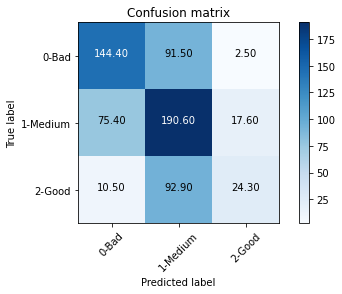

In [88]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
plot_confusion_matrix(conf_mat_mean,["0-Bad","1-Medium","2-Good"])

In [82]:
time_end = time.time()
print((time_end - time_begin)/60)

207.3551213304202
